# **CLASSIFICATION OF LOG FILE DATA INTO NORMAL TRAFFIC, MANUAL ATTACKS AND AUTOMATED ATTACKS AND ANALYSIS ON TYPES OF ATTACKS AND THEIR SUBNETS AND COUNTRIES OF ORIGIN**

##- Shwetha S

# Importing Libraries

In [ ]:
import os
import re
import json
import time
import datetime
import asyncio
import numpy as np
import pandas as pd
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from urllib.request import urlopen
from datetime import datetime
from sklearn.metrics import auc
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from pandas.core.frame import DataFrame
from ipaddress import IPv4Network, IPv4Address
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.8 MB/s 


#Uploading Files

In [ ]:
#Uploading the conpot log file  and appending the log lines to 'linelist'
file = open('/content/logss.log', 'r')
linelist = []
for line in file:
  linelist.append(line)

In [ ]:
#Number of lines in Conpot log file
len(linelist)

1292390

In [ ]:
# Uploading CSIC dataset normal traffic training file and appending them to linelist2(list)
file2 = open('/content/normalTrafficTraining.txt', 'r')
linelist2 = []
for line in file2:
  linelist2.append(line)

In [ ]:
#Number of lines in CSIC Normal Traffic Training data file
len(linelist2)

492000

In [ ]:
# Uploading CSIC dataset anomalous traffic testing file and appending them to linelist3(list)
file3 = open('/content/anomalousTrafficTest.txt', 'r')
linelist3 = []
for line in file3:
  linelist3.append(line)

In [ ]:
#Number of lines in CSIC Anomalous Traffic Testing data file
len(linelist3)

355776

# Function to find the country by IP Address

In [ ]:
#Finding country of an ip address after sending it and getting the result(response) from the geolocation API 'ip-api'
def findipbycountry(ip):
  GEO_IP_API_URL  = 'http://ip-api.com/json/'
  IP_TO_SEARCH    = ip
  url=GEO_IP_API_URL+IP_TO_SEARCH
  url = url.replace(" ", "%20")
  req             = urllib.request.Request(url)
  response        = urllib.request.urlopen(req).read()
  json_response   = json.loads(response.decode('utf-8'))
  if json_response:
    if json_response['status']=='fail':
      return 'error'
    else:
      return json_response['country']
  else:
    return 'error'

# Extracting HTTP Sessions from Conpot Log File

In [ ]:
# Extracting all the HTTP protocol sessions from conpot log file into 'httpsession list' using regular expression(re.search)
httpsessionlist=[]
for line in range(1292390):
  intermediatelist=[]
  if re.search( r'New http session (.*?) .*', linelist[line]):
    intermediatelist.append(linelist[line])
    line=line+1
    while line<1292390:
      if not re.search( r'Session timed out:', linelist[line]):
        intermediatelist.append(linelist[line])
        line=line+1
      else:
        intermediatelist.append(linelist[line])
        httpsessionlist.append(intermediatelist)
        line=line+1
        break

In [ ]:
#Total number of http sessions
len(httpsessionlist)

1837

In [ ]:
#Displaying a HTTP session log 
httpsessionlist[495]

['2019-11-05 01:28:07,313 New http session from 5.189.179.2 (08d8ada5-8b18-47ed-a950-9c25ea584ff5)\n',
 "2019-11-05 01:28:07,314 HTTP/1.0 GET request from ('5.189.179.2', 61000): ('/', [('User-Agent', 'masscan/1.0 (https://github.com/robertdavidgraham/masscan)'), ('Accept', '*/*')], None). 08d8ada5-8b18-47ed-a950-9c25ea584ff5\n",
 "2019-11-05 01:28:07,315 HTTP/1.0 response to ('5.189.179.2', 61000): 302. 08d8ada5-8b18-47ed-a950-9c25ea584ff5\n",
 "2019-11-05 01:28:25,703 New IPMI traffic from ('184.105.247.254', 45985)\n",
 "2019-11-05 01:28:25,704 New IPMI session initialized for client (('184.105.247.254', 45985))\n",
 "2019-11-05 01:28:25,705 Connection established with ('184.105.247.254', 45985)\n",
 "2019-11-05 01:28:25,706 IPMI response sent to ('184.105.247.254', 45985)\n",
 '2019-11-05 01:28:39,333 Session timed out: 08d8ada5-8b18-47ed-a950-9c25ea584ff5\n']

# Dataset Construction by Parsing HTTP Log Sessions

In [ ]:
#Defining a dataframe for HTTP protocol
httpdf = pd.DataFrame(columns = ["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PAYLOAD","REQUEST FROM COUNTRY","PORT","CONTENT","REQUEST","USER AGENT","ACCEPT","ENCODING","LANGUAGE","HOST","SESSION ID","CONTENT LENGTH","ATTACK"])

In [ ]:
#Displaying a HTTP session
httpsessionlist[0]

['2019-08-27 12:12:36,979 New http session from 202.3.77.166 (ca5a29c6-e107-4b18-99c1-08338aabfbc5)\n',
 "2019-08-27 12:12:36,981 HTTP/1.1 GET request from ('202.3.77.166', 34142): ('/', [('Host', '67.207.87.192'), ('Connection', 'keep-alive'), ('Upgrade-Insecure-Requests', '1'), ('User-Agent', 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36'), ('Accept', 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3'), ('Accept-Encoding', 'gzip, deflate'), ('Accept-Language', 'en-US,en;q=0.9,bn;q=0.8')], None). ca5a29c6-e107-4b18-99c1-08338aabfbc5\n",
 "2019-08-27 12:12:36,981 HTTP/1.1 response to ('202.3.77.166', 34142): 302. ca5a29c6-e107-4b18-99c1-08338aabfbc5\n",
 "2019-08-27 12:12:37,553 HTTP/1.1 GET request from ('202.3.77.166', 34142): ('/index.html', [('Host', '67.207.87.192'), ('Connection', 'keep-alive'), ('Upgrade-Insecure-Requests', '1'), ('User-Agent', 'Mozi

In [ ]:
# Parsing the list and storing the values in their respective dataframes
#Parsing the conpot log sessions into the dataframe attributes
#i - variable to iterate through each  session in the  sessionlist
#j - variable to iterate through all the contents of each session in i
#date- variable to be assigned to the 'DATE' attribute in the dataframe
#times- variable to be assigned to the 'TIMES' attribute in the dataframe
#response- variable to be assigned to the 'RESPONSE' attribute in the dataframe
#digit - The parsed numerical value from response
#req,r2-variable to be assigned to the 'REQUEST' attribute in the dataframe
#-ipaddress,ipaddress2- variables to be assigned to the 'IP ADDRESS' attribute in the dataframe
#ua1- variables to be assigned to the 'USER AGENT' attribute in the dataframe
#ae1- variables to be assigned to the 'ENCODING' attribute in the dataframe
#al1- variables to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs1- variables to be assigned to the 'HOST' attribute in the dataframe
#las- last entry in times list in hour:minute:second format
#fir- first time in times list in hour:minute:second format
#timedifference- variable to store value of the average time difference between subsequent requests in a session
#contents,cl2,cl2n - variable to be assigned to the 'CONTENTS' attribute in the dataframe
#countrylist - list variable to be assigned to the 'REQUEST FROM COUNTRY' attribute in the dataframe
#attack - variable to be assigned to the 'ATTACK' attribute in the dataframe, initialized to 'unknown'
#text - seach line in a session
#bsk - list to hold parsed values interemediately
#eachip - variable to iterate over ip address list
#STR - list in which the contents of 'text' are space separated
#f- flag to check if list 'STR' length is  more than 1  
#i1-variable to iterate over each line in list 'contents' 
#m-variable to iterate over each word in each line of list 'contents'
#portsinlist-iterate through port list to remove any entry that has more than 7 characters
#r - variable to iterate through various lists like ports
#sr - variable to hold stringified version of contents of any lists
#x,x2,x3,x4 - variables hold new value of a string after a string replace function is applied 
import time
words=[]
for i in range(1837):
  date=[]
  times=[]
  response=[]
  ipaddress=[]
  ports=[]
  payload=[]
  timedifference=0
  contents=[]
  countrylist=[]
  attack='unknown'
  for j in range(len(httpsessionlist[i])):
    text=httpsessionlist[i][j]
    f=0
    STR=text.split(" ")
    date.append(STR[0])
    contents.append(STR[2:len(STR)])
    if len(STR)>1:
      if len(STR[1].split(","))>1:
        t=STR[1].split(",")[0]
        times.append(t)
        r=STR[1].split(",")[1]
        response.append(r)
        f=1
        s=0
      if len(text[text.find("(")+1:text.find(")")].split(", ")) > 1:
        ip = text[text.find("(")+1:text.find(")")].split(", ")[0]
        ips=ip.replace("'", "")
        ipaddress.append(ips)
        port = text[text.find("(")+1:text.find(")")].split(",")[1]
        ports.append(port)
    if f==1:
      las=datetime.strptime(str(times[len(times)-1]),"%H:%M:%S")
      fir=datetime.strptime(str(times[0]),"%H:%M:%S")
      timedifference=((las-fir)/len(times)).total_seconds()
  #print(contents)
  req=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'^GET', str(contents[i1][m])) or re.search( r'^POST',str(contents[i1][m])):
        bsk.append(str(contents[i1][m]))
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\[\(',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            payload=payload+bsk[5:len(bsk)]
            req.append(bsk)
            break
  lr=len(req)
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    x2 =x.replace("b", "")
    r2.append(x2)
  ua=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'User-Agent', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\)\,',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            ua.append(bsk)
            break
  lr=len(ua)
  ua1=[]
  for r in range(len(ua)):
    sr=str(ua[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    ua1.append(x1) 
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    r2.append(x1)
  host=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Host', str(contents[i1][m])):
        host.append(contents[i1][m+1])
 
  lr=len(host)
  hs1=[]
  for r in range(len(host)):
    sr=str(host[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    hs1.append(x3)  
  ae=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Encoding', str(contents[i1][m])):
        ae.append(contents[i1][m+1])
  ae1=[]
  for r in range(len(ae)):
    sr=str(ae[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    ae1.append(x1)
  al=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Language', str(contents[i1][m])):
        al.append(contents[i1][m+1])
  al1=[]
  for r in range(len(al)):
    sr=str(al[r])
    #print(sr)
    x = sr.replace(",","")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    al1.append(x3)
  cl2=0
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Content-Length', str(contents[i1][m])):
        cl=str(contents[i1][m+1])
        sr=cl.replace(",", "")
        x = sr.replace("'", "")
        x1 =x.replace("\"", "")
        x2 =x1.replace(")", "")
        x3 =x2.replace("]", "")
        cl2=int(x3)
  for i1 in range(len(contents)):
    if len(contents[i1])>1:
      sid=contents[i1][len(contents[i1])-1] 
  res=[]
  res2=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'response', str(contents[i1][m])):
        if m+4<len(contents[i1]):
          res.append(contents[i1][m+4])
  for re1 in res:
    x=re1.replace(".","")
    res2.append(x)
  apt=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Accept', str(contents[i1][m])):
        apt.append(contents[i1][m+1])
  date=list(set(date))
  if len(date)==1:
    date=list(set(date))[0]
  res2=list(set(res2))
  if len(res2)==1:
    res2=list(set(res2))[0]
  ipaddress=list(set(ipaddress))
  if len(ipaddress)==1:
    ipaddress=list(set(ipaddress))[0]
    countrylist.append(findipbycountry(ipaddress))
    time.sleep(1)
  else:
    for eachip in ipaddress:
      countrylist.append(findipbycountry(eachip))
      time.sleep(1)
  countrylist=list(set(countrylist))
  if len(countrylist)==1:
    countrylist=list(set(countrylist))[0]
  ports=list(set(ports))
  if len(ports)==1:
    ports=list(set(ports))[0]
  r2=list(set(r2))
  if len(r2)==1:
    r2=list(set(r2))[0]
  ua1=list(set(ua1))
  if len(ua1)==1:
    ua1=list(set(ua1))[0]
  apt=list(set(apt))
  if len(apt)==1:
    apt=list(set(apt))[0]
  ae1=list(set(ae1))
  if len(ae1)==1:
    ae1=list(set(ae1))[0]
  al1=list(set(al1))
  if len(al1)==1:
    al1=list(set(al1))[0]
  hs1=list(set(hs1))
  if len(hs1)==1:
    hs1=list(set(hs1))[0]
  httpdf =httpdf.append({'DATE' : date, 'TIMES' : times,'TIME DIFFERENCE':timedifference ,'RESPONSE': res2,'IP' : ipaddress ,"PAYLOAD":payload,'REQUEST FROM COUNTRY': countrylist,'PORT' : ports,'CONTENT':contents,'REQUEST':r2,'USER AGENT':ua1,'ACCEPT':apt,'ENCODING':ae1,'LANGUAGE':al1,'HOST':hs1,'SESSION ID':sid,'CONTENT LENGTH':cl2,'ATTACK':attack},ignore_index = True)

In [ ]:
#To classify each session in the dataframe into normal traffic or attack based on regular expressions 
#at-type of attack
#i-loop variable for iterating through each snmpsession
#c-nested list httpdf['CONTENT'] of each session in the dataframe
#l-variable that iterates through each line [list] of httpdf['CONTENT'] list
#w-variable that iterates through each word in each line of l
#k - variable to iterate through all the list values in httpdf['RESPONSE']
#f-flag variable to identify if  all the responses in a session start with '4', initialized to 1
at="unknown"
s=0
m=0
n=0
for i in range(1837):
  for c in httpdf.loc[i,"CONTENT"]:
    for l in c:
      for w in l:
        if re.search(r'tamper',w) or re.search(r'set',w) or re.search(r'table',w) or re.search(r'cookie',w) or re.search(r'boot',w) or re.search(r'access',w) or re.search(r'log',w) or re.search(r'onload',w) or re.search(r'onerror',w) or re.search(r'div',w) or re.search(r'createelement',w) or re.search(r'script',w)  or re.search(r'javascript',w) or re.search(r'include',w) or re.search(r'cmd',w) or re.search(r'into',w) or re.search(r'count',w) or re.search(r'xp',w) or re.search(r'printenv',w) or re.search(r'homedirectory',w) or re.search(r'TRUNCATE',w) or re.search(r'replace',w) or re.search(r'delete',w) or re.search(r'update',w) or re.search(r'INSERT',w)  or re.search(r'expression',w) or re.search(r'applet',w) or re.search(r'embed',w) or re.search(r'vbscript',w) or re.search(r'iframe',w) or re.search(r'frame',w) or re.search(r'frameset',w) or re.search(r'object',w) or re.search(r'sleep',w) or re.search(r'exec',w) or re.search(r'UNION',w) or re.search( r'select',w) or re.search(r'/etc/passwd',w) or re.search( r'proxy',w) or re.search( r'AND',w) or re.search(r'OR',w) or re.search( r'DROP',w) or re.search( r'SELECT',w) or re.search(r'ping',w) or re.search( r'cat',w) or re.search(r'shell',w) or re.search( r'admin',w) or re.search( r'config',w) or re.search(r'commit',w) or re.search( r'sql',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search( r'document',w) or re.search( r'window',w) or re.search(r'location',w) or re.search(r'this',w) or re.search(r'search',w) or re.search(r'img',w) or re.search(r'\<',w) or re.search(r'src',w) or re.search(r'href',w)  or re.search(r'var',w) or re.search(r'eval()',w) or re.search(r'not',w) or re.search(r'null',w) or re.search(r'like',w) or re.search(r'.conf',w) or re.search(r'echo',w) or re.search(r'system.ini',w) or re.search(r'.bin',w) or re.search(r'display',w) or re.search(r'odbc',w) or re.search(r'var',w) or re.search(r'.exe',w)  or re.search(r'\+connect',w) or re.search(r'bash',w) or re.search(r'uname',w) or re.search(r'root',w) or re.search(r'mail',w) or re.search(r'path/',w) or re.search(r'text()',w) or re.search(r'child',w) or re.search(r'sleep',w) or re.search(r'position',w) or re.search(r'.bat',w) or re.search( r'home/',w) or re.search(r'/#include',w) or re.search( r'fromhost',w) or re.search( r'replyto',w) or re.search(r'mail',w) or re.search( r'est',w) or re.search( r'comment',w) or re.search(r'position',w) or re.search( r'sender',w):
          if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
            at="Attack"
            s=s+1
            #print("autom",s)
            break
          else:
            at="Attack"
            m=m+1
            #print("man",m)
            break
        elif httpdf.loc[i,"TIME DIFFERENCE"]<5.0:
          f=1
          res=httpdf.loc[i,"RESPONSE"]
          for k in range(len(httpdf.loc[i,"RESPONSE"])):
            if re.search(r'^4',res[k]):
              f=0
            else:
              break
          if f==0:
            at="Attack"
            break
          else:
            at="Attack"
        else:
          at="Not an attack"
          n=n+1
          #print("not",n)
          break
  httpdf.loc[i,"ATTACK"]= at


In [ ]:
httpdf

,DATE,TIMES,TIME DIFFERENCE,RESPONSE,IP,PAYLOAD,REQUEST FROM COUNTRY,PORT,CONTENT,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,2019-08-27,"[12:12:36, 12:12:36, 12:12:36, 12:12:37, 12:12...",4.000000,"[404, 302, 200]",202.3.77.166,"[('/',, ('/index.html',, ('/favicon.ico',]",India,34142,"[[New, http, session, from, 202.3.77.166, (ca5...","[[GET request from ""(202.3.77.166 "" 34142)...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8')],, 'text/html,appl...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,ca5a29c6-e107-4b18-99c1-08338aabfbc5\n,0,Attack
1,2019-08-27,"[12:14:17, 12:14:17, 12:14:17, 12:14:47]",7.500000,302,165.16.37.187,"[('/',]",Libya,56987,"[[New, http, session, from, 165.16.37.187, (d3...","[GET request from ""(165.16.37.187 "" 56987)...","[""Mozilla/5.0"" (Windows NT 10.0; WOW64) A...",[],[],[],67.207.87.192:80,d39c9889-d4ab-41f2-b4c4-6d16ce34c830\n,0,Not an attack
2,2019-08-27,"[12:36:38, 12:36:38, 12:36:38, 12:37:10]",8.000000,200,202.3.77.166,"[('/index.html',]",India,34498,"[[New, http, session, from, 202.3.77.166, (b86...","[GET request from ""(202.3.77.166 "" 34498):...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8'),, 'gzip,, 'text/ht...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,b86a48f6-31e1-43a7-81ec-d41276e4cc0c\n,0,Not an attack
3,2019-08-27,"[12:49:26, 12:49:26, 12:49:26, 12:49:56]",7.500000,200,202.3.77.166,"[('/index.html',]",India,34628,"[[New, http, session, from, 202.3.77.166, (5a9...","[GET request from ""(202.3.77.166 "" 34628):...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8'),, 'gzip,, 'text/ht...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,5a9bc7cb-3994-44a9-9ec7-bdc0949c20d8\n,0,Not an attack
4,2019-08-27,"[14:33:45, 14:33:45, 14:33:45, 14:34:15]",7.500000,404,83.97.20.189,"[('/imgs/ms_check_license',]",Romania,38120,"[[New, http, session, from, 83.97.20.189, (d19...","[GET request from ""(83.97.20.189 "" 38120):...","[""\Mozilla/5.0 (Macintosh; Intel Mac OS X...","['*/*'),, 'gzip')],]",gzip)],[],67.207.87.192,d19d4ab8-0acd-42a2-8b2a-bccc8bfc77c3\n,0,Not an attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,2019-12-07,"[11:39:33, 11:39:33, 11:39:33, 11:40:03]",7.500000,302,177.118.138.167,"[('/',]",Brazil,49550,"[[New, http, session, from, 177.118.138.167, (...","[GET request from ""(177.118.138.167 "" 4955...","[""Mozilla/5.0"" (Windows NT 10.0; WOW64) A...",[],[],[],67.207.87.192:80,da94dc4d-736e-42b4-afe9-daaa9fda00a1\n,0,Not an attack
1833,2019-12-07,"[12:14:34, 12:14:34, 12:14:34, 12:14:35, 12:14...",1.590909,"[404, 302, 200]",220.248.165.19,"[('/TP/public/index.php',, ('/TP/index.php',, ...",China,"[ 41471, 59926, 33218, 44485, 55800, 4774...","[[New, http, session, from, 220.248.165.19, (a...","[[GET request from ""(220.248.165.19 "" 3647...","[""Mozilla/5.0"" (Windows; U; Windows NT 6....","'gzip')],",gzip)],[],"[67.207.87.192:80, 67.207.87.192]",abe3a559-d19d-4dac-af63-b1a3e2c91303\n,0,Attack
1834,2019-12-07,"[12:52:09, 12:52:09, 12:52:09, 12:52:39]",7.500000,404,220.133.187.251,"[('/editBlackAndWhiteList',]",Taiwan,34146,"[[New, http, session, from, 220.133.187.251, (...","[POST request from ""(220.133.187.251 "" 341...",[],"['identity'),, '*/*'),, 'en-us'),]",identity),en-us,67.207.87.192,3c9feedb-b5e1-4381-adc3-5ac6382756ce\n,586,Not an attack
1835,2019-12-07,"[16:20:26, 16:20:26, 16:20:26, 16:20:58]",8.000000,302,95.47.140.172,"[('/',]",Russia,50205,"[[New, http, session, from, 95.47.140.172, (3e...","[GET request from ""(95.47.140.172 "" 50205)...","[""Mozilla/5.0"" (Windows NT 6.1; WOW64) Ap...",[],[],[],67.207.87.192:80,3e51df50-57b7-4e4e-9d4d-60bebfae8d23\n,0,Not an attack


# Extracting SNMP Sessions from Conpot Log File

In [ ]:
# Extracting all the SNMP protocol sessions from conpot log file into 'snmpsession list' using regular expression(re.search)
snmpsessionlist=[]
for line in range(1292390):
  intermediatelist=[]
  if re.search( r'New snmp session (.*?) .*', linelist[line]):
    intermediatelist.append(linelist[line])
    line=line+1
    while line<1292390:
      if not re.search( r'Session timed out:', linelist[line]):
        intermediatelist.append(linelist[line])
        line=line+1
      else:
        intermediatelist.append(linelist[line])
        snmpsessionlist.append(intermediatelist)
        line=line+1
        break

In [ ]:
# Total number of snmp sessions
len(snmpsessionlist)

258

In [ ]:
#Displaying the first session of the SNMP session list 
snmpsessionlist[0]

['2019-08-27 13:48:14,809 New snmp session from 80.82.77.86 (1cb919bd-6fc6-4249-8ef2-f92ced5d7be9)\n',
 "2019-08-27 13:48:14,810 SNMPv1 Get request from ('80.82.77.86', 53132): 1.3.6.1.2.1.1.1.0\n",
 "2019-08-27 13:48:14,810 SNMPv1 Get response to ('80.82.77.86', 53132): 1.3.6.1.2.1.1.1.0 Siemens, SIMATIC, S7-200\n",
 '2019-08-27 13:48:44,825 Session timed out: 1cb919bd-6fc6-4249-8ef2-f92ced5d7be9\n']

# Dataset Construction by Parsing SNMP Log Sessions

In [ ]:
#Declaring the SNMP Dataframe  
snmpdf = pd.DataFrame(columns = ["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","REQUEST FROM COUNTRY","PORT","CONTENT","REQUEST","USER AGENT","ACCEPT","ENCODING","LANGUAGE","HOST","SESSION ID","CONTENT LENGTH","ATTACK"])

In [ ]:
#Parsing the conpot log sessions into the dataframe attributes
#i - variable to iterate through each  session in the  sessionlist
#j - variable to iterate through all the contents of each session in i
#date- variable to be assigned to the 'DATE' attribute in the dataframe
#times- variable to be assigned to the 'TIMES' attribute in the dataframe
#response- variable to be assigned to the 'RESPONSE' attribute in the dataframe
#digit - The parsed numerical value from response
#req,r2-variable to be assigned to the 'REQUEST' attribute in the dataframe
#-ipaddress,ipaddress2- variables to be assigned to the 'IP ADDRESS' attribute in the dataframe
#ua1- variables to be assigned to the 'USER AGENT' attribute in the dataframe
#ae1- variables to be assigned to the 'ENCODING' attribute in the dataframe
#al1- variables to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs1- variables to be assigned to the 'HOST' attribute in the dataframe
#las- last entry in times list in hour:minute:second format
#fir- first time in times list in hour:minute:second format
#timedifference- variable to store value of the average time difference between subsequent requests in a session
#contents,cl2,cl2n - variable to be assigned to the 'CONTENTS' attribute in the dataframe
#countrylist - list variable to be assigned to the 'REQUEST FROM COUNTRY' attribute in the dataframe
#attack - variable to be assigned to the 'ATTACK' attribute in the dataframe, initialized to 'unknown'
#text - seach line in a session
#bsk - list to hold parsed values interemediately
#eachip - variable to iterate over ip address list
#STR - list in which the contents of 'text' are space separated
#f- flag to check if list 'STR' length is  more than 1  
#i1-variable to iterate over each line in list 'contents' 
#m-variable to iterate over each word in each line of list 'contents'
#portsinlist-iterate through port list to remove any entry that has more than 7 characters
#r - variable to iterate through various lists like ports
#sr - variable to hold stringified version of contents of any lists
#x,x2,x3,x4 - variables hold new value of a string after a string replace function is applied 
import time
words=[]
for i in range(258):
  date=[]
  times=[]
  response=[]
  ipaddress=[]
  ports=[]
  timedifference=0
  contents=[]
  countrylist=[]
  attack="unknown"
  for j in range(len(snmpsessionlist[i])):
    text=snmpsessionlist[i][j]
    f=0
    STR=text.split(" ")
    date.append(STR[0])
    contents.append(STR[2:len(STR)])
    if len(STR)>1:
      if len(STR[1].split(","))>1:
        t=STR[1].split(",")[0]
        times.append(t)
        f=1
    for i1 in range(len(contents)):
      for m in range(len(contents[i1])):
        if re.search(r'from', str(contents[i1][m])):
          ipaddress.append(contents[i1][m+1])
          ports.append(contents[i1][m+2])
    for portsinlist in ports:
      if len(portsinlist)>7:
        ports.remove(portsinlist)
    ports2=[]
    for r in range(len(ports)):
      sr=str(ports[r])
      x = sr.replace(")", "")
      x1 = x.replace(":", "")
      ports2.append(x1)
    ipaddress2=[]
    for r in range(len(ipaddress)):
      sr=str(ipaddress[r])
      x = sr.replace("(", "")
      x1 = x.replace("'", "")
      x2 = x1.replace(",", "")
      ipaddress2.append(x2)
    if f==1:
      las=datetime.strptime(str(times[len(times)-1]),"%H:%M:%S")
      fir=datetime.strptime(str(times[0]),"%H:%M:%S")
      timedifference=((las-fir)/len(times)).total_seconds()
  #print(contents)
  req=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'request', str(contents[i1][m])):
        if len(contents[i1])>m+4:
          req.append(str(contents[i1][m+4]))
  lr=len(req)
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace("b", "")
    r2.append(x)
  ua=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search(r'User-Agent', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\)\],',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            ua.append(bsk)
            break
  lr=len(ua)
  ua1=[]
  for r in range(len(ua)):
    sr=str(ua[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    ua1.append(x1) 
  host=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Host', str(contents[i1][m])):
        host.append(contents[i1][m+1])
  lr=len(host)
  hs1=[]
  for r in range(len(host)):
    sr=str(host[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    x4=x3.replace("}","")
    hs1.append(x4)  
  ae=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Encoding', str(contents[i1][m])):
        ae.append(contents[i1][m+1])
  ae1=[]
  for r in range(len(ae)):
    sr=str(ae[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    ae1.append(x1)
  al=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Language', str(contents[i1][m])):
        al.append(contents[i1][m+1])
  al1=[]
  for r in range(len(al)):
    sr=str(al[r])
    #print(sr)
    x = sr.replace(",","")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    al1.append(x3)
  for i1 in range(len(contents)):
    if len(contents[i1])>1:
      sid=contents[i1][len(contents[i1])-1] 
  res=[]
  for i1 in range(len(contents)):
    digit=""
    for m in range(len(contents[i1])):
      if re.search( r'to', str(contents[i1][m])):
        for tillend in range(m+3,len(contents[i1])):
          res.append(str(contents[i1][tillend]))
  apt=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Accept', str(contents[i1][m])):
        apt.append(contents[i1][m+1])
  cl2=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search(r'transferred', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\(bytes\)\n',str(contents[i1][m])):
            cl2.append(str(contents[i1][m]))
            m=m+1
          else:
            break
  ipaddress=list(set(ipaddress2))
  if len(ipaddress)==1:
    ipaddress=list(set(ipaddress))[0]
    ctry=findipbycountry(ipaddress)
    time.sleep(1.5)
    if ctry is not 'error':
      countrylist.append(ctry)
    else:
      break
  else:
    if len(ipaddress)<=3:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
    else:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1.7)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
  countrylist=list(set(countrylist))
  if len(countrylist)==1:
    countrylist=list(set(countrylist))[0]
  cl2n=[]
  for cnt in cl2:
    if cnt.isdigit():
      cl2n.append(cnt)
  date=list(set(date))
  if len(date)==1:
    date=list(set(date))[0]
  res=list(set(res))
  if len(res)==1:
    res=list(set(res))[0]
  ports2=list(set(ports2))
  if len(ports2)==1:
    ports2=list(set(ports2))[0]
  r2=list(set(r2))
  if len(r2)==1:
    r2=list(set(r2))[0]
  ua1=list(set(ua1))
  if len(ua1)==1:
    ua1=list(set(ua1))[0]
  apt=list(set(apt))
  if len(apt)==1:
    apt=list(set(apt))[0]
  ae1=list(set(ae1))
  if len(ae1)==1:
    ae1=list(set(ae1))[0]
  al1=list(set(al1))
  if len(al1)==1:
    al1=list(set(al1))[0]
  hs1=list(set(hs1))
  if len(hs1)==1:
    hs1=list(set(hs1))[0]
  if len(cl2n)>0:
    cl2n=list(set(cl2n))[0]
  else:
    cl2n=0
  snmpdf =snmpdf.append({'DATE' : date, 'TIMES' : times,'TIME DIFFERENCE':timedifference ,'RESPONSE': res,'IP' : ipaddress ,'REQUEST FROM COUNTRY': countrylist, 'PORT' : ports2,'CONTENT':contents,'REQUEST':r2,'USER AGENT':ua1,'ACCEPT':apt,'ENCODING':ae1,'LANGUAGE':al1,'HOST':hs1,'SESSION ID':sid,'CONTENT LENGTH':cl2n,'ATTACK':attack},ignore_index = True)

In [ ]:
#To classify each session in the dataframe into normal traffic or attack based on regular expressions 
#at-type of attack
#i-loop variable for iterating through each snmpsession
#c-nested list snmpdf['CONTENT'] of each session in the dataframe
#l-variable that iterates through each line [list] of snmpdf['CONTENT'] list
#w-variable that iterates through each word in each line of l
#k - variable to iterate through all the list values in snmpdf['RESPONSE']
#f-flag variable to identify if  all the responses in a session start with '4', initialized to 1
at=""
for i in range(258):
  for c in snmpdf.loc[i,"CONTENT"]:
    for l in c:
      for w in l:
        if re.search(r'tamper',w) or re.search(r'set',w) or re.search(r'table',w) or re.search(r'cookie',w) or re.search(r'boot',w) or re.search(r'access',w) or re.search(r'log',w) or re.search(r'onload',w) or re.search(r'onerror',w) or re.search(r'div',w) or re.search(r'createelement',w) or re.search(r'script',w)  or re.search(r'javascript',w) or re.search(r'include',w) or re.search(r'cmd',w) or re.search(r'into',w) or re.search(r'count',w) or re.search(r'xp',w) or re.search(r'printenv',w) or re.search(r'homedirectory',w) or re.search(r'TRUNCATE',w) or re.search(r'replace',w) or re.search(r'delete',w) or re.search(r'update',w) or re.search(r'INSERT',w)  or re.search(r'expression',w) or re.search(r'applet',w) or re.search(r'embed',w) or re.search(r'vbscript',w) or re.search(r'iframe',w) or re.search(r'frame',w) or re.search(r'frameset',w) or re.search(r'object',w) or re.search(r'sleep',w) or re.search(r'exec',w) or re.search(r'UNION',w) or re.search( r'select',w) or re.search(r'/etc/passwd',w) or re.search( r'proxy',w) or re.search( r'AND',w) or re.search(r'OR',w) or re.search( r'DROP',w) or re.search( r'SELECT',w) or re.search(r'ping',w) or re.search( r'cat',w) or re.search(r'shell',w) or re.search( r'admin',w) or re.search( r'config',w) or re.search(r'commit',w) or re.search( r'sql',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search( r'document',w) or re.search( r'window',w) or re.search(r'location',w) or re.search(r'this',w) or re.search(r'search',w) or re.search(r'img',w) or re.search(r'\<',w) or re.search(r'src',w) or re.search(r'href',w)  or re.search(r'var',w) or re.search(r'eval()',w) or re.search(r'not',w) or re.search(r'null',w) or re.search(r'like',w) or re.search(r'.conf',w) or re.search(r'echo',w) or re.search(r'system.ini',w) or re.search(r'.bin',w) or re.search(r'display',w) or re.search(r'odbc',w) or re.search(r'var',w) or re.search(r'.exe',w)  or re.search(r'\+connect',w) or re.search(r'bash',w) or re.search(r'uname',w) or re.search(r'root',w) or re.search(r'mail',w) or re.search(r'path/',w) or re.search(r'text()',w) or re.search(r'child',w) or re.search(r'sleep',w) or re.search(r'position',w) or re.search(r'.bat',w) or re.search( r'home/',w) or re.search(r'/#include',w) or re.search( r'fromhost',w) or re.search( r'replyto',w) or re.search(r'mail',w) or re.search( r'est',w) or re.search( r'comment',w) or re.search(r'position',w) or re.search( r'sender',w):
          if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
            at="Attack"
            break
          else:
            at="Attack"
            break
        elif snmpdf.loc[i,"TIME DIFFERENCE"]<5.0:
          f=1
          res=snmpdf.loc[i,"RESPONSE"]
          for k in range(len(snmpdf.loc[i,"RESPONSE"])):
            if re.search(r'^4',res[k]):
              f=0
            else:
              break
          if f==0:
            at="Attack"
            break
          else:
            at="Attack"
        else:
          at="Not an attack"
          break
  snmpdf.loc[i,"ATTACK"]= at

In [ ]:
#SNMP Dataframe
snmpdf

,DATE,TIMES,TIME DIFFERENCE,RESPONSE,IP,REQUEST FROM COUNTRY,PORT,CONTENT,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,2019-08-27,"[13:48:14, 13:48:14, 13:48:14, 13:48:44]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",80.82.77.86,Netherlands,53132,"[[New, snmp, session, from, 80.82.77.86, (1cb9...",1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],1cb919bd-6fc6-4249-8ef2-f92ced5d7be9\n,0,Not an attack
1,2019-08-27,"[17:35:38, 17:35:38, 17:35:38, 17:36:09]",7.75,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",104.206.128.74,United States,61076,"[[New, snmp, session, from, 104.206.128.74, (2...",1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],2dc8ba3b-1e00-4ce0-ba5b-51f4c1760593\n,0,Not an attack
2,2019-08-27,"[18:34:37, 18:34:37, 18:34:37, 18:35:07]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",52.73.169.169,United States,42519,"[[New, snmp, session, from, 52.73.169.169, (7a...",1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],7ae575d6-f58a-401d-8a9a-48f3130ad90a\n,0,Not an attack
3,2019-08-27,"[20:41:20, 20:41:20, 20:41:20, 20:41:50]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",23.247.118.10,United States,29242,"[[New, snmp, session, from, 23.247.118.10, (c8...",1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],c87ea018-5686-4f6c-ac10-5321a3337ac4\n,0,Not an attack
4,2019-08-27,"[20:57:41, 20:57:41, 20:57:41, 20:57:53]",3.00,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",92.118.160.37,United States,55409,"[[New, snmp, session, from, 92.118.160.37, (b2...",1.3.6.1.2.1\n,[],[],[],[],[],3436496d-5bc7-4627-94c8-b12a0f79d053\n,0,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2019-12-07,"[04:28:48, 04:28:48, 04:28:48, 04:29:18]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",196.52.43.95,Mauritius,49670,"[[New, snmp, session, from, 196.52.43.95, (b92...",1.3.6.1.2.1,[],[],[],[],[],b92b939c-f765-4d84-a11d-17f8ed372334\n,0,Not an attack
254,2019-12-07,"[05:18:00, 05:18:00, 05:18:00, 05:18:30]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",184.105.139.67,United States,25503,"[[New, snmp, session, from, 184.105.139.67, (d...",1.3.6.1.2.1.1.1.0,[],[],[],[],[],dc223963-81fe-4d18-ac1a-2fb6f120fd7c\n,0,Not an attack
255,2019-12-07,"[05:42:13, 05:42:13, 05:42:13, 05:42:43]",7.50,"[1.3.6.1.2.1.1.1.0, SIMATIC,, Siemens,, S7-200\n]",146.88.240.4,United States,47459,"[[New, snmp, session, from, 146.88.240.4, (0bc...",1.3.6.1.2.1,[],[],[],[],[],0bca1de8-e3d4-4668-80ac-df230e7e12b8\n,0,Not an attack
256,2019-12-07,"[05:54:58, 05:54:58, 05:54:58, 05:55:28]",7.50,"[EX40\n, 1.3.6.1.2.1.1.5.0, CP, 443-1]",184.105.139.67,United States,16080,"[[New, snmp, session, from, 184.105.139.67, (2...",1.3.6.1.2.1.1.5.0,[],[],[],[],[],2ef29d0b-e8fc-4165-ac18-8a442a25ab11\n,0,Not an attack


# Extracting Bacnet Sessions from Conpot Log File

In [ ]:
# Extracting all the BACNET protocol sessions from conpot log file into 'bacsession list'
bacsessionlist=[]
for line in range(1292390):
  intermediatelist=[]
  if re.search( r'New bacnet session (.*?) .*', linelist[line]):
    intermediatelist.append(linelist[line])
    line=line+1
    while line<1292390:
      if not re.search( r'Session timed out:', linelist[line]):
        intermediatelist.append(linelist[line])
        line=line+1
      else:
        intermediatelist.append(linelist[line])
        bacsessionlist.append(intermediatelist)
        line=line+1
        break

In [ ]:
# Total number of bacnet sessions
len(bacsessionlist)

102

In [ ]:
#Displaying a BACNET session
bacsessionlist[64]

['2019-11-23 07:22:32,319 New bacnet session from 146.88.240.4 (5457159d-8e90-443c-9a5b-6f6c560cb758)\n',
 '2019-11-23 07:22:32,319 New Bacnet connection from 146.88.240.4:37953. (5457159d-8e90-443c-9a5b-6f6c560cb758)\n',
 '2019-11-23 07:22:32,320 DecodingError - PDU: <PDU None -> None : 0a.00.11.01.04.00.05.b5.0c.0c.02.3f.ff.ff.19.4b>\n',
 '2019-11-23 07:23:02,335 Session timed out: 5457159d-8e90-443c-9a5b-6f6c560cb758\n']

# Dataset Construction by Parsing Bacnet Log Sessions

In [ ]:
#Declaring the BACNET Dataframe
bacdf = pd.DataFrame(columns = ["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","REQUEST FROM COUNTRY","PORT","CONTENT","REQUEST","USER AGENT","ACCEPT","ENCODING","LANGUAGE","HOST","SESSION ID","CONTENT LENGTH","ATTACK"])

In [ ]:
#Parsing the conpot log sessions into the dataframe attributes
#i - variable to iterate through each  session in the  sessionlist
#j - variable to iterate through all the contents of each session in i
#date- variable to be assigned to the 'DATE' attribute in the dataframe
#times- variable to be assigned to the 'TIMES' attribute in the dataframe
#response- variable to be assigned to the 'RESPONSE' attribute in the dataframe
#digit - The parsed numerical value from response
#req,r2-variable to be assigned to the 'REQUEST' attribute in the dataframe
#-ipaddress,ipaddress2- variables to be assigned to the 'IP ADDRESS' attribute in the dataframe
#ua1- variables to be assigned to the 'USER AGENT' attribute in the dataframe
#ae1- variables to be assigned to the 'ENCODING' attribute in the dataframe
#al1- variables to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs1- variables to be assigned to the 'HOST' attribute in the dataframe
#las- last entry in times list in hour:minute:second format
#fir- first time in times list in hour:minute:second format
#timedifference- variable to store value of the average time difference between subsequent requests in a session
#contents,cl2,cl2n - variable to be assigned to the 'CONTENTS' attribute in the dataframe
#countrylist - list variable to be assigned to the 'REQUEST FROM COUNTRY' attribute in the dataframe
#attack - variable to be assigned to the 'ATTACK' attribute in the dataframe, initialized to 'unknown'
#text - seach line in a session
#bsk - list to hold parsed values interemediately
#eachip - variable to iterate over ip address list
#STR - list in which the contents of 'text' are space separated
#f- flag to check if list 'STR' length is  more than 1  
#i1-variable to iterate over each line in list 'contents' 
#m-variable to iterate over each word in each line of list 'contents'
#portsinlist-iterate through port list to remove any entry that has more than 7 characters
#r - variable to iterate through various lists like ports
#sr - variable to hold stringified version of contents of any lists
#x,x2,x3,x4 - variables hold new value of a string after a string replace function is applied 
import time
words=[]
for i in range(102):
  date=[]
  times=[]
  response=[]
  ipaddress=[]
  ports=[]
  timedifference=0
  contents=[]
  countrylist=[]
  attack="unknown"
  for j in range(len(bacsessionlist[i])):
    text=bacsessionlist[i][j]
    f=0
    STR=text.split(" ")
    date.append(STR[0])
    contents.append(STR[2:len(STR)])
    if len(STR)>1:
      if len(STR[1].split(","))>1:
        t=STR[1].split(",")[0]
        times.append(t)
        r=STR[1].split(",")[1]
        response.append(r)
        f=1
        s=0
    for i1 in range(len(contents)):
      for m in range(len(contents[i1])):
        if re.search(r'from', str(contents[i1][m])):
          ipaddress.append(contents[i1][m+1])
    if f==1:
      las=datetime.strptime(str(times[len(times)-1]),"%H:%M:%S")
      fir=datetime.strptime(str(times[0]),"%H:%M:%S")
      timedifference=((las-fir)/len(times)).total_seconds()
  #print(contents)
  req=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'None', str(contents[i1][m])):
        if len(contents[i1][m+2])>4:
          req.append(str(contents[i1][m+2]))
  lr=len(req)
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace("b", "")
    r2.append(x)
  ua=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search(r'User-Agent', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\)\],',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            ua.append(bsk)
            break
  lr=len(ua)
  ua1=[]
  for r in range(len(ua)):
    sr=str(ua[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    ua1.append(x1) 
  host=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Host', str(contents[i1][m])):
        host.append(contents[i1][m+1])
 
  lr=len(host)
  hs1=[]
  for r in range(len(host)):
    sr=str(host[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    x4=x3.replace("}","")
    hs1.append(x4)  
  ae=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Encoding', str(contents[i1][m])):
        ae.append(contents[i1][m+1])
  ae1=[]
  for r in range(len(ae)):
    sr=str(ae[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    ae1.append(x1)
  al=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Language', str(contents[i1][m])):
        al.append(contents[i1][m+1])
  al1=[]
  for r in range(len(al)):
    sr=str(al[r])
    #print(sr)
    x = sr.replace(",","")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    al1.append(x3)
  for i1 in range(len(contents)):
    if len(contents[i1])>1:
      sid=contents[i1][len(contents[i1])-1] 
  res=[]
  for i1 in range(len(contents)):
    digit=""
    for m in range(len(contents[i1])):
      if re.search( r'response', str(contents[i1][m])):
        if m+1<len(contents[i1]):
          for char in contents[i1][m+1]:
            if char.isdigit():
              digit=digit+char
          res.append(digit)
  apt=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Accept', str(contents[i1][m])):
        apt.append(contents[i1][m+1])
  cl2=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search(r'transferred', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\(bytes\)\n',str(contents[i1][m])):
            cl2.append(str(contents[i1][m]))
            m=m+1
          else:
            break
  ipaddress2=[]
  for ipinad in ipaddress:
    portflag=0
    for ind in range(len(ipinad)):
      if ipinad[ind]==":":
        portflag=1
        ipaddress2.append(ipinad[:ind])
        ports.append(ipinad[ind+1:len(ipinad)-1])
    if portflag==0:
      ipaddress2.append(ipinad)
    else:
      break
  ipaddress=list(set(ipaddress2))
  if len(ipaddress)==1:
    ipaddress=list(set(ipaddress))[0]
    ctry=findipbycountry(ipaddress)
    time.sleep(1)
    if ctry is not 'error':
      countrylist.append(ctry)
    else:
      break
  else:
    if len(ipaddress)<=3:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
    else:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1.7)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
  countrylist=list(set(countrylist))
  if len(countrylist)==1:
    countrylist=list(set(countrylist))[0]
  cl2n=[]
  for cnt in cl2:
    if cnt.isdigit():
      cl2n.append(cnt)
  date=list(set(date))
  if len(date)==1:
    date=list(set(date))[0]
  res=list(set(res))
  if len(res)==1:
    res=list(set(res))[0]
  ports=list(set(ports))
  if len(ports)==1:
    ports=list(set(ports))[0]
  r2=list(set(r2))
  if len(r2)==1:
    r2=list(set(r2))[0]
  ua1=list(set(ua1))
  if len(ua1)==1:
    ua1=list(set(ua1))[0]
  apt=list(set(apt))
  if len(apt)==1:
    apt=list(set(apt))[0]
  ae1=list(set(ae1))
  if len(ae1)==1:
    ae1=list(set(ae1))[0]
  al1=list(set(al1))
  if len(al1)==1:
    al1=list(set(al1))[0]
  hs1=list(set(hs1))
  if len(hs1)==1:
    hs1=list(set(hs1))[0]
  if len(cl2n)>0:
    cl2n=list(set(cl2n))[0]
  else:
    cl2n=0
  bacdf =bacdf.append({'DATE' : date, 'TIMES' : times,'TIME DIFFERENCE':timedifference ,'RESPONSE': res,'IP' : ipaddress ,'REQUEST FROM COUNTRY': countrylist, 'PORT' : ports,'CONTENT':contents,'REQUEST':r2,'USER AGENT':ua1,'ACCEPT':apt,'ENCODING':ae1,'LANGUAGE':al1,'HOST':hs1,'SESSION ID':sid,'CONTENT LENGTH':cl2n,'ATTACK':attack},ignore_index = True)


In [ ]:
#To classify each session in the dataframe into normal traffic or attack based on regular expressions 
#at-type of attack
#i-loop variable for iterating through each snmpsession
#c-nested list bacdf['CONTENT'] of each session in the dataframe
#l-variable that iterates through each line [list] of bacdf['CONTENT'] list
#w-variable that iterates through each word in each line of l
#k - variable to iterate through all the list values in bacdf['RESPONSE']
#f-flag variable to identify if  all the responses in a session start with '4', initialized to 1
at="unknown"
s=0
m=0
n=0
for i in range(102):
  for c in bacdf.loc[i,"CONTENT"]:
    for l in c:
      for w in l:
        if re.search(r'tamper',w) or re.search(r'set',w) or re.search(r'table',w) or re.search(r'cookie',w) or re.search(r'boot',w) or re.search(r'access',w) or re.search(r'log',w) or re.search(r'onload',w) or re.search(r'onerror',w) or re.search(r'div',w) or re.search(r'createelement',w) or re.search(r'script',w)  or re.search(r'javascript',w) or re.search(r'include',w) or re.search(r'cmd',w) or re.search(r'into',w) or re.search(r'count',w) or re.search(r'xp',w) or re.search(r'printenv',w) or re.search(r'homedirectory',w) or re.search(r'TRUNCATE',w) or re.search(r'replace',w) or re.search(r'delete',w) or re.search(r'update',w) or re.search(r'INSERT',w)  or re.search(r'expression',w) or re.search(r'applet',w) or re.search(r'embed',w) or re.search(r'vbscript',w) or re.search(r'iframe',w) or re.search(r'frame',w) or re.search(r'frameset',w) or re.search(r'object',w) or re.search(r'sleep',w) or re.search(r'exec',w) or re.search(r'UNION',w) or re.search( r'select',w) or re.search(r'/etc/passwd',w) or re.search( r'proxy',w) or re.search( r'AND',w) or re.search(r'OR',w) or re.search( r'DROP',w) or re.search( r'SELECT',w) or re.search(r'ping',w) or re.search( r'cat',w) or re.search(r'shell',w) or re.search( r'admin',w) or re.search( r'config',w) or re.search(r'commit',w) or re.search( r'sql',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search( r'document',w) or re.search( r'window',w) or re.search(r'location',w) or re.search(r'this',w) or re.search(r'search',w) or re.search(r'img',w) or re.search(r'\<',w) or re.search(r'src',w) or re.search(r'href',w)  or re.search(r'var',w) or re.search(r'eval()',w) or re.search(r'not',w) or re.search(r'null',w) or re.search(r'like',w) or re.search(r'.conf',w) or re.search(r'echo',w) or re.search(r'system.ini',w) or re.search(r'.bin',w) or re.search(r'display',w) or re.search(r'odbc',w) or re.search(r'var',w) or re.search(r'.exe',w)  or re.search(r'\+connect',w) or re.search(r'bash',w) or re.search(r'uname',w) or re.search(r'root',w) or re.search(r'mail',w) or re.search(r'path/',w) or re.search(r'text()',w) or re.search(r'child',w) or re.search(r'sleep',w) or re.search(r'position',w) or re.search(r'.bat',w) or re.search( r'home/',w) or re.search(r'/#include',w) or re.search( r'fromhost',w) or re.search( r'replyto',w) or re.search(r'mail',w) or re.search( r'est',w) or re.search( r'comment',w) or re.search(r'position',w) or re.search( r'sender',w):
          if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
            at="Attack"
            s=s+1
            #print("autom",s)
            break
          else:
            at="Attack"
            m=m+1
            #print("man",m)
            break
        elif bacdf.loc[i,"TIME DIFFERENCE"]<5.0:
          f=1
          res=bacdf.loc[i,"RESPONSE"]
          for k in range(len(bacdf.loc[i,"RESPONSE"])):
            if re.search(r'^4',res[k]):
              f=0
            else:
              break
          if f==0:
            at="Attack"
            break
          else:
            at="Attack"
        else:
          at="Not an attack"
          n=n+1
          #print("not",n)
          break
  bacdf.loc[i,"ATTACK"]= at

In [ ]:
#Displaying BACNET Dataframe
bacdf

,DATE,TIMES,TIME DIFFERENCE,RESPONSE,IP,REQUEST FROM COUNTRY,PORT,CONTENT,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,2019-08-28,"[04:53:55, 04:53:55, 04:53:55, 04:54:25]",7.500000,[],196.52.43.120,Mauritius,58073,"[[New, bacnet, session, from, 196.52.43.120, (...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],28a80a8c-45a3-4e96-ab87-8fcb9462198b\n,0,Not an attack
1,2019-08-29,"[18:07:09, 18:07:09, 18:07:09, 18:07:39]",7.500000,[],196.52.43.88,Mauritius,58381,"[[New, bacnet, session, from, 196.52.43.88, (3...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],3f32d34f-1475-4639-833f-588d4da4d0c4\n,0,Not an attack
2,2019-08-30,"[05:09:58, 05:09:58, 05:09:58, 05:09:58, 05:09...",4.285714,[],198.108.66.90,United States,49557,"[[New, bacnet, session, from, 198.108.66.90, (...",[0a.00.11.01.04.00.05..0c.0c.02.3f.ff.ff.19.4>...,[],[],[],[],[],30a495f4-7762-4269-a161-7c05971534d2\n,0,Attack
3,2019-08-30,"[05:09:58, 05:09:58, 05:09:58, 05:10:28]",7.500000,[],198.108.66.91,United States,43592,"[[New, bacnet, session, from, 198.108.66.91, (...",0a.00.11.01.04.00.05..0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],30a495f4-7762-4269-a161-7c05971534d2\n,0,Not an attack
4,2019-09-06,"[06:09:22, 06:09:22, 06:09:22, 06:09:52]",7.500000,[],124.156.245.155,Thailand,51836,"[[New, bacnet, session, from, 124.156.245.155,...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],bb8e5b99-7256-4d4f-8ec1-5064de6a4c46\n,0,Not an attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2019-12-06,"[06:22:17, 06:22:17, 06:22:17, 06:22:17, 06:22...",4.285714,[],198.108.66.232,United States,41079,"[[New, bacnet, session, from, 198.108.66.232, ...",[0a.00.11.01.04.00.05.f1.0c.0c.02.3f.ff.ff.19....,[],[],[],[],[],032b7937-aae7-40ea-8c0e-1db06d6005f2\n,0,Attack
98,2019-12-06,"[06:22:17, 06:22:17, 06:22:17, 06:22:47]",7.500000,[],198.108.66.231,United States,34219,"[[New, bacnet, session, from, 198.108.66.231, ...",0a.00.11.01.04.00.05.f1.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],032b7937-aae7-40ea-8c0e-1db06d6005f2\n,0,Not an attack
99,2019-12-06,"[09:06:04, 09:06:04, 09:06:04, 09:06:34]",7.500000,[],196.52.43.123,Mauritius,59124,"[[New, bacnet, session, from, 196.52.43.123, (...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],d631e051-b0f3-40e7-9044-0ac1a0538da0\n,0,Not an attack
100,2019-12-07,"[03:52:30, 03:52:30, 03:52:30, 03:53:00]",7.500000,[],146.88.240.4,United States,48821,"[[New, bacnet, session, from, 146.88.240.4, (6...",0a.00.11.01.04.00.05.81.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],6d588422-c980-4f78-a458-7a4e43605df9\n,0,Not an attack


# Extracting Modbus Sessions from Conpot Log File

In [ ]:
# Extracting all the MODBUS protocol sessions from conpot log file into 'modsession list'
modsessionlist=[]
for line in range(1292390):
  intermediatelist=[]
  if re.search( r'New modbus session (.*?) .*', linelist[line]):
    intermediatelist.append(linelist[line])
    line=line+1
    while line<1292390:
      if not re.search( r'Session timed out:', linelist[line]):
        intermediatelist.append(linelist[line])
        line=line+1
      else:
        intermediatelist.append(linelist[line])
        modsessionlist.append(intermediatelist)
        line=line+1
        break

In [ ]:
# Total number of MODBUS sessions
len(modsessionlist)

64

In [ ]:
modsessionlist[1]

['2019-08-27 12:37:35,899 New modbus session from 202.3.77.166 (6f5f53e2-a7a4-4d26-9baa-32e7ed989a75)\n',
 '2019-08-27 12:37:35,900 New Modbus connection from 202.3.77.166:60187. (6f5f53e2-a7a4-4d26-9baa-32e7ed989a75)\n',
 '2019-08-27 12:37:35,902 Exception caught: Modbus Error: Exception code = 2. (A proper response will be sent to the peer)\n',
 "2019-08-27 12:37:35,906 Modbus traffic from 202.3.77.166: {'request': b'00010000004f0110000000244861626364656667685aee12a9881234edccffff56781234b85241b2b852c1b241112152ffffffffbeefdead56781234beefdead56781234cccdccccdccc405ecccdccccdcccc05e00', 'slave_id': 1, 'function_code': 16, 'response': b'9002'} (6f5f53e2-a7a4-4d26-9baa-32e7ed989a75)\n",
 '2019-08-27 12:37:35,906 Modbus response sent to 202.3.77.166\n',
 '2019-08-27 12:37:36,142 Exception caught: Modbus Error: Exception code = 2. (A proper response will be sent to the peer)\n',
 "2019-08-27 12:37:36,142 Modbus traffic from 202.3.77.166: {'request': b'000200000006010300000024', 'slave_id

# Dataset Construction by Parsing Modbus Log Sessions

In [ ]:
#Declaring the MODBUS Dataframe
moddf = pd.DataFrame(columns = ["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","REQUEST FROM COUNTRY","PORT","CONTENT","REQUEST","USER AGENT","ACCEPT","ENCODING","LANGUAGE","HOST","SESSION ID","CONTENT LENGTH","ATTACK"])

In [ ]:
#Parsing the conpot log sessions into the dataframe attributes
#i - variable to iterate through each  session in the  sessionlist
#j - variable to iterate through all the contents of each session in i
#date- variable to be assigned to the 'DATE' attribute in the dataframe
#times- variable to be assigned to the 'TIMES' attribute in the dataframe
#response- variable to be assigned to the 'RESPONSE' attribute in the dataframe
#digit - The parsed numerical value from response
#req,r2-variable to be assigned to the 'REQUEST' attribute in the dataframe
#-ipaddress,ipaddress2- variables to be assigned to the 'IP ADDRESS' attribute in the dataframe
#ua1- variables to be assigned to the 'USER AGENT' attribute in the dataframe
#ae1- variables to be assigned to the 'ENCODING' attribute in the dataframe
#al1- variables to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs1- variables to be assigned to the 'HOST' attribute in the dataframe
#las- last entry in times list in hour:minute:second format
#fir- first time in times list in hour:minute:second format
#timedifference- variable to store value of the average time difference between subsequent requests in a session
#contents,cl2,cl2n - variable to be assigned to the 'CONTENTS' attribute in the dataframe
#countrylist - list variable to be assigned to the 'REQUEST FROM COUNTRY' attribute in the dataframe
#attack - variable to be assigned to the 'ATTACK' attribute in the dataframe, initialized to 'unknown'
#text - seach line in a session
#bsk - list to hold parsed values interemediately
#eachip - variable to iterate over ip address list
#STR - list in which the contents of 'text' are space separated
#f- flag to check if list 'STR' length is  more than 1  
#i1-variable to iterate over each line in list 'contents' 
#m-variable to iterate over each word in each line of list 'contents'
#portsinlist-iterate through port list to remove any entry that has more than 7 characters
#r - variable to iterate through various lists like ports
#sr - variable to hold stringified version of contents of any lists
#x,x2,x3,x4 - variables hold new value of a string after a string replace function is applied 
import time
words=[]
for i in range(64):
  date=[]
  times=[]
  response=[]
  ipaddress=[]
  ports=[]
  timedifference=0
  contents=[]
  countrylist=[]
  attack="unknown"
  for j in range(len(modsessionlist[i])):
    text=modsessionlist[i][j]
    f=0
    STR=text.split(" ")
    date.append(STR[0])
    contents.append(STR[2:len(STR)])
    if len(STR)>1:
      if len(STR[1].split(","))>1:
        t=STR[1].split(",")[0]
        times.append(t)
        r=STR[1].split(",")[1]
        response.append(r)
        f=1
        s=0
    for i1 in range(len(contents)):
      for m in range(len(contents[i1])):
        if re.search(r'from', str(contents[i1][m])):
          ipaddress.append(contents[i1][m+1])
    if f==1:
      las=datetime.strptime(str(times[len(times)-1]),"%H:%M:%S")
      fir=datetime.strptime(str(times[0]),"%H:%M:%S")
      timedifference=((las-fir)/len(times)).total_seconds()
  #print(contents)
  req=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'request', str(contents[i1][m])):
        req.append(str(contents[i1][m+1]))
  lr=len(req)
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace("b", "")
    r2.append(x)
  ua=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search(r'User-Agent', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\)\],',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            ua.append(bsk)
            break
  lr=len(ua)
  ua1=[]
  for r in range(len(ua)):
    sr=str(ua[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    ua1.append(x1) 
  host=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Host', str(contents[i1][m])):
        host.append(contents[i1][m+1])
 
  lr=len(host)
  hs1=[]
  for r in range(len(host)):
    sr=str(host[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    x4=x3.replace("}","")
    hs1.append(x4)  
  ae=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Encoding', str(contents[i1][m])):
        ae.append(contents[i1][m+1])
  ae1=[]
  for r in range(len(ae)):
    sr=str(ae[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    ae1.append(x1)
  al=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Language', str(contents[i1][m])):
        al.append(contents[i1][m+1])
  al1=[]
  for r in range(len(al)):
    sr=str(al[r])
    #print(sr)
    x = sr.replace(",","")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    al1.append(x3)
  for i1 in range(len(contents)):
    if len(contents[i1])>1:
      sid=contents[i1][len(contents[i1])-1] 
  res=[]
  for i1 in range(len(contents)):
    digit=""
    for m in range(len(contents[i1])):
      if re.search( r'response', str(contents[i1][m])):
        if m+1<len(contents[i1]):
          for char in contents[i1][m+1]:
            if char.isdigit():
              digit=digit+char
          res.append(digit)
  apt=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Accept', str(contents[i1][m])):
        apt.append(contents[i1][m+1])
  cl2=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search(r'transferred', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\(bytes\)\n',str(contents[i1][m])):
            cl2.append(str(contents[i1][m]))
            m=m+1
          else:
            break
  ipaddress2=[]
  for ipinad in ipaddress:
    portflag=0
    for ind in range(len(ipinad)):
      if ipinad[ind]==":":
        portflag=1
        ipaddress2.append(ipinad[:ind])
        ports.append(ipinad[ind+1:len(ipinad)-1])
    if portflag==0:
      ipaddress2.append(ipinad)
    else:
      break
  ipaddress=list(set(ipaddress2))
  if len(ipaddress)==1:
    ipaddress=list(set(ipaddress))[0]
    ctry=findipbycountry(ipaddress)
    time.sleep(1)
    if ctry is not 'error':
      countrylist.append(ctry)
    else:
      break
  else:
    if len(ipaddress)<=3:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
    else:
      for eachip in ipaddress:
        ctry=findipbycountry(eachip)
        time.sleep(1.7)
        if ctry is not 'error':
          countrylist.append(ctry)
        else:
          break
  countrylist=list(set(countrylist))
  if len(countrylist)==1:
    countrylist=list(set(countrylist))[0]
  cl2n=[]
  for cnt in cl2:
    if cnt.isdigit():
      cl2n.append(cnt)
  date=list(set(date))
  if len(date)==1:
    date=list(set(date))[0]
  res=list(set(res))
  if len(res)==1:
    res=list(set(res))[0]
  ports=list(set(ports))
  if len(ports)==1:
    ports=list(set(ports))[0]
  r2=list(set(r2))
  if len(r2)==1:
    r2=list(set(r2))[0]
  ua1=list(set(ua1))
  if len(ua1)==1:
    ua1=list(set(ua1))[0]
  apt=list(set(apt))
  if len(apt)==1:
    apt=list(set(apt))[0]
  ae1=list(set(ae1))
  if len(ae1)==1:
    ae1=list(set(ae1))[0]
  al1=list(set(al1))
  if len(al1)==1:
    al1=list(set(al1))[0]
  hs1=list(set(hs1))
  if len(hs1)==1:
    hs1=list(set(hs1))[0]
  if len(cl2n)>0:
    cl2n=list(set(cl2n))[0]
  else:
    cl2n=0
  moddf =moddf.append({'DATE' : date, 'TIMES' : times,'TIME DIFFERENCE':timedifference ,'RESPONSE': res,'IP' : ipaddress ,'REQUEST FROM COUNTRY': countrylist, 'PORT' : ports,'CONTENT':contents,'REQUEST':r2,'USER AGENT':ua1,'ACCEPT':apt,'ENCODING':ae1,'LANGUAGE':al1,'HOST':hs1,'SESSION ID':sid,'CONTENT LENGTH':cl2n,'ATTACK':attack},ignore_index = True)



In [ ]:
#To classify each session in the dataframe into normal traffic or attack based on regular expressions 
#at-type of attack
#i-loop variable for iterating through each snmpsession
#c-nested list moddf['CONTENT'] of each session in the dataframe
#l-variable that iterates through each line [list] of moddf['CONTENT'] list
#w-variable that iterates through each word in each line of l
#k - variable to iterate through all the list values in moddf['RESPONSE']
#f-flag variable to identify if  all the responses in a session start with '4', initialized to 1
at="unknown"
s=0
m=0
n=0
for i in range(64):
  for c in moddf.loc[i,"CONTENT"]:
    for l in c:
      for w in l:
        if re.search(r'tamper',w) or re.search(r'set',w) or re.search(r'table',w) or re.search(r'cookie',w) or re.search(r'boot',w) or re.search(r'access',w) or re.search(r'log',w) or re.search(r'onload',w) or re.search(r'onerror',w) or re.search(r'div',w) or re.search(r'createelement',w) or re.search(r'script',w)  or re.search(r'javascript',w) or re.search(r'include',w) or re.search(r'cmd',w) or re.search(r'into',w) or re.search(r'count',w) or re.search(r'xp',w) or re.search(r'printenv',w) or re.search(r'homedirectory',w) or re.search(r'TRUNCATE',w) or re.search(r'replace',w) or re.search(r'delete',w) or re.search(r'update',w) or re.search(r'INSERT',w)  or re.search(r'expression',w) or re.search(r'applet',w) or re.search(r'embed',w) or re.search(r'vbscript',w) or re.search(r'iframe',w) or re.search(r'frame',w) or re.search(r'frameset',w) or re.search(r'object',w) or re.search(r'sleep',w) or re.search(r'exec',w) or re.search(r'UNION',w) or re.search( r'select',w) or re.search(r'/etc/passwd',w) or re.search( r'proxy',w) or re.search( r'AND',w) or re.search(r'OR',w) or re.search( r'DROP',w) or re.search( r'SELECT',w) or re.search(r'ping',w) or re.search( r'cat',w) or re.search(r'shell',w) or re.search( r'admin',w) or re.search( r'config',w) or re.search(r'commit',w) or re.search( r'sql',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search( r'document',w) or re.search( r'window',w) or re.search(r'location',w) or re.search(r'this',w) or re.search(r'search',w) or re.search(r'img',w) or re.search(r'\<',w) or re.search(r'src',w) or re.search(r'href',w)  or re.search(r'var',w) or re.search(r'eval()',w) or re.search(r'not',w) or re.search(r'null',w) or re.search(r'like',w) or re.search(r'.conf',w) or re.search(r'echo',w) or re.search(r'system.ini',w) or re.search(r'.bin',w) or re.search(r'display',w) or re.search(r'odbc',w) or re.search(r'var',w) or re.search(r'.exe',w)  or re.search(r'\+connect',w) or re.search(r'bash',w) or re.search(r'uname',w) or re.search(r'root',w) or re.search(r'mail',w) or re.search(r'path/',w) or re.search(r'text()',w) or re.search(r'child',w) or re.search(r'sleep',w) or re.search(r'position',w) or re.search(r'.bat',w) or re.search( r'home/',w) or re.search(r'/#include',w) or re.search( r'fromhost',w) or re.search( r'replyto',w) or re.search(r'mail',w) or re.search( r'est',w) or re.search( r'comment',w) or re.search(r'position',w) or re.search( r'sender',w):
          if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
            at="Attack"
            s=s+1
            #print("autom",s)
            break
          else:
            at="Attack"
            m=m+1
            #print("man",m)
            break
        elif moddf.loc[i,"TIME DIFFERENCE"]<5.0:
          f=1
          res=moddf.loc[i,"RESPONSE"]
          for k in range(len(moddf.loc[i,"RESPONSE"])):
            if re.search(r'^4',res[k]):
              f=0
            else:
              break
          if f==0:
            at="Attack"
            break
          else:
            at="Attack"
        else:
          at="Not an attack"
          n=n+1
          #print("not",n)
          break
  moddf.loc[i,"ATTACK"]= at


In [ ]:
moddf

,DATE,TIMES,TIME DIFFERENCE,RESPONSE,IP,REQUEST FROM COUNTRY,PORT,CONTENT,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,2019-08-27,"[12:15:51, 12:15:51, 12:15:51, 12:15:51, 12:15...",0.952381,"[, 9002, 8302]",202.3.77.166,India,39755,"[[New, modbus, session, from, 202.3.77.166, (b...",['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],b6f3d1ea-dd32-452f-9dab-ab996dfeca5a\n,0,Attack
1,2019-08-27,"[12:37:35, 12:37:35, 12:37:35, 12:37:35, 12:37...",3.100000,"[, 9002, 8302]",202.3.77.166,India,60187,"[[New, modbus, session, from, 202.3.77.166, (6...",['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],6f5f53e2-a7a4-4d26-9baa-32e7ed989a75\n,0,Attack
2,2019-08-27,"[12:38:10, 12:38:10, 12:38:10, 12:38:10, 12:38...",3.200000,"[, 9002, 8302]",202.3.77.168,India,34469,"[[New, modbus, session, from, 202.3.77.168, (a...",['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],a5e3d34e-8f50-43ec-b79b-8113584a603f\n,0,Attack
3,2019-08-27,"[12:51:19, 12:51:19, 12:51:19, 12:51:19, 12:51...",3.100000,"[, 9002, 8302]",202.3.77.166,India,35063,"[[New, modbus, session, from, 202.3.77.166, (c...",['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],c2e741b2-1105-45a3-b1de-552e49a9301f\n,0,Attack
4,2019-08-27,"[13:05:28, 13:05:28, 13:05:28, 13:05:28, 13:05...",2.000000,"[, 9002, 8302]",202.3.77.166,India,37049,"[[New, modbus, session, from, 202.3.77.166, (2...",['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],2066d6d3-734b-4d97-ad3e-588126a30024\n,0,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-12-04,"[09:28:09, 09:28:09, 09:28:09, 09:28:09, 09:28...",5.333333,,185.173.35.25,Australia,38157,"[[New, modbus, session, from, 185.173.35.25, (...","'1337000000050020e0100',",[],[],[],[],[],636feb1a-538e-467a-9396-5a669911e491\n,0,Not an attack
60,2019-12-04,"[10:58:46, 10:58:46, 10:59:23]",12.333333,[],223.71.167.61,China,39978,"[[New, modbus, session, from, 223.71.167.61, (...",[],[],[],[],[],[],060efa5d-41b4-423b-b932-cd2b53ece075\n,0,Not an attack
61,2019-12-06,"[11:26:22, 11:26:22, 11:26:22, 11:26:23, 11:26...",5.166667,,125.64.94.212,China,42638,"[[New, modbus, session, from, 125.64.94.212, (...","'0000000000050020e0200',",[],[],[],[],[],dbe19baf-bc49-4a2c-a271-bc037809b2b6\n,0,Not an attack
62,2019-12-06,"[20:24:51, 20:24:51, 20:24:51, 20:24:51, 20:24...",5.333333,,92.118.160.21,United States,53803,"[[New, modbus, session, from, 92.118.160.21, (...","'1337000000050020e0100',",[],[],[],[],[],b97abdff-cf3f-43f2-ab27-46456f5837b7\n,0,Not an attack


# Extracting FTP Sessions from the Conpot Log File 

In [ ]:
# Extracting all the FTP protocol sessions from conpot log file into 'ftpsession list'
ftpsessionlist=[]
for line in range(1292390):
  intermediatelist=[]
  if re.search( r'New ftp session (.*?) .*', linelist[line]):
    intermediatelist.append(linelist[line])
    line=line+1
    while line<1292390:
      if not re.search( r'Session timed out:', linelist[line]):
        intermediatelist.append(linelist[line])
        line=line+1
      else:
        intermediatelist.append(linelist[line])
        ftpsessionlist.append(intermediatelist)
        line=line+1
        break

In [ ]:
# Total number of fttp sessions
len(ftpsessionlist)

287

In [ ]:
#Displaying a FTTP session
ftpsessionlist[10]

['2019-08-29 04:14:23,211 New ftp session from 154.211.99.187 (489f5c0e-fe45-4835-8666-8c539ae47681)\n',
 '2019-08-29 04:14:23,211 New FTP connection from 154.211.99.187:16264. (489f5c0e-fe45-4835-8666-8c539ae47681)\n',
 "2019-08-29 04:14:23,211 FTP traffic to ('154.211.99.187', 16264): {'response': b'200 FTP server ready.\\r\\n'} (489f5c0e-fe45-4835-8666-8c539ae47681)\n",
 "2019-08-29 04:14:23,412 FTP traffic to ('154.211.99.187', 16264): {'request': b'HELP\\r\\n'} (489f5c0e-fe45-4835-8666-8c539ae47681)\n",
 "2019-08-29 04:14:23,412 Received command HELP : HELP from FTP client ('154.211.99.187', 16264): 489f5c0e-fe45-4835-8666-8c539ae47681\n",
 '2019-08-29 04:14:23,413 FTP traffic to (\'154.211.99.187\', 16264): {\'response\': b"214-The following commands are recognized:\\r\\n \'ABOR\' \'ALLO\' \'APPE\' \'CDUP\' \'CWD\'  \'DELE\' \'HELP\' \'LIST\'\\r\\n \'MDTM\' \'MKD\'  \'MODE\' \'NLST\' \'NOOP\' \'PASS\' \'PASV\' \'PORT\'\\r\\n \'PWD\'  \'QUIT\' \'REIN\' \'REST\' \'RETR\' \'RMD\'  \

# Dataset Construction by Parsing FTP Log Sessions

In [ ]:
#Declaring the FTP Dataframe
ftpdf = pd.DataFrame(columns = ["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","REQUEST FROM COUNTRY","PORT","CONTENT","REQUEST","USER AGENT","ACCEPT","ENCODING","LANGUAGE","HOST","SESSION ID","CONTENT LENGTH","ATTACK"])

In [ ]:
#Parsing the conpot log sessions into the dataframe attributes
#i - variable to iterate through each  session in the  sessionlist
#j - variable to iterate through all the contents of each session in i
#date- variable to be assigned to the 'DATE' attribute in the dataframe
#times- variable to be assigned to the 'TIMES' attribute in the dataframe
#response- variable to be assigned to the 'RESPONSE' attribute in the dataframe
#digit - The parsed numerical value from response
#req,r2-variable to be assigned to the 'REQUEST' attribute in the dataframe
#-ipaddress,ipaddress2- variables to be assigned to the 'IP ADDRESS' attribute in the dataframe
#ua1- variables to be assigned to the 'USER AGENT' attribute in the dataframe
#ae1- variables to be assigned to the 'ENCODING' attribute in the dataframe
#al1- variables to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs1- variables to be assigned to the 'HOST' attribute in the dataframe
#las- last entry in times list in hour:minute:second format
#fir- first time in times list in hour:minute:second format
#timedifference- variable to store value of the average time difference between subsequent requests in a session
#contents,cl2,cl2n - variable to be assigned to the 'CONTENTS' attribute in the dataframe
#countrylist - list variable to be assigned to the 'REQUEST FROM COUNTRY' attribute in the dataframe
#attack - variable to be assigned to the 'ATTACK' attribute in the dataframe, initialized to 'unknown'
#text - seach line in a session
#bsk - list to hold parsed values interemediately
#eachip - variable to iterate over ip address list
#STR - list in which the contents of 'text' are space separated
#f- flag to check if list 'STR' length is  more than 1  
#i1-variable to iterate over each line in list 'contents' 
#m-variable to iterate over each word in each line of list 'contents'
#portsinlist-iterate through port list to remove any entry that has more than 7 characters
#r - variable to iterate through various lists like ports
#sr - variable to hold stringified version of contents of any lists
#x,x2,x3,x4 - variables hold new value of a string after a string replace function is applied
import time
words=[]
for i in range(287):
  date=[]
  times=[]
  response=[]
  ipaddress=[]
  ports=[]
  timedifference=0
  contents=[]
  countrylist=[]
  attack="unknown"
  for j in range(len(ftpsessionlist[i])):
    text=ftpsessionlist[i][j]
    f=0
    STR=text.split(" ")
    date.append(STR[0])
    contents.append(STR[2:len(STR)])
    if len(STR)>1:
      if len(STR[1].split(","))>1:
        t=STR[1].split(",")[0]
        times.append(t)
        r=STR[1].split(",")[1]
        response.append(r)
        f=1
        s=0
      if len(text[text.find("(")+1:text.find(")")].split(", ")) > 1:
        ip = text[text.find("(")+1:text.find(")")].split(", ")[0]
        ips=ip.replace("'", "")
        ipaddress.append(ips)
        port = text[text.find("(")+1:text.find(")")].split(",")[1]
        ports.append(port)
    if f==1:
      las=datetime.strptime(str(times[len(times)-1]),"%H:%M:%S")
      fir=datetime.strptime(str(times[0]),"%H:%M:%S")
      timedifference=((las-fir)/len(times)).total_seconds()
  #print(contents)
  req=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'request', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'}',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            req.append(bsk)
            break
  lr=len(req)
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    r2.append(x1)
  ua=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search(r'User-Agent', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\)\],',str(contents[i1][m])):
            bsk.append(str(contents[i1][m]))
            m=m+1
          else:
            m=m+1
            ua.append(bsk)
            break
  lr=len(ua)
  ua1=[]
  for r in range(len(ua)):
    sr=str(ua[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    ua1.append(x1) 
  r2=[]
  for r in range(len(req)):
    sr=str(req[r])
    x = sr.replace(",", " ")
    x1 =x.replace("'", "")
    r2.append(x1)
  host=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Host', str(contents[i1][m])):
        host.append(contents[i1][m+1])
 
  lr=len(host)
  hs1=[]
  for r in range(len(host)):
    sr=str(host[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    x4=x3.replace("}","")
    hs1.append(x4)  
  ae=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Encoding', str(contents[i1][m])):
        ae.append(contents[i1][m+1])
  ae1=[]
  for r in range(len(ae)):
    sr=str(ae[r])
    #print(sr)
    x = sr.replace(",", "")
    x1 =x.replace("'", "")
    ae1.append(x1)
  al=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      bsk=[]
      if re.search( r'Accept-Language', str(contents[i1][m])):
        al.append(contents[i1][m+1])
  al1=[]
  for r in range(len(al)):
    sr=str(al[r])
    #print(sr)
    x = sr.replace(",","")
    x1 =x.replace("'", "")
    x2 =x1.replace(")", "")
    x3 =x2.replace("]", "")
    al1.append(x3)
  for i1 in range(len(contents)):
    if len(contents[i1])>1:
      sid=contents[i1][len(contents[i1])-1] 
  res=[]
  for i1 in range(len(contents)):
    digit=""
    for m in range(len(contents[i1])):
      if re.search( r'response', str(contents[i1][m])):
        if m+1<len(contents[i1]):
          for char in contents[i1][m+1]:
            if char.isdigit():
              digit=digit+char
          res.append(digit)
  apt=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search( r'Accept', str(contents[i1][m])):
        apt.append(contents[i1][m+1])
  cl2=[]
  for i1 in range(len(contents)):
    for m in range(len(contents[i1])):
      if re.search(r'transferred', str(contents[i1][m])):
        m=m+1
        while m <len(contents[i1]):
          if not re.search( r'\(bytes\)\n',str(contents[i1][m])):
            cl2.append(str(contents[i1][m]))
            m=m+1
          else:
            break
  ipaddress=list(set(ipaddress))
  if len(ipaddress)==1:
    ipaddress=list(set(ipaddress))[0]
    countrylist.append(findipbycountry(ipaddress))
    time.sleep(1)
  else:
    for eachip in ipaddress:
      countrylist.append(findipbycountry(eachip))
      time.sleep(1)
  countrylist=list(set(countrylist))
  if len(countrylist)==1:
    countrylist=list(set(countrylist))[0]
  cl2n=[]
  for cnt in cl2:
    if cnt.isdigit():
      cl2n.append(cnt)
  date=list(set(date))
  if len(date)==1:
    date=list(set(date))[0]
  res=list(set(res))
  if len(res)==1:
    res=list(set(res))[0]
  ports=list(set(ports))
  if len(ports)==1:
    ports=list(set(ports))[0]
  r2=list(set(r2))
  if len(r2)==1:
    r2=list(set(r2))[0]
  ua1=list(set(ua1))
  if len(ua1)==1:
    ua1=list(set(ua1))[0]
  apt=list(set(apt))
  if len(apt)==1:
    apt=list(set(apt))[0]
  ae1=list(set(ae1))
  if len(ae1)==1:
    ae1=list(set(ae1))[0]
  al1=list(set(al1))
  if len(al1)==1:
    al1=list(set(al1))[0]
  hs1=list(set(hs1))
  if len(hs1)==1:
    hs1=list(set(hs1))[0]
  if len(cl2n)>0:
    cl2n=list(set(cl2n))[0]
  else:
    cl2n=0
  ftpdf =ftpdf.append({'DATE' : date, 'TIMES' : times,'TIME DIFFERENCE':timedifference ,'RESPONSE': res,'IP' : ipaddress ,'REQUEST FROM COUNTRY': countrylist, 'PORT' : ports,'CONTENT':contents,'REQUEST':r2,'USER AGENT':ua1,'ACCEPT':apt,'ENCODING':ae1,'LANGUAGE':al1,'HOST':hs1,'SESSION ID':sid,'CONTENT LENGTH':cl2n,'ATTACK':attack},ignore_index = True)

In [ ]:
#To classify each session in the dataframe into normal traffic or attack based on regular expressions 
#at-type of attack
#i-loop variable for iterating through each snmpsession
#c-nested list ftpdf['CONTENT'] of each session in the dataframe
#l-variable that iterates through each line [list] of ftpdf['CONTENT'] list
#w-variable that iterates through each word in each line of l
#k - variable to iterate through all the list values in ftpdf['RESPONSE']
#f-flag variable to identify if  all the responses in a session start with '4', initialized to 1
at="unknown"
s=0
m=0
n=0
for i in range(287):
  for c in ftpdf.loc[i,"CONTENT"]:
    for l in c:
      for w in l:
        if re.search(r'tamper',w) or re.search(r'set',w) or re.search(r'table',w) or re.search(r'cookie',w) or re.search(r'boot',w) or re.search(r'access',w) or re.search(r'log',w) or re.search(r'onload',w) or re.search(r'onerror',w) or re.search(r'div',w) or re.search(r'createelement',w) or re.search(r'script',w)  or re.search(r'javascript',w) or re.search(r'include',w) or re.search(r'cmd',w) or re.search(r'into',w) or re.search(r'count',w) or re.search(r'xp',w) or re.search(r'printenv',w) or re.search(r'homedirectory',w) or re.search(r'TRUNCATE',w) or re.search(r'replace',w) or re.search(r'delete',w) or re.search(r'update',w) or re.search(r'INSERT',w)  or re.search(r'expression',w) or re.search(r'applet',w) or re.search(r'embed',w) or re.search(r'vbscript',w) or re.search(r'iframe',w) or re.search(r'frame',w) or re.search(r'frameset',w) or re.search(r'object',w) or re.search(r'sleep',w) or re.search(r'exec',w) or re.search(r'UNION',w) or re.search( r'select',w) or re.search(r'/etc/passwd',w) or re.search( r'proxy',w) or re.search( r'AND',w) or re.search(r'OR',w) or re.search( r'DROP',w) or re.search( r'SELECT',w) or re.search(r'ping',w) or re.search( r'cat',w) or re.search(r'shell',w) or re.search( r'admin',w) or re.search( r'config',w) or re.search(r'commit',w) or re.search( r'sql',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search( r'document',w) or re.search( r'window',w) or re.search(r'location',w) or re.search(r'this',w) or re.search(r'search',w) or re.search(r'img',w) or re.search(r'\<',w) or re.search(r'src',w) or re.search(r'href',w)  or re.search(r'var',w) or re.search(r'eval()',w) or re.search(r'not',w) or re.search(r'null',w) or re.search(r'like',w) or re.search(r'.conf',w) or re.search(r'echo',w) or re.search(r'system.ini',w) or re.search(r'.bin',w) or re.search(r'display',w) or re.search(r'odbc',w) or re.search(r'var',w) or re.search(r'.exe',w)  or re.search(r'\+connect',w) or re.search(r'bash',w) or re.search(r'uname',w) or re.search(r'root',w) or re.search(r'mail',w) or re.search(r'path/',w) or re.search(r'text()',w) or re.search(r'child',w) or re.search(r'sleep',w) or re.search(r'position',w) or re.search(r'.bat',w) or re.search( r'home/',w) or re.search(r'/#include',w) or re.search( r'fromhost',w) or re.search( r'replyto',w) or re.search(r'mail',w) or re.search( r'est',w) or re.search( r'comment',w) or re.search(r'position',w) or re.search( r'sender',w):
          if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
            at="Attack"
            s=s+1
            #print("autom",s)
            break
          else:
            at="Attack"
            m=m+1
            #print("man",m)
            break
        elif ftpdf.loc[i,"TIME DIFFERENCE"]<5.0:
          f=1
          res=ftpdf.loc[i,"RESPONSE"]
          for k in range(len(ftpdf.loc[i,"RESPONSE"])):
            if re.search(r'^4',res[k]):
              f=0
            else:
              break
          if f==0:
            at="Attack"
            break
          else:
            at="Attack"
        else:
          at="Not an attack"
          n=n+1
          #print("not",n)
          break
  ftpdf.loc[i,"ATTACK"]= at


In [ ]:
ftpdf

,DATE,TIMES,TIME DIFFERENCE,RESPONSE,IP,REQUEST FROM COUNTRY,PORT,CONTENT,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,"[, 2019-08-27, \n]","[15:35:06, 15:35:06, 15:35:06, 15:35:37, 15:35...",7.875000,200,104.206.128.46,United States,51751,"[[New, ftp, session, from, 104.206.128.46, (ca...",[],[],[],[],[],[],ca8ca9a6-1ce7-4eb3-91cb-5c1c529c2bf7\n,23,Not an attack
1,2019-08-27,"[18:24:09, 18:24:09, 18:24:09, 18:24:09, 18:24...",1.631579,"[331, 227, 220, 200]",178.127.22.83,Belarus,2079,"[[New, ftp, session, from, 178.127.22.83, (24c...","[[""bTYPE""], [], [""bUSER""], [""bPASS""]]",[],[],[],[],[],24c6755f-b049-40c3-b227-8789b608684a\n,0,Attack
2,2019-08-27,"[19:46:39, 19:46:39, 19:46:39, 19:46:39, 19:46...",3.200000,"[500, 200]",92.118.160.49,United States,46181,"[[New, ftp, session, from, 92.118.160.49, (075...","[""bAUTH""]",[],[],[],[],[],07592598-e235-4a1f-b2e7-ea9ccf68f716\n,0,Attack
3,"[, 2019-08-28, Host:]","[03:28:43, 03:28:43, 03:28:43, 03:28:43, 03:28...",4.571429,"[500, 200]",185.176.27.114,Kazakhstan,34468,"[[New, ftp, session, from, 185.176.27.114, (2b...","[""bGET"" / HTTP/1.1\\r\\nHost:]",[],[],[],[],67.207.87.192\r\n\r\n,2b4519f7-8d42-4926-bedc-c5cdce134062\n,0,Attack
4,2019-08-28,"[05:25:32, 05:25:32, 05:25:32, 05:25:32, 05:25...",3.200000,"[331, 530, 200]",195.158.9.74,Uzbekistan,49722,"[[New, ftp, session, from, 195.158.9.74, (7f14...","[[""bUSER""], [""bPASS""]]",[],[],[],[],[],7f146255-04b8-40b5-a6c8-af796b894210\n,0,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,"[2019-12-07, LIST, STAT\n]","[00:48:34, 00:48:34, 00:48:34, 00:48:34, 00:48...",4.571429,"[500, 200]",122.228.19.80,China,24107,"[[New, ftp, session, from, 122.228.19.80, (015...",[],[],[],[],[],[],015f4afb-a141-4ce3-b4d1-86c33a9e33e3\n,0,Attack
283,"[2019-12-07, ]","[03:06:02, 03:06:02, 03:06:02, 03:06:33, 03:06...",7.625000,200,80.82.70.118,Seychelles,60000,"[[New, ftp, session, from, 80.82.70.118, (daa8...",[],[],[],[],[],[],daa87c2a-7b5a-45af-908d-5282af8a969b\n,23,Not an attack
284,2019-12-07,"[06:46:36, 06:46:36, 06:46:36, 06:46:36, 06:46...",3.100000,"[500, 200]",185.173.35.29,Australia,37974,"[[New, ftp, session, from, 185.173.35.29, (821...","[""bAUTH""]",[],[],[],[],[],821ec5f4-f000-436c-8880-e47cf3b243ea\n,0,Attack
285,2019-12-07,"[08:35:29, 08:35:29, 08:35:29, 08:36:01]",8.000000,200,61.219.11.153,Taiwan,63220,"[[New, ftp, session, from, 61.219.11.153, (3fe...",[],[],[],[],[],[],3fe73ecf-833a-4098-b79e-df567f717dd8\n,0,Not an attack


# Test Data Generation

### HTTP Test Dataframe

In [ ]:
#Creating a dataframe with the session dataframe entries to use for testing the trained model
#rslt_df- Dataframe created using both the attack and not an attack sessions of httpdf
options = ['Attack','Not an attack']
rslt_df=httpdf[httpdf['ATTACK'].isin(options)]

In [ ]:
#Dropping the attributes which are not part of the trained model
rslt_df.drop(columns=["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PORT","CONTENT","REQUEST FROM COUNTRY","PAYLOAD"],axis=1,inplace=True)

In [ ]:
rslt_df

,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,"[[GET request from ""(202.3.77.166 "" 34142)...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8')],, 'text/html,appl...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,ca5a29c6-e107-4b18-99c1-08338aabfbc5\n,0,Attack
1,"[GET request from ""(165.16.37.187 "" 56987)...","[""Mozilla/5.0"" (Windows NT 10.0; WOW64) A...",[],[],[],67.207.87.192:80,d39c9889-d4ab-41f2-b4c4-6d16ce34c830\n,0,Not an attack
2,"[GET request from ""(202.3.77.166 "" 34498):...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8'),, 'gzip,, 'text/ht...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,b86a48f6-31e1-43a7-81ec-d41276e4cc0c\n,0,Not an attack
3,"[GET request from ""(202.3.77.166 "" 34628):...","[""Mozilla/5.0"" (X11; Linux x86_64) AppleWe...","['en-US,en;q=0.9,bn;q=0.8'),, 'gzip,, 'text/ht...",gzip,en-USen;q=0.9bn;q=0.8,67.207.87.192,5a9bc7cb-3994-44a9-9ec7-bdc0949c20d8\n,0,Not an attack
4,"[GET request from ""(83.97.20.189 "" 38120):...","[""\Mozilla/5.0 (Macintosh; Intel Mac OS X...","['*/*'),, 'gzip')],]",gzip)],[],67.207.87.192,d19d4ab8-0acd-42a2-8b2a-bccc8bfc77c3\n,0,Not an attack
...,...,...,...,...,...,...,...,...,...
1832,"[GET request from ""(177.118.138.167 "" 4955...","[""Mozilla/5.0"" (Windows NT 10.0; WOW64) A...",[],[],[],67.207.87.192:80,da94dc4d-736e-42b4-afe9-daaa9fda00a1\n,0,Not an attack
1833,"[[GET request from ""(220.248.165.19 "" 3647...","[""Mozilla/5.0"" (Windows; U; Windows NT 6....","'gzip')],",gzip)],[],"[67.207.87.192:80, 67.207.87.192]",abe3a559-d19d-4dac-af63-b1a3e2c91303\n,0,Attack
1834,"[POST request from ""(220.133.187.251 "" 341...",[],"['identity'),, '*/*'),, 'en-us'),]",identity),en-us,67.207.87.192,3c9feedb-b5e1-4381-adc3-5ac6382756ce\n,586,Not an attack
1835,"[GET request from ""(95.47.140.172 "" 50205)...","[""Mozilla/5.0"" (Windows NT 6.1; WOW64) Ap...",[],[],[],67.207.87.192:80,3e51df50-57b7-4e4e-9d4d-60bebfae8d23\n,0,Not an attack


In [ ]:
# Lenght of result dataframe
len(rslt_df)

1837

In [ ]:
#Convertung the 'CONTENT LENGTH' column of rslt_df to int type
rslt_df["CONTENT LENGTH"]=rslt_df["CONTENT LENGTH"].astype("int64")

### FTP Test Dataframe

In [ ]:
#Creating a dataframe with the FTP session dataframe entries to use for testing the trained model
#rslt_df1- Dataframe created using both the attack and not an attack sessions of ftpdf
options = ['Attack','Not an attack']
rslt_df1=ftpdf[ftpdf['ATTACK'].isin(options)]

In [ ]:
#Dropping the attributes which are not part of the trained model
rslt_df1.drop(columns=["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PORT","CONTENT","REQUEST FROM COUNTRY"],axis=1,inplace=True)

In [ ]:
rslt_df1

,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,[],[],[],[],[],[],ca8ca9a6-1ce7-4eb3-91cb-5c1c529c2bf7\n,23,Not an attack
1,"[[""bTYPE""], [], [""bUSER""], [""bPASS""]]",[],[],[],[],[],24c6755f-b049-40c3-b227-8789b608684a\n,0,Attack
2,"[""bAUTH""]",[],[],[],[],[],07592598-e235-4a1f-b2e7-ea9ccf68f716\n,0,Attack
3,"[""bGET"" / HTTP/1.1\\r\\nHost:]",[],[],[],[],67.207.87.192\r\n\r\n,2b4519f7-8d42-4926-bedc-c5cdce134062\n,0,Attack
4,"[[""bUSER""], [""bPASS""]]",[],[],[],[],[],7f146255-04b8-40b5-a6c8-af796b894210\n,0,Attack
...,...,...,...,...,...,...,...,...,...
282,[],[],[],[],[],[],015f4afb-a141-4ce3-b4d1-86c33a9e33e3\n,0,Attack
283,[],[],[],[],[],[],daa87c2a-7b5a-45af-908d-5282af8a969b\n,23,Not an attack
284,"[""bAUTH""]",[],[],[],[],[],821ec5f4-f000-436c-8880-e47cf3b243ea\n,0,Attack
285,[],[],[],[],[],[],3fe73ecf-833a-4098-b79e-df567f717dd8\n,0,Not an attack


In [ ]:
# Lenght of result dataframe
len(rslt_df1)

287

In [ ]:
#Convertung the 'CONTENT LENGTH' column of rslt_df1 to int type
rslt_df1["CONTENT LENGTH"]=rslt_df1["CONTENT LENGTH"].astype("int64")

###SNMP Test Dataframe

In [ ]:
#Creating a dataframe with the session dataframe entries to use for testing the trained model
#rslt_df2- Dataframe created using both the attack and not an attack sessions of snmpdf
options = ['Attack','Not an attack']
rslt_df2=snmpdf[snmpdf['ATTACK'].isin(options)]

In [ ]:
#Dropping the attributes which are not part of the trained model
rslt_df2.drop(columns=["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PORT","CONTENT","REQUEST FROM COUNTRY"],axis=1,inplace=True)

In [ ]:
rslt_df2

,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],1cb919bd-6fc6-4249-8ef2-f92ced5d7be9\n,0,Not an attack
1,1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],2dc8ba3b-1e00-4ce0-ba5b-51f4c1760593\n,0,Not an attack
2,1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],7ae575d6-f58a-401d-8a9a-48f3130ad90a\n,0,Not an attack
3,1.3.6.1.2.1.1.1.0\n,[],[],[],[],[],c87ea018-5686-4f6c-ac10-5321a3337ac4\n,0,Not an attack
4,1.3.6.1.2.1\n,[],[],[],[],[],3436496d-5bc7-4627-94c8-b12a0f79d053\n,0,Attack
...,...,...,...,...,...,...,...,...,...
253,1.3.6.1.2.1,[],[],[],[],[],b92b939c-f765-4d84-a11d-17f8ed372334\n,0,Not an attack
254,1.3.6.1.2.1.1.1.0,[],[],[],[],[],dc223963-81fe-4d18-ac1a-2fb6f120fd7c\n,0,Not an attack
255,1.3.6.1.2.1,[],[],[],[],[],0bca1de8-e3d4-4668-80ac-df230e7e12b8\n,0,Not an attack
256,1.3.6.1.2.1.1.5.0,[],[],[],[],[],2ef29d0b-e8fc-4165-ac18-8a442a25ab11\n,0,Not an attack


In [ ]:
# Lenght of result dataframe
len(rslt_df2)

258

In [ ]:
#Convertung the 'CONTENT LENGTH' column of rslt_df2 to int type
rslt_df2["CONTENT LENGTH"]=rslt_df2["CONTENT LENGTH"].astype("int64")

###Modbus Test Dataframe

In [ ]:
#Creating a dataframe with the session dataframe entries to use for testing the trained model
#rslt_df3- Dataframe created using both the attack and not an attack sessions of moddf
options = ['Attack','Not an attack']
rslt_df3=moddf[moddf['ATTACK'].isin(options)]

In [ ]:
#Dropping the attributes which are not part of the trained model
rslt_df3.drop(columns=["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PORT","CONTENT","REQUEST FROM COUNTRY"],axis=1,inplace=True)

In [ ]:
rslt_df3

,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],b6f3d1ea-dd32-452f-9dab-ab996dfeca5a\n,0,Attack
1,['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],6f5f53e2-a7a4-4d26-9baa-32e7ed989a75\n,0,Attack
2,['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],a5e3d34e-8f50-43ec-b79b-8113584a603f\n,0,Attack
3,['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],c2e741b2-1105-45a3-b1de-552e49a9301f\n,0,Attack
4,['00010000004f0110000000244861626364656667685a...,[],[],[],[],[],2066d6d3-734b-4d97-ad3e-588126a30024\n,0,Attack
...,...,...,...,...,...,...,...,...,...
59,"'1337000000050020e0100',",[],[],[],[],[],636feb1a-538e-467a-9396-5a669911e491\n,0,Not an attack
60,[],[],[],[],[],[],060efa5d-41b4-423b-b932-cd2b53ece075\n,0,Not an attack
61,"'0000000000050020e0200',",[],[],[],[],[],dbe19baf-bc49-4a2c-a271-bc037809b2b6\n,0,Not an attack
62,"'1337000000050020e0100',",[],[],[],[],[],b97abdff-cf3f-43f2-ab27-46456f5837b7\n,0,Not an attack


In [ ]:
# Lenght of result dataframe
len(rslt_df3)

64

In [ ]:
#Convertung the 'CONTENT LENGTH' column of rslt_df3 to int type
rslt_df3["CONTENT LENGTH"]=rslt_df3["CONTENT LENGTH"].astype("int64")

###Bacnet Test Dataframe

In [ ]:
#Creating a dataframe with the session dataframe entries to use for testing the trained model
#rslt_df4- Dataframe created using both the attack and not an attack sessions of bacdf
options = ['Attack','Not an attack']
rslt_df4=bacdf[bacdf['ATTACK'].isin(options)]

In [ ]:
#Dropping the attributes which are not part of the trained model
rslt_df4.drop(columns=["DATE","TIMES","TIME DIFFERENCE","RESPONSE","IP","PORT","CONTENT","REQUEST FROM COUNTRY"],axis=1,inplace=True)

In [ ]:
rslt_df4

,REQUEST,USER AGENT,ACCEPT,ENCODING,LANGUAGE,HOST,SESSION ID,CONTENT LENGTH,ATTACK
0,0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],28a80a8c-45a3-4e96-ab87-8fcb9462198b\n,0,Not an attack
1,0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],3f32d34f-1475-4639-833f-588d4da4d0c4\n,0,Not an attack
2,[0a.00.11.01.04.00.05..0c.0c.02.3f.ff.ff.19.4>...,[],[],[],[],[],30a495f4-7762-4269-a161-7c05971534d2\n,0,Attack
3,0a.00.11.01.04.00.05..0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],30a495f4-7762-4269-a161-7c05971534d2\n,0,Not an attack
4,0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],bb8e5b99-7256-4d4f-8ec1-5064de6a4c46\n,0,Not an attack
...,...,...,...,...,...,...,...,...,...
97,[0a.00.11.01.04.00.05.f1.0c.0c.02.3f.ff.ff.19....,[],[],[],[],[],032b7937-aae7-40ea-8c0e-1db06d6005f2\n,0,Attack
98,0a.00.11.01.04.00.05.f1.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],032b7937-aae7-40ea-8c0e-1db06d6005f2\n,0,Not an attack
99,0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],d631e051-b0f3-40e7-9044-0ac1a0538da0\n,0,Not an attack
100,0a.00.11.01.04.00.05.81.0c.0c.02.3f.ff.ff.19.4>\n,[],[],[],[],[],6d588422-c980-4f78-a458-7a4e43605df9\n,0,Not an attack


In [ ]:
# Lenght of result dataframe
len(rslt_df4)

102

In [ ]:
#Convertung the 'CONTENT LENGTH' column of rslt_df4 to int type
rslt_df4["CONTENT LENGTH"]=rslt_df4["CONTENT LENGTH"].astype("int64")

# Training CSIC Dataset to classify Attacks from Normal Traffic 

# Extracting HTTP Sessions from CSIC File

In [ ]:
# Creating a list named ndfl which will store all the extracted logs from the CSIC Normal Traffic Dataset (HTTP Protocols)  
#i - iterate for the range of the length of lines in CSIC Normal Traffic Dataset
#nls - list to append lines in a session for each iteration i
#ndfl - list containing all the CSIC normal traffic http sessions
ndfl=[]
for i in range(492000):
  nls=[]
  if re.search( r'GET',linelist2[i]) or re.search( r'POST', linelist2[i]):
    nls.append(linelist2[i])
    i=i+1
    while i<492000:
      if not re.search( r'Connection: close', linelist2[i]):
        nls.append(linelist2[i])
        i=i+1
      else:
        if i+1<492000:
          if re.search( r'Content-Length:', linelist2[i+1]):
            nls.append(linelist2[i])
            nls.append(linelist2[i+1])
            ndfl.append(nls)
            i=i+2
            break
          else:
            nls.append(linelist2[i])
            ndfl.append(nls)
            i=i+1
            break


In [ ]:
# Creating a list named adfl which will store all the extracted logs from the CSIC Anomalus trafficDataset (HTTP Protocols)  
#i - iterate for the range of the length of lines in CSIC Anomalous traffic Dataset
#nls - list to append lines in a session for each iteration i
#adfl - list containing all the CSIC anomalous http sessions
adfl=[]
for i in range(355776):
  als=[]
  if re.search( r'GET',linelist3[i]) or re.search( r'POST', linelist3[i]):
    als.append(linelist3[i])
    i=i+1
    while i<355776:
      if not re.search( r'Connection: close', linelist3[i]):
        als.append(linelist3[i])
        i=i+1
      else:
        if i+1<355776:
          if re.search( r'Content-Length:', linelist3[i+1]):
            als.append(linelist3[i])
            als.append(linelist3[i+1])
            adfl.append(als)
            i=i+2
            break
          else:
            als.append(linelist3[i])
            adfl.append(als)
            i=i+1
            break


In [ ]:
#Displaying number of sessions in Normal Traffic http sessions in the CSIC Dataset
len(ndfl)

36000

In [ ]:
#Displaying number of sessions in Anomalous Traffic http sessions in the CSIC Dataset
len(adfl)

24668

# Dataset Construction by Parsing CSIC data file

In [ ]:
# Creating a new dataframe named as df1 and storing the values to their respective columns
df1 = pd.DataFrame(columns = ["REQUEST","USER AGENT","PRAGMA","CACHE CONTROL","ACCEPT","ENCODING","CHARSET","LANGUAGE","HOST","SESSION ID","CONTENT TYPE","CONTENT LENGTH","ATTACK"])

In [ ]:
# Parsing through the dataset and using splitting, we store the extracted log attributes to their respective dataframe columns
#i - variable to iterate through the length of sessions in list 'ndfl' that contains normal traffic HTTP sessions from CSIC dataset
#j- represents the jth line in the ith session in list ndfl
#cl-  variable to be assigned to the 'CONTENT LENGTH' attribute in the dataframe
#ct- variable to be assigned to the 'CONTENT TYPE' attribute in the dataframe 
#req - variable to be assigned to the 'REQUEST' attribute in the dataframe
#ua- variable to be assigned to the 'USER AGENT' attribute in the dataframe
#prag- variable to be assigned to the 'PRAGMA' attribute in the dataframe
#cc- variable to be assigned to the 'CACHE CONTROL' attribute in the dataframe
#acc- variable to be assigned to the 'ACCEPT' attribute in the dataframe
#en- variable to be assigned to the 'ENCODING' attribute in the dataframe
#cs- variable to be assigned to the 'CHARSET' attribute in the dataframe
#lang- variable to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs- variable to be assigned to the 'HOST' attribute in the dataframe
#cookie- variable to be assigned to the 'COOKIE' attribute in the dataframe
#at -Type of attack
for i in range(len(ndfl)):
  j=0
  cl="N/A"
  ct="N/A"
  if len(ndfl[i])==11:
    req=ndfl[i][j]
    ua=ndfl[i][j+1].split(" ")[1]
    prag=ndfl[i][j+2].split(" ")[1]
    cc=ndfl[i][j+3].split(" ")[1]
    acc=ndfl[i][j+4].split(" ")[1]
    en=ndfl[i][j+5].split(" ")[1]
    cs=ndfl[i][j+6].split(" ")[1]
    lang=ndfl[i][j+7].split(" ")[1]
    hs=ndfl[i][j+8].split(" ")[1]
    cookie=ndfl[i][j+9].split(" ")[1]
  elif len(ndfl[i])==13:
    req=ndfl[i][j]
    ua=ndfl[i][j+1].split(" ")[1]
    prag=ndfl[i][j+2].split(" ")[1]
    cc=ndfl[i][j+3].split(" ")[1]
    acc=ndfl[i][j+4].split(" ")[1]
    en=ndfl[i][j+5].split(" ")[1]
    cs=ndfl[i][j+6].split(" ")[1]
    lang=ndfl[i][j+7].split(" ")[1]
    hs=ndfl[i][j+8].split(" ")[1]
    cookie=ndfl[i][j+9].split(" ")[1]
    ct=ndfl[i][j+10].split(" ")[1]
    cl=ndfl[i][j+12].split(" ")[1]
  at="Not an attack" 
  df1 = df1.append({"REQUEST":req,"USER AGENT":ua,"PRAGMA":prag,"CACHE CONTROL":cc,"ACCEPT":acc,"ENCODING":en,"CHARSET":cs,"LANGUAGE":lang,"HOST":hs,"SESSION ID":cookie,"CONTENT TYPE":ct,"CONTENT LENGTH":cl,"ATTACK":at},ignore_index = True)

In [ ]:
# Parsing through the dataset and using splitting, we store the extracted log attributes to their respective dataframe columns
#i - variable to iterate through the length of sessions in list 'ndfl' that contains analogous traffic HTTP sessions from CSIC dataset
#j- represents the jth line in the ith session in list adfl
#cl-  variable to be assigned to the 'CONTENT LENGTH' attribute in the dataframe
#ct- variable to be assigned to the 'CONTENT TYPE' attribute in the dataframe 
#req - variable to be assigned to the 'REQUEST' attribute in the dataframe
#ua- variable to be assigned to the 'USER AGENT' attribute in the dataframe
#prag- variable to be assigned to the 'PRAGMA' attribute in the dataframe
#cc- variable to be assigned to the 'CACHE CONTROL' attribute in the dataframe
#acc- variable to be assigned to the 'ACCEPT' attribute in the dataframe
#en- variable to be assigned to the 'ENCODING' attribute in the dataframe
#cs- variable to be assigned to the 'CHARSET' attribute in the dataframe
#lang- variable to be assigned to the 'LANGUAGE' attribute in the dataframe
#hs- variable to be assigned to the 'HOST' attribute in the dataframe
#cookie- variable to be assigned to the 'COOKIE' attribute in the dataframe
#at -Type of attack
for i in range(len(adfl)):
  j=0
  cl="N/A"
  ct="N/A"
  if len(adfl[i])==11:
    req=adfl[i][j]
    ua=adfl[i][j+1].split(" ")[1]
    prag=adfl[i][j+2].split(" ")[1]
    cc=adfl[i][j+3].split(" ")[1]
    acc=adfl[i][j+4].split(" ")[1]
    en=adfl[i][j+5].split(" ")[1]
    cs=adfl[i][j+6].split(" ")[1]
    lang=adfl[i][j+7].split(" ")[1]
    hs=adfl[i][j+8].split(" ")[1]
    cookie=adfl[i][j+9].split(" ")[1]
  elif len(adfl[i])==13:
    req=adfl[i][j]
    ua=adfl[i][j+1].split(" ")[1]
    prag=adfl[i][j+2].split(" ")[1]
    cc=adfl[i][j+3].split(" ")[1]
    acc=adfl[i][j+4].split(" ")[1]
    en=adfl[i][j+5].split(" ")[1]
    cs=adfl[i][j+6].split(" ")[1]
    lang=adfl[i][j+7].split(" ")[1]
    hs=adfl[i][j+8].split(" ")[1]
    cookie=adfl[i][j+9].split(" ")[1]
    ct=adfl[i][j+10].split(" ")[1]
    cl=adfl[i][j+12].split(" ")[1]
  at="Attack"
  df1 = df1.append({"REQUEST":req,"USER AGENT":ua,"PRAGMA":prag,"CACHE CONTROL":cc,"ACCEPT":acc,"ENCODING":en,"CHARSET":cs,"LANGUAGE":lang,"HOST":hs,"SESSION ID":cookie,"CONTENT TYPE":ct,"CONTENT LENGTH":cl,"ATTACK":at},ignore_index = True)

In [ ]:
# Printing 3 samples of training dataframe 'df1'
df1.sample(3)

,REQUEST,USER AGENT,PRAGMA,CACHE CONTROL,ACCEPT,ENCODING,CHARSET,LANGUAGE,HOST,SESSION ID,CONTENT TYPE,CONTENT LENGTH,ATTACK
41376,GET http://localhost:8080/tienda1/miembros/edi...,Mozilla/5.0,no-cache\n,no-cache\n,"text/xml,application/xml,application/xhtml+xml...","x-gzip,","utf-8,",en\n,localhost:8080\n,JSESSIONID=7550E1A024B346A43CB0C84855E53948\n,N/A,N/A,Attack
37870,GET http://localhost:8080/tienda1/publico/miem...,Mozilla/5.0,no-cache\n,no-cache\n,"text/xml,application/xml,application/xhtml+xml...","x-gzip,","utf-8,",en\n,localhost:8080\n,JSESSIONID=3CBD691FD116D68080E5723B64C62190\n,N/A,N/A,Attack
41541,GET http://localhost:8080/tienda1/publico/aute...,Mozilla/5.0,no-cache\n,no-cache\n,"text/xml,application/xml,application/xhtml+xml...","x-gzip,","utf-8,",en\n,localhost:8080\n,JSESSIONID=B1A40557C61E58FC6EA287DB64184EEE\n,N/A,N/A,Attack


# Removing Unwanted Columns and Replacing Null Values

In [ ]:
# Data Preprocessing and cleaning done by removing the columns which contained same values throughout the dataset
df1.drop('PRAGMA',axis=1,inplace=True)
df1.drop('CACHE CONTROL',axis=1,inplace=True)
df1.drop('CHARSET',axis=1,inplace=True)
df1.drop('CONTENT TYPE',axis=1,inplace=True)

In [ ]:
# Replacing all "N/A" values with zero
df1.replace('N/A', np.NaN,inplace=True)

In [ ]:
#  Replacing  the NULL values with a specified value
df1.fillna(value=0,axis=1, inplace=True)

In [ ]:
# Returning the number of missing values in the dataset.
df1.isna().sum().sum()

0

In [ ]:
# Returning a new DataFrame where the data types has been changed to the specified type("int")
df1["CONTENT LENGTH"]=df1["CONTENT LENGTH"].astype("int64")

# Encoding Categorical Data

In [ ]:
# Encoding categorical values of dataframe 'df1' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  df1[i]=le.fit_transform(df1[i].astype(str))

In [ ]:
# Encoding categorical values of dataframe 'rslt_df' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  rslt_df[i]=le.fit_transform(rslt_df[i].astype(str))

In [ ]:
# Encoding categorical values of dataframe 'rslt_df1' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  rslt_df1[i]=le.fit_transform(rslt_df1[i].astype(str))

In [ ]:
# Encoding categorical values of dataframe 'rslt_df2' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  rslt_df2[i]=le.fit_transform(rslt_df2[i].astype(str))

In [ ]:
# Encoding categorical values of dataframe 'rslt_df3' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  rslt_df3[i]=le.fit_transform(rslt_df3[i].astype(str))

In [ ]:
# Encoding categorical values of dataframe 'rslt_df4' with a technique called "label encoding", which allows you to convert each value in a column to a number.
# Numerical labels are always between 0 and n_categories-1.
#cols -list of columns that are to be label encoded
#i - variable to iterate through cols
import category_encoders as ce
le = preprocessing.LabelEncoder()
cols=['ATTACK','LANGUAGE','USER AGENT','ACCEPT','ENCODING','LANGUAGE']
for i in cols:
  rslt_df4[i]=le.fit_transform(rslt_df4[i].astype(str))

In [ ]:
# Representing the categorical data into a lesser number of columns, that is why we used Hash Encoding for both training and testing dataset
#Hash coding 'REQUEST' column in dataframe 'df1' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
hash_res = encoder.fit_transform(df1['REQUEST']) 

In [ ]:
#Hash coding 'REQUEST' column in dataframe 'rslt_df' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
thash_res1 = encoder.fit_transform(rslt_df['REQUEST']) 

In [ ]:
#Hash coding 'REQUEST' column in dataframe 'rslt_df1' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
thash_res11 = encoder.fit_transform(rslt_df1['REQUEST']) 

In [ ]:
#Hash coding 'REQUEST' column in dataframe 'rslt_df2' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
thash_res12 = encoder.fit_transform(rslt_df2['REQUEST']) 

In [ ]:
#Hash coding 'REQUEST' column in dataframe 'rslt_df3' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
thash_res13 = encoder.fit_transform(rslt_df3['REQUEST']) 

In [ ]:
#Hash coding 'REQUEST' column in dataframe 'rslt_df4' into 30 columns
encoder=ce.HashingEncoder(cols='REQUEST',n_components=30)
thash_res14 = encoder.fit_transform(rslt_df4['REQUEST']) 

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'df1' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
hash_res2 = encoder2.fit_transform(df1['SESSION ID'])

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'rslt_df' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
thash_res2 = encoder2.fit_transform(rslt_df['SESSION ID'])

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'rslt_df1' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
thash_res21 = encoder2.fit_transform(rslt_df1['SESSION ID'])

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'rslt_df2' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
thash_res22 = encoder2.fit_transform(rslt_df2['SESSION ID'])

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'rslt_df3' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
thash_res23 = encoder2.fit_transform(rslt_df3['SESSION ID'])

In [ ]:
#Hash coding 'SESSION ID' column in dataframe 'rslt_df4' into 30 columns
encoder2=ce.HashingEncoder(cols='SESSION ID',n_components=30)
thash_res24 = encoder2.fit_transform(rslt_df4['SESSION ID'])

In [ ]:
#Hash coding 'HOST' column in dataframe 'df1' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
hash_res3 = encoder3.fit_transform(df1['HOST']) 

In [ ]:
#Hash coding 'HOST' column in dataframe 'rslt_df' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
thash_res3 = encoder3.fit_transform(rslt_df['HOST'])

In [ ]:
#Hash coding 'HOST' column in dataframe 'rslt_df1' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
thash_res31 = encoder3.fit_transform(rslt_df1['HOST'])

In [ ]:
#Hash coding 'HOST' column in dataframe 'rslt_df2' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
thash_res32 = encoder3.fit_transform(rslt_df2['HOST'])

In [ ]:
#Hash coding 'HOST' column in dataframe 'rslt_df3' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
thash_res33 = encoder3.fit_transform(rslt_df3['HOST'])

In [ ]:
#Hash coding 'HOST' column in dataframe 'rslt_df4' into 20 columns
encoder3=ce.HashingEncoder(cols='HOST',n_components=20)
thash_res34 = encoder3.fit_transform(rslt_df4['HOST'])

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
df1=pd.concat([hash_res,hash_res2,hash_res3,df1],axis=1)

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
rslt_df=pd.concat([thash_res1,thash_res2,thash_res3,rslt_df],axis=1)

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
rslt_df1=pd.concat([thash_res11,thash_res21,thash_res31,rslt_df1],axis=1)

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
rslt_df2=pd.concat([thash_res12,thash_res22,thash_res32,rslt_df2],axis=1)

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
rslt_df3=pd.concat([thash_res13,thash_res23,thash_res33,rslt_df3],axis=1)

In [ ]:
#Concatenating the hash encoded columns with the original dataframe
rslt_df4=pd.concat([thash_res14,thash_res24,thash_res34,rslt_df4],axis=1)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
df1.drop('REQUEST',axis=1,inplace=True)
df1.drop('HOST',axis=1,inplace=True)
df1.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
rslt_df.drop('REQUEST',axis=1,inplace=True)
rslt_df.drop('HOST',axis=1,inplace=True)
rslt_df.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
rslt_df1.drop('REQUEST',axis=1,inplace=True)
rslt_df1.drop('HOST',axis=1,inplace=True)
rslt_df1.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
rslt_df2.drop('REQUEST',axis=1,inplace=True)
rslt_df2.drop('HOST',axis=1,inplace=True)
rslt_df2.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
rslt_df3.drop('REQUEST',axis=1,inplace=True)
rslt_df3.drop('HOST',axis=1,inplace=True)
rslt_df3.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Dropping columns with same values to reduce ambuguity and dimensionality issues
rslt_df4.drop('REQUEST',axis=1,inplace=True)
rslt_df4.drop('HOST',axis=1,inplace=True)
rslt_df4.drop('SESSION ID',axis=1,inplace=True)

In [ ]:
# Printing the training dataset
df1[39194:39195]

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
39194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,75,0


In [ ]:
df1[23764:23765] 

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
23764,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,61,1


In [ ]:
#Displaying the CSIC dataset that is to be trained
df1

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,68,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60664,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,255,0
60665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60666,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Displaying the conpot http dataset that is to be tested
rslt_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,59,28,8,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,18,59,5,11,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,59,27,8,2,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,59,27,8,2,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,76,13,10,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,17,59,5,11,0,1
1833,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,56,3,10,11,0,0
1834,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,130,33,12,3,586,1
1835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,59,5,11,0,1


In [ ]:
#Displaying the ftp dataset that is to be tested 
rslt_df1

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,23,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,23,1
284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,4,0,0,0,1


In [ ]:
#Displaying the snmp dataset that is to be tested 
rslt_df2

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5,3,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5,3,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5,3,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5,3,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,5,3,0,0,0,1
254,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,5,3,0,0,0,1
255,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,5,3,0,0,0,1
256,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,3,0,0,0,1


In [ ]:
#Displaying the modbus dataset that is to be tested 
rslt_df3

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,1
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,1
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,1
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,0,0,0,1


In [ ]:
#Displaying the bacnet dataset that is to be tested 
rslt_df4

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_16,col_17,col_18,col_19,USER AGENT,ACCEPT,ENCODING,LANGUAGE,CONTENT LENGTH,ATTACK
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
98,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
99,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


# Correlation:

In [ ]:
# Finding correlation using pivot table. Pivot table is an excellent tool to summarize one or more numeric variable based on two other categorical variables. 
#fc- contains sorted correlated values of http test dataset
corr = pd.pivot_table(rslt_df, columns=['ATTACK'])
fc = corr.iloc[:,0].sort_values(ascending=False)
fc

USER AGENT        78.284431
ACCEPT            27.616766
LANGUAGE          10.556886
CONTENT LENGTH     9.293413
ENCODING           6.440120
                    ...    
col_5              0.000000
col_15             0.000000
col_12             0.000000
col_4              0.000000
col_18             0.000000
Name: 0, Length: 85, dtype: float64

In [ ]:
# Printing the correlation table
corr

ATTACK,0,1
ACCEPT,27.616766,31.838323
CONTENT LENGTH,9.293413,13.042582
ENCODING,6.440120,5.823686
LANGUAGE,10.556886,10.874251
USER AGENT,78.284431,60.940120
...,...,...
col_8,0.000000,0.000000
col_8,0.032934,0.027944
col_9,0.000000,0.002661
col_9,0.035928,0.036593


In [ ]:
fc[5]

0.4251497005988024

In [ ]:
# Finding correlation using pivot table. Pivot table is an excellent tool to summarize one or more numeric variable based on two other categorical variables. 
#fc- contains sorted correlated values of http test dataset
corr = pd.pivot_table(df1, columns=['ATTACK'])
fc = corr.iloc[:,0].sort_values(ascending=False)
fc

CONTENT LENGTH    47.827874
col_15             1.000000
col_7              0.115372
col_28             0.082455
col_8              0.078725
                    ...    
col_17             0.000000
col_18             0.000000
col_19             0.000000
col_2              0.000000
ACCEPT             0.000000
Name: 0, Length: 85, dtype: float64

# Applying Classification Algorithms

#SVM:

In [ ]:
# Assigning the values to y that is the target variable and to X is the sample  for training the model
y_train=df1['ATTACK']
X_train=df1

In [ ]:
# Assigning the values to y that is the target variable and to X is the sample  for testing the model
X_test=rslt_df
y_test=rslt_df['ATTACK']

In [ ]:
# Assigning the values to y that is the target variable and to X is the sample  for testing the model
X_test1=rslt_df1
y_test1=rslt_df1['ATTACK']

In [ ]:
# Assigning the values to y that is the target variable and to X is the sample  for testing the model
X_test2=rslt_df2
y_test2=rslt_df2['ATTACK']

In [ ]:
# # Assigning the values to y that is the target variable and to X is the sample  for testing the model
X_test3=rslt_df3
y_test3=rslt_df3['ATTACK']

In [ ]:
# Assigning the values to y that is the target variable and to X is the sample  for testing the model
X_test4=rslt_df4
y_test4=rslt_df4['ATTACK']

In [ ]:
# Fitting the training values and predicting the test values of http dataset 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC()
model.fit(X_train,y_train)   
SVCpred = model.predict(X_test)
#print(f'Confusion Matrix:\n{confusion_matrix(y_test,SVCpred)}')
#print(f'\nClassification Report:\n{classification_report(y_test,SVCpred)}')
#print(f'Accuracy: {accuracy_score(y_test,SVCpred)*100}%')

In [ ]:
# Fitting the training values and predicting the test values of ftp dataset 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC()
model.fit(X_train,y_train)   
SVCpred1 = model.predict(X_test1)

In [ ]:
# Fitting the training values and predicting the test values of snmp dataset 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC()
model.fit(X_train,y_train)   
SVCpred2 = model.predict(X_test2)

In [ ]:
# Fitting the training values and predicting the test values of modbus dataset 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC()
model.fit(X_train,y_train)   
SVCpred3 = model.predict(X_test3)

In [ ]:
# Fitting the training values and predicting the test values of bacnet dataset 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC()
model.fit(X_train,y_train)   
SVCpred4 = model.predict(X_test4)

In [ ]:
#Displaying the predicted values of http datset
SVCpred

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
#Displaying the predicted values of ftp datset
SVCpred1

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0])

In [ ]:
#Displaying the predicted values of snmp datset
SVCpred2

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
#Displaying the predicted values of modbus datset
SVCpred3

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
#Displaying the predicted values of bacnet datset
SVCpred4

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

# HTTP Requests Classification

In [ ]:
#list containing the predictions(1 or 0) of http dataframe
httpmodelprediction=list(SVCpred)

In [ ]:
#count of attacks in the prediction
httpcount = httpmodelprediction.count(0)

In [ ]:
#count of non attacks in the prediction
httpcount2= httpmodelprediction.count(1)

In [ ]:
#Displaying number of attacks
httpcount

1356

In [ ]:
#Displaying number of non attacks
httpcount2

481

In [ ]:
#i - iterate through the length of http prediction list
#httpnotattackindex - list of indexes of sessions that are considered not an attack
#httpattackindex- list of indexes of sessions that are considered an attack
httpnotattackindex=[]
httpattackindex=[]
for i in range(len(httpmodelprediction)):
  if httpmodelprediction[i]==0:
    httpdf.loc[i,"ATTACK"]= 'Attack'
    httpattackindex.append(i)
  else:
    httpdf.loc[i,"ATTACK"]= 'Not an attack'
    httpnotattackindex.append(i)

In [ ]:
# Creating an ("attackdf") dataframe and defining the columns under attack category
httpattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])

In [ ]:
# Creating an ("notattackdf") dataframe and defining the columns under not an attack category
httpnotattackdf= pd.DataFrame(columns = ["IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"] )

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for attack category
prot="HTTP"
for index in httpattackindex:
  httpattackdf=httpattackdf.append({'PROTOCOL':prot,'IP ADDRESS':httpdf.iloc[index,4] ,'TIME' : httpdf.iloc[index,1] ,'TIME DIFFERENCE':httpdf.iloc[index,2]  ,'REQUEST':httpdf.iloc[index,9],'COUNTRY':httpdf.iloc[index,6]  ,'PAYLOAD':httpdf.iloc[index,5]},ignore_index = True )

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for not an attack category
for index in httpnotattackindex:
  httpnotattackdf=httpnotattackdf.append({'IP ADDRESS':httpdf.iloc[index,4] ,'TIME' :httpdf.iloc[index,1] ,'TIME DIFFERENCE':httpdf.iloc[index,2]  ,'REQUEST':httpdf.iloc[index,7]},ignore_index = True )

In [ ]:
# Printing the attack dataframe
httpattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,HTTP,202.3.77.166,"[12:12:36, 12:12:36, 12:12:36, 12:12:37, 12:12...",4.000000,"[[GET request from ""(202.3.77.166 "" 34142)...","[('/',, ('/index.html',, ('/favicon.ico',]",India,NaN
1,HTTP,83.97.20.189,"[14:33:45, 14:33:45, 14:33:45, 14:34:15]",7.500000,"[GET request from ""(83.97.20.189 "" 38120):...","[('/imgs/ms_check_license',]",Romania,NaN
2,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:02, 16:45:02, 16:45:02, 16:45:03, 16:45...",3.444444,"[[GET request from ""(64.233.173.159 "" 4351...","[('/',, ('/index.html',, ('/favicon.ico',]",United States,NaN
3,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:03, 16:45:03, 16:45:03, 16:45:05, 16:45...",5.000000,"[[GET request from ""(64.233.173.159 "" 4351...","[('/index.html',, ('/favicon.ico',]",United States,NaN
4,HTTP,47.15.155.84,"[16:47:34, 16:47:34, 16:47:34, 16:47:35, 16:47...",3.384615,"[[GET request from ""(47.15.155.84 "" 42913)...","[('/',, ('/index.html',, ('/favicon.ico',, ('/...",India,NaN
...,...,...,...,...,...,...,...,...
1351,HTTP,104.219.234.53,"[08:06:32, 08:06:32, 08:06:32, 08:07:04]",8.000000,"[GET request from ""(104.219.234.53 "" 41878...","[('/',]",United States,NaN
1352,HTTP,220.248.165.19,"[12:14:34, 12:14:34, 12:14:34, 12:14:35, 12:14...",1.590909,"[[GET request from ""(220.248.165.19 "" 3647...","[('/TP/public/index.php',, ('/TP/index.php',, ...",China,NaN
1353,HTTP,220.133.187.251,"[12:52:09, 12:52:09, 12:52:09, 12:52:39]",7.500000,"[POST request from ""(220.133.187.251 "" 341...","[('/editBlackAndWhiteList',]",Taiwan,NaN
1354,HTTP,95.47.140.172,"[16:20:26, 16:20:26, 16:20:26, 16:20:58]",8.000000,"[GET request from ""(95.47.140.172 "" 50205)...","[('/',]",Russia,NaN


In [ ]:
# Creating a list named as ("attackdfipaddr") which stores the attacked ip addresses
attackdfipaddr=[]
for index in range(len(httpattackdf)):
    attackdfipaddr.append(httpattackdf.iloc[index,0])

In [ ]:
httpattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,HTTP,202.3.77.166,"[12:12:36, 12:12:36, 12:12:36, 12:12:37, 12:12...",4.000000,"[[GET request from ""(202.3.77.166 "" 34142)...","[('/',, ('/index.html',, ('/favicon.ico',]",India,NaN
1,HTTP,83.97.20.189,"[14:33:45, 14:33:45, 14:33:45, 14:34:15]",7.500000,"[GET request from ""(83.97.20.189 "" 38120):...","[('/imgs/ms_check_license',]",Romania,NaN
2,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:02, 16:45:02, 16:45:02, 16:45:03, 16:45...",3.444444,"[[GET request from ""(64.233.173.159 "" 4351...","[('/',, ('/index.html',, ('/favicon.ico',]",United States,NaN
3,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:03, 16:45:03, 16:45:03, 16:45:05, 16:45...",5.000000,"[[GET request from ""(64.233.173.159 "" 4351...","[('/index.html',, ('/favicon.ico',]",United States,NaN
4,HTTP,47.15.155.84,"[16:47:34, 16:47:34, 16:47:34, 16:47:35, 16:47...",3.384615,"[[GET request from ""(47.15.155.84 "" 42913)...","[('/',, ('/index.html',, ('/favicon.ico',, ('/...",India,NaN
...,...,...,...,...,...,...,...,...
1351,HTTP,104.219.234.53,"[08:06:32, 08:06:32, 08:06:32, 08:07:04]",8.000000,"[GET request from ""(104.219.234.53 "" 41878...","[('/',]",United States,NaN
1352,HTTP,220.248.165.19,"[12:14:34, 12:14:34, 12:14:34, 12:14:35, 12:14...",1.590909,"[[GET request from ""(220.248.165.19 "" 3647...","[('/TP/public/index.php',, ('/TP/index.php',, ...",China,NaN
1353,HTTP,220.133.187.251,"[12:52:09, 12:52:09, 12:52:09, 12:52:39]",7.500000,"[POST request from ""(220.133.187.251 "" 341...","[('/editBlackAndWhiteList',]",Taiwan,NaN
1354,HTTP,95.47.140.172,"[16:20:26, 16:20:26, 16:20:26, 16:20:58]",8.000000,"[GET request from ""(95.47.140.172 "" 50205)...","[('/',]",Russia,NaN


In [ ]:
# Using Regex to find for particular words for classification of attacks as Automated or Manual
for index in range(len(httpattackdf)):
  for w in httpattackdf.iloc[index][4]:
    if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
      httpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'
  else:
    if httpattackdf.iloc[index][3]>5.0:
      httpattackdf.loc[index,"TYPE OF ATTACK"]='Manual'
    else:
      httpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'

In [ ]:
# Returning object containing counts of unique values
httpattackdf['TYPE OF ATTACK'].value_counts()

Manual       1021
Automated     335
Name: TYPE OF ATTACK, dtype: int64

# FTP Requests Classification

In [ ]:
#list containing the predictions(1 or 0) of ftp dataframe
ftpmodelprediction=list(SVCpred1)

In [ ]:
#Counting number of attacks 
ftpcountattack = ftpmodelprediction.count(0)

In [ ]:
#count of non attacks in the prediction
ftpcountnotattack= ftpmodelprediction.count(1)

In [ ]:
#Displaying number of attacks
ftpcountattack

169

In [ ]:
#Displaying number of non attacks
ftpcountnotattack

118

In [ ]:
#i - iterate through the length of http prediction list
#httpnotattackindex - list of indexes of sessions that are considered not an attack
#httpattackindex- list of indexes of sessions that are considered an attack
notattackindex=[]
attackindex=[]
for i in range(len(ftpmodelprediction)):
  if ftpmodelprediction[i]==0:
    ftpdf.loc[i,"ATTACK"]= 'Attack'
    attackindex.append(i)
  else:
    ftpdf.loc[i,"ATTACK"]= 'Not an attack'
    notattackindex.append(i)

In [ ]:
# Creating an ("attackdf") dataframe and defining the columns under attack category
ftpattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for attack category
prot="FTP"
for index in attackindex:
  ftpattackdf=ftpattackdf.append({'PROTOCOL':prot,'IP ADDRESS':ftpdf.iloc[index,4] ,'TIME' :  ftpdf.iloc[index,1] ,'TIME DIFFERENCE': ftpdf.iloc[index,2],"REQUEST":ftpdf.iloc[index,7] ,'PAYLOAD': ftpdf.iloc[index,8],'COUNTRY':ftpdf.iloc[index,5]},ignore_index = True )

In [ ]:
# Using Regex to find for particular words for classification of attacks as Automated or Manual
for index in range(len(ftpattackdf)):
  for li in ftpattackdf.iloc[index][4]:
    for w in li:
      if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w) or re.search(r'admin',w) or re.search(r'config',w) or re.search(r'ping',w) or re.search(r'cat',w) or re.search(r'shell',w) :
        ftpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'
    else:
      if ftpattackdf.iloc[index][3]>3.0:
        ftpattackdf.loc[index,"TYPE OF ATTACK"]='Manual'
      else:
        ftpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'

In [ ]:
ftpattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,FTP,178.127.22.83,"[18:24:09, 18:24:09, 18:24:09, 18:24:09, 18:24...",1.631579,"[[New, ftp, session, from, 178.127.22.83, (24c...","[[""bTYPE""], [], [""bUSER""], [""bPASS""]]",Belarus,Automated
1,FTP,92.118.160.49,"[19:46:39, 19:46:39, 19:46:39, 19:46:39, 19:46...",3.200000,"[[New, ftp, session, from, 92.118.160.49, (075...","[""bAUTH""]",United States,Manual
2,FTP,185.176.27.114,"[03:28:43, 03:28:43, 03:28:43, 03:28:43, 03:28...",4.571429,"[[New, ftp, session, from, 185.176.27.114, (2b...","[""bGET"" / HTTP/1.1\\r\\nHost:]",Kazakhstan,Manual
3,FTP,195.158.9.74,"[05:25:32, 05:25:32, 05:25:32, 05:25:32, 05:25...",3.200000,"[[New, ftp, session, from, 195.158.9.74, (7f14...","[[""bUSER""], [""bPASS""]]",Uzbekistan,Manual
4,FTP,184.105.247.195,"[12:44:34, 12:44:34, 12:44:34, 12:44:34, 12:44...",3.200000,"[[New, ftp, session, from, 184.105.247.195, (6...","[""bAUTH""]",United States,Manual
...,...,...,...,...,...,...,...,...
164,FTP,182.254.231.89,"[17:26:21, 17:26:21, 17:26:21, 17:26:22, 17:26...",1.950000,"[[New, ftp, session, from, 182.254.231.89, (0e...","[[""bTYPE""], [], [""bUSER""], [""bPASS""]]",China,Automated
165,FTP,172.105.218.213,"[20:53:45, 20:53:45, 20:53:45, 20:53:46, 20:53...",2.066667,"[[New, ftp, session, from, 172.105.218.213, (3...","[[], [""bGET"" http://clientapi.ipip.net/echo.p...",Japan,Automated
166,FTP,122.228.19.80,"[00:48:34, 00:48:34, 00:48:34, 00:48:34, 00:48...",4.571429,"[[New, ftp, session, from, 122.228.19.80, (015...",[],China,Manual
167,FTP,185.173.35.29,"[06:46:36, 06:46:36, 06:46:36, 06:46:36, 06:46...",3.100000,"[[New, ftp, session, from, 185.173.35.29, (821...","[""bAUTH""]",Australia,Manual


In [ ]:
# Returning object containing counts of unique values
ftpattackdf['TYPE OF ATTACK'].value_counts()

Manual       112
Automated     57
Name: TYPE OF ATTACK, dtype: int64

# Modbus Request Classification

In [ ]:
#list containing the predictions(1 or 0) of modbus dataframe
modmodelprediction=list(SVCpred3)

In [ ]:
#Counting number of attacks 
modcount = modmodelprediction.count(0)

In [ ]:
#count of non attacks in the prediction
modcount2= modmodelprediction.count(1)

In [ ]:
#Displaying number of attacks
modcount

21

In [ ]:
#Displaying number of non attacks
modcount2

43

In [ ]:
#i - iterate through the length of http prediction list
#httpnotattackindex - list of indexes of sessions that are considered not an attack
#httpattackindex- list of indexes of sessions that are considered an attack
modnotattackindex=[]
modattackindex=[]
for i in range(len(modmodelprediction)):
  if modmodelprediction[i]==0:
    moddf.loc[i,"ATTACK"]= 'Attack'
    modattackindex.append(i)
  else:
    moddf.loc[i,"ATTACK"]= 'Not an attack'
    modnotattackindex.append(i)

In [ ]:
# Creating an ("attackdf") dataframe and defining the columns under attack category
modattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])

In [ ]:
# Creating an ("notattackdf") dataframe and defining the columns under not an attack category
modnotattackdf= pd.DataFrame(columns = ["IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"] )

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for attack category
prot="MODBUS"
for index in modattackindex:
  modattackdf=modattackdf.append({'PROTOCOL':prot,'IP ADDRESS':moddf.iloc[index,4] ,'TIME' : moddf.iloc[index,1] ,'TIME DIFFERENCE':moddf.iloc[index,2]  ,'REQUEST':moddf.iloc[index,7],'COUNTRY':moddf.iloc[index,5]  ,'PAYLOAD':moddf.iloc[index,8]},ignore_index = True )

In [ ]:
# Printing the attack dataframe
modattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,MODBUS,202.3.77.166,"[12:15:51, 12:15:51, 12:15:51, 12:15:51, 12:15...",0.952381,"[[New, modbus, session, from, 202.3.77.166, (b...",['00010000004f0110000000244861626364656667685a...,India,NaN
1,MODBUS,202.3.77.166,"[12:37:35, 12:37:35, 12:37:35, 12:37:35, 12:37...",3.100000,"[[New, modbus, session, from, 202.3.77.166, (6...",['00010000004f0110000000244861626364656667685a...,India,NaN
2,MODBUS,202.3.77.168,"[12:38:10, 12:38:10, 12:38:10, 12:38:10, 12:38...",3.200000,"[[New, modbus, session, from, 202.3.77.168, (a...",['00010000004f0110000000244861626364656667685a...,India,NaN
3,MODBUS,202.3.77.166,"[12:51:19, 12:51:19, 12:51:19, 12:51:19, 12:51...",3.100000,"[[New, modbus, session, from, 202.3.77.166, (c...",['00010000004f0110000000244861626364656667685a...,India,NaN
4,MODBUS,202.3.77.166,"[13:05:28, 13:05:28, 13:05:28, 13:05:28, 13:05...",2.000000,"[[New, modbus, session, from, 202.3.77.166, (2...",['00010000004f0110000000244861626364656667685a...,India,NaN
5,MODBUS,202.3.77.166,"[10:11:05, 10:11:05, 10:11:05, 10:11:05, 10:11...",3.100000,"[[New, modbus, session, from, 202.3.77.166, (1...",['00010000004f0110000000244861626364656667685a...,India,NaN
6,MODBUS,172.104.130.110,"[11:23:33, 11:23:33, 11:23:38, 11:23:38, 11:23...",-239.634409,"[[New, modbus, session, from, 172.104.130.110,...",from,Germany,NaN
7,MODBUS,5.2.64.117,"[09:52:45, 09:52:45, 09:52:45, 09:52:45, 09:52...",1.423077,"[[New, modbus, session, from, 5.2.64.117, (9a5...",['00010000004f0110000000244861626364656667685a...,Netherlands,NaN
8,MODBUS,80.82.77.33,"[01:18:17, 01:18:17, 01:18:17, 01:18:17, 01:18...",0.058966,"[[New, modbus, session, from, 80.82.77.33, (50...","['0000000000028511',, '0000000000021f11',, '00...",Netherlands,NaN
9,MODBUS,202.3.77.209,"[08:08:01, 08:08:01, 08:08:01, 08:08:01, 08:08...",3.100000,"[[New, modbus, session, from, 202.3.77.209, (0...",['00010000004f0110000000244861626364656667685a...,India,NaN


In [ ]:
# Using Regex to find for particular words for classification of attacks as Automated or Manual
for index in range(len(modattackdf)):
  for li in modattackdf.iloc[index][4]:
    for w in li:
      if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
        modattackdf.loc[index,"TYPE OF ATTACK"]='Automated'
      else:
        if modattackdf.iloc[index][3]>3.0:
          modattackdf.loc[index,"TYPE OF ATTACK"]='Manual'
        else:
          modattackdf.loc[index,"TYPE OF ATTACK"]='Automated'

In [ ]:
# Returning object containing counts of unique values
modattackdf['TYPE OF ATTACK'].value_counts()

Automated    14
Manual        7
Name: TYPE OF ATTACK, dtype: int64

# SNMP Request Classification

In [ ]:
#list containing the predictions(1 or 0) of snmp dataframe
snmpmodelprediction=list(SVCpred2)

In [ ]:
#Counting number of attacks 
snmpcount = snmpmodelprediction.count(0)

In [ ]:
#count of non attacks in the prediction
snmpcount2= snmpmodelprediction.count(1)

In [ ]:
#Displaying number of attacks
snmpcount

46

In [ ]:
#Displaying number of non attacks
snmpcount2

212

In [ ]:
#i - iterate through the length of http prediction list
#httpnotattackindex - list of indexes of sessions that are considered not an attack
#httpattackindex- list of indexes of sessions that are considered an attack
snmpnotattackindex=[]
snmpattackindex=[]
for i in range(len(snmpmodelprediction)):
  if snmpmodelprediction[i]==0:
    snmpdf.loc[i,"ATTACK"]= 'Attack'
    snmpattackindex.append(i)
  else:
    snmpdf.loc[i,"ATTACK"]= 'Not an attack'
    snmpnotattackindex.append(i)

In [ ]:
# Creating an ("attackdf") dataframe and defining the columns under attack category
snmpattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])

In [ ]:
# Creating an ("notattackdf") dataframe and defining the columns under not an attack category
snmpnotattackdf= pd.DataFrame(columns = ["IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"] )

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for attack category
prot="SNMP"
for index in snmpattackindex:
  snmpattackdf=snmpattackdf.append({'PROTOCOL':prot,'IP ADDRESS':snmpdf.iloc[index,4] ,'TIME' : snmpdf.iloc[index,1] ,'TIME DIFFERENCE':snmpdf.iloc[index,2]  ,'REQUEST':snmpdf.iloc[index,7],'COUNTRY':snmpdf.iloc[index,5]  ,'PAYLOAD':snmpdf.iloc[index,8]},ignore_index = True )

In [ ]:
# Printing the attack dataframe
snmpattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,SNMP,92.118.160.37,"[20:57:41, 20:57:41, 20:57:41, 20:57:53]",3.000000,"[[New, snmp, session, from, 92.118.160.37, (b2...",1.3.6.1.2.1\n,United States,NaN
1,SNMP,71.6.158.166,"[04:25:07, 04:25:07, 04:25:07, 04:25:08, 04:25...",3.100000,"[[New, snmp, session, from, 71.6.158.166, (9a5...","[1.3.6.1.2.1.1.5.0\n, 1.3.6.1.2.1.1.1.0\n, 1.3...",United States,NaN
2,SNMP,77.243.181.54,"[15:51:18, 15:51:18, 15:51:18, 15:51:18, 15:51...",4.571429,"[[New, snmp, session, from, 77.243.181.54, (68...","[1.3.6.1.2.1.1.1.0\n, 1.3.6.1.2.1\n]",Germany,NaN
3,SNMP,"[198.108.66.115, 198.108.66.112]","[02:20:33, 02:20:33, 02:20:33, 02:20:33, 02:20...",2.909091,"[[New, snmp, session, from, 198.108.66.115, (5...","[1.3.6.1.2.1.1.1.0\n, 1.3.6.1.2.1.47.1.1.1.1.7...",United States,NaN
4,SNMP,198.108.66.112,"[02:20:33, 02:20:33, 02:20:33, 02:20:33, 02:20...",4.000000,"[[New, snmp, session, from, 198.108.66.112, (c...","[1.3.6.1.2.1.47.1.1.1.1.7.0\n, 1.3.6.1.2.1.1.1...",United States,NaN
5,SNMP,146.88.240.4,"[04:00:59, 04:00:59, 04:00:59, 04:01:11]",3.000000,"[[New, snmp, session, from, 146.88.240.4, (ac2...",1.3.6.1.2.1\n,United States,NaN
6,SNMP,185.142.236.35,"[15:21:57, 15:21:57, 15:21:57, 15:22:00, 15:22...",3.700000,"[[New, snmp, session, from, 185.142.236.35, (1...","[1.3.6.1.2.1.1.5.0\n, 1.3.6.1.2.1.1.1.0\n, 1.3...",Netherlands,NaN
7,SNMP,91.196.222.194,"[09:47:20, 09:47:20, 09:47:20, 09:47:20, 09:47...",4.571429,"[[New, snmp, session, from, 91.196.222.194, (1...","[1.3.6.1.2.1.1.1.0\n, 1.3.6.1.2.1\n]",United States,NaN
8,SNMP,52.87.206.160,"[11:41:10, 11:41:10, 11:41:11, 11:41:11, 11:41...",4.571429,"[[New, snmp, session, from, 52.87.206.160, (d9...","[1.3.6.1.2.1.1.1.0\n, 1.3.6.1.2.1.1.5.0\n, 1.3...",United States,NaN
9,SNMP,"[198.108.66.215, 198.108.66.208]","[01:25:12, 01:25:12, 01:25:12, 01:25:12, 01:25...",2.818182,"[[New, snmp, session, from, 198.108.66.215, (b...","[1.3.6.1.2.1.1.1.0\n, 1.3.6.1.2.1.47.1.1.1.1.7...",United States,NaN


In [ ]:
snmpattackdf['TIME DIFFERENCE'].mean()

3.382378347826087

In [ ]:
# Using Regex to find for particular words for classification of attacks as Automated or Manual
for index in range(len(snmpattackdf)):
  for li in snmpattackdf.iloc[index][4]:
    for w in li:
      if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
        snmpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'
      else:
        if snmpattackdf.iloc[index][3]>3.0:
          snmpattackdf.loc[index,"TYPE OF ATTACK"]='Manual'
        else:
          snmpattackdf.loc[index,"TYPE OF ATTACK"]='Automated'

In [ ]:
# Returning object containing counts of unique values
snmpattackdf['TYPE OF ATTACK'].value_counts()

Manual       30
Automated    16
Name: TYPE OF ATTACK, dtype: int64

# Bacnet Request Classification

In [ ]:
#Assigning the prediction of SVM model to list bacmodelprediction
bacmodelprediction=list(SVCpred4)

In [ ]:
#Counting number of attacks 
baccount = bacmodelprediction.count(0)

In [ ]:
#Counting number of non attacks 
baccount2= bacmodelprediction.count(1)

In [ ]:
#Displaying number of attacks 
baccount

11

In [ ]:
#Displaying number of non attacks 
baccount2

91

In [ ]:
#i - iterate through the length of http prediction list
#httpnotattackindex - list of indexes of sessions that are considered not an attack
#httpattackindex- list of indexes of sessions that are considered an attack
bacnotattackindex=[]
bacattackindex=[]
for i in range(len(bacmodelprediction)):
  if bacmodelprediction[i]==0:
    bacdf.loc[i,"ATTACK"]= 'Attack'
    bacattackindex.append(i)
  else:
    bacdf.loc[i,"ATTACK"]= 'Not an attack'
    bacnotattackindex.append(i)

In [ ]:
# Creating an ("attackdf") dataframe and defining the columns under attack category
bacattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])

In [ ]:
# Parsing through the dataframe and storing the values to their respective columns for attack category
prot="BACNET"
for index in bacattackindex:
  bacattackdf=bacattackdf.append({'PROTOCOL':prot,'IP ADDRESS':bacdf.iloc[index,4] ,'TIME' : bacdf.iloc[index,1] ,'TIME DIFFERENCE':bacdf.iloc[index,2]  ,'REQUEST':bacdf.iloc[index,7],'COUNTRY':bacdf.iloc[index,5]  ,'PAYLOAD':bacdf.iloc[index,8]},ignore_index = True )

In [ ]:
# Printing the attack dataframe
bacattackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,BACNET,198.108.66.90,"[05:09:58, 05:09:58, 05:09:58, 05:09:58, 05:09...",4.285714,"[[New, bacnet, session, from, 198.108.66.90, (...",[0a.00.11.01.04.00.05..0c.0c.02.3f.ff.ff.19.4>...,United States,NaN
1,BACNET,198.108.66.37,"[11:10:32, 11:10:32, 11:10:32, 11:10:32, 11:10...",4.285714,"[[New, bacnet, session, from, 198.108.66.37, (...",[0a.00.11.01.04.00.05.2f.0c.0c.02.3f.ff.ff.19....,United States,NaN
2,BACNET,198.108.66.75,"[04:51:53, 04:51:53, 04:51:53, 04:51:53, 04:51...",4.285714,"[[New, bacnet, session, from, 198.108.66.75, (...",[0a.00.11.01.04.00.05.11.0c.0c.02.3f.ff.ff.19....,United States,NaN
3,BACNET,146.88.240.4,"[01:00:43, 01:00:43, 01:00:43, 01:00:54, 01:00...",3.444444,"[[New, bacnet, session, from, 146.88.240.4, (d...",0a.00.11.01.04.00.05.6.0c.0c.02.3f.ff.ff.19.4>\n,United States,NaN
4,BACNET,146.88.240.4,"[06:36:13, 06:36:13, 06:36:13, 06:36:21, 06:36...",4.285714,"[[New, bacnet, session, from, 146.88.240.4, (0...",0a.00.11.01.04.00.05.1e.0c.0c.02.3f.ff.ff.19.4>\n,United States,NaN
5,BACNET,198.108.66.208,"[10:01:44, 10:01:44, 10:01:44, 10:01:44, 10:01...",4.285714,"[[New, bacnet, session, from, 198.108.66.208, ...",[0a.00.11.01.04.00.05.44.0c.0c.02.3f.ff.ff.19....,United States,NaN
6,BACNET,198.108.66.179,"[07:24:54, 07:24:54, 07:24:54, 07:24:54, 07:24...",4.285714,"[[New, bacnet, session, from, 198.108.66.179, ...",[0a.00.11.01.04.00.05.d2.0c.0c.02.3f.ff.ff.19....,United States,NaN
7,BACNET,92.118.160.61,"[00:45:38, 00:45:38, 00:45:38, 00:45:38, 00:45...",0.008427,"[[New, bacnet, session, from, 92.118.160.61, (...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,United States,NaN
8,BACNET,198.108.66.193,"[06:51:05, 06:51:05, 06:51:05, 06:51:05, 06:51...",4.285714,"[[New, bacnet, session, from, 198.108.66.193, ...",[0a.00.11.01.04.00.05.46.0c.0c.02.3f.ff.ff.19....,United States,NaN
9,BACNET,198.108.66.200,"[07:35:47, 07:35:47, 07:35:47, 07:35:47, 07:35...",4.285714,"[[New, bacnet, session, from, 198.108.66.200, ...",[0a.00.11.01.04.00.05.1c.0c.0c.02.3f.ff.ff.19....,United States,NaN


In [ ]:
#Average time difference between requests in sessions of bacnet attacks
bacattackdf['TIME DIFFERENCE'].mean()

3.820390636363636

In [ ]:
# Using Regex to find for particular words for classification of attacks as Automated or Manual
for index in range(len(bacattackdf)):
  for li in bacattackdf.iloc[index][4]:
    for w in li:
      if re.search(r'sqlmap',w) or re.search( r'scan',w) or re.search(r'Sqlmap',w) or re.search( r'Havij',w) or re.search( r'NetSparker',w):
        bacattackdf.loc[index,"TYPE OF ATTACK"]='Automated'
      else:
        if bacattackdf.iloc[index][3]>3.0:
          bacattackdf.loc[index,"TYPE OF ATTACK"]='Manual'
        else:
          bacattackdf.loc[index,"TYPE OF ATTACK"]='Automated'

In [ ]:
#Displaying number of manual and automated BACNET attacks
bacattackdf['TYPE OF ATTACK'].value_counts()

Manual       10
Automated     1
Name: TYPE OF ATTACK, dtype: int64

# Appending multiple attack dataframes together

In [ ]:
#Appending httpattackdf with ftpattackdf into a dataframe named t1
t1 = httpattackdf.append(ftpattackdf, ignore_index=True)

In [ ]:
#Appending t1 with modattackdf into a dataframe named t2
t2=t1.append(modattackdf, ignore_index=True)

In [ ]:
#Appending snmpattackdf with t2 into a dataframe named t3
t3=t2.append(snmpattackdf, ignore_index=True)

In [ ]:
#Appending bacattackdf with t3 into a dataframe named attackdf which contains details about all 5 types of protocol attacks
attackdf=t3.append(bacattackdf, ignore_index=True)

In [ ]:
attackdf

,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,HTTP,202.3.77.166,"[12:12:36, 12:12:36, 12:12:36, 12:12:37, 12:12...",4.000000,"[[GET request from ""(202.3.77.166 "" 34142)...","[('/',, ('/index.html',, ('/favicon.ico',]",India,Automated
1,HTTP,83.97.20.189,"[14:33:45, 14:33:45, 14:33:45, 14:34:15]",7.500000,"[GET request from ""(83.97.20.189 "" 38120):...","[('/imgs/ms_check_license',]",Romania,Manual
2,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:02, 16:45:02, 16:45:02, 16:45:03, 16:45...",3.444444,"[[GET request from ""(64.233.173.159 "" 4351...","[('/',, ('/index.html',, ('/favicon.ico',]",United States,Automated
3,HTTP,"[64.233.173.159, 64.233.173.130]","[16:45:03, 16:45:03, 16:45:03, 16:45:05, 16:45...",5.000000,"[[GET request from ""(64.233.173.159 "" 4351...","[('/index.html',, ('/favicon.ico',]",United States,Automated
4,HTTP,47.15.155.84,"[16:47:34, 16:47:34, 16:47:34, 16:47:35, 16:47...",3.384615,"[[GET request from ""(47.15.155.84 "" 42913)...","[('/',, ('/index.html',, ('/favicon.ico',, ('/...",India,Automated
...,...,...,...,...,...,...,...,...
1598,BACNET,198.108.66.179,"[07:24:54, 07:24:54, 07:24:54, 07:24:54, 07:24...",4.285714,"[[New, bacnet, session, from, 198.108.66.179, ...",[0a.00.11.01.04.00.05.d2.0c.0c.02.3f.ff.ff.19....,United States,Manual
1599,BACNET,92.118.160.61,"[00:45:38, 00:45:38, 00:45:38, 00:45:38, 00:45...",0.008427,"[[New, bacnet, session, from, 92.118.160.61, (...",0a.00.11.01.04.00.05.01.0c.0c.02.3f.ff.ff.19.4>\n,United States,Automated
1600,BACNET,198.108.66.193,"[06:51:05, 06:51:05, 06:51:05, 06:51:05, 06:51...",4.285714,"[[New, bacnet, session, from, 198.108.66.193, ...",[0a.00.11.01.04.00.05.46.0c.0c.02.3f.ff.ff.19....,United States,Manual
1601,BACNET,198.108.66.200,"[07:35:47, 07:35:47, 07:35:47, 07:35:47, 07:35...",4.285714,"[[New, bacnet, session, from, 198.108.66.200, ...",[0a.00.11.01.04.00.05.1c.0c.0c.02.3f.ff.ff.19....,United States,Manual


In [ ]:
# Converting the dataframe to CSV file
attackdf.to_csv('conpotattackdf.csv')

# Analysis

## Storing the IP Addresses in their respective countries:

In [ ]:
#countrylist - list of unique attacking countries (made from set 'unique')
#i,index - iterate through the sessions of attackdf
#eachc - iterate through contents of attackdf['COUNTRY'] that has more than one value in it
#preunique - list of countries with recurring values
#unique -set containing unique values of list 'preunique' 
#ctry - iterate through values of set 'unique'
#country - iterate through values of list 'countrylist'
#countryipdict - dictionary with country names as keys and list of IP addresses belonging to that country as values
#cname, eip - country name taken from attackdf of corresponding IP Address
#ec - iterate for length of attackdf['COUNTRY'] that has more than 1 value (list) and has same number of entries in corresponding attackdf['IP ADDRESS']
#ec2 - iterate for length of attackdf['COUNTRY'] that has a single value and has a list of entries in corresponding attackdf['IP ADDRESS']
countrylist=[]
preunique=[]
countryipdict={}
for i in range(len(attackdf)):
  if type(attackdf.loc[i,"COUNTRY"])==list:
    for eachc in attackdf.loc[i,"COUNTRY"]:
      preunique.append(eachc)
  else:
    preunique.append(attackdf.loc[i,"COUNTRY"])
unique=set(preunique)
for ctry in unique:
  countrylist.append(ctry)
for country in countrylist:
  countryipdict[str(country)]=[]
for index in range(len(attackdf)):
  if type(attackdf.loc[index,"COUNTRY"])==list:
    if len(attackdf.loc[index,"COUNTRY"])==len(attackdf.loc[index,"IP ADDRESS"]):
      for ec in range(len(attackdf.loc[index,"COUNTRY"])):
        cname=attackdf.loc[index,"COUNTRY"][ec]
        countryipdict[cname] += [str(attackdf.loc[index,"IP ADDRESS"][ec])]
  elif type(attackdf.loc[index,"IP ADDRESS"])==list:
    if len(attackdf.loc[index,"COUNTRY"])==1:
      for ec2 in range(len(attackdf.loc[index,"IP ADDRESS"])):
       eip=attackdf.loc[index,"IP ADDRESS"][ec2]
       countryipdict[str(attackdf.loc[index,"COUNTRY"])] += [str(eip)]
  else:
    cname=attackdf.loc[index,"COUNTRY"]
    countryipdict[cname] += [str(attackdf.loc[index,"IP ADDRESS"])]

In [ ]:
# Displaying the first entry of the IP Address belonging to country 'United States'
countryipdict['United States'][0]='184.105.247.254'

In [ ]:
# Displaying the list of IP Addresses belonging to country 'United States'
countryipdict['United States']

['184.105.247.254',
 '104.148.119.2',
 '104.148.119.2',
 '104.152.52.23',
 '104.152.52.27',
 '104.152.52.31',
 '104.219.234.53',
 '104.219.234.53',
 '104.248.63.201',
 '104.248.63.201',
 '107.172.94.68',
 '107.172.94.68',
 '107.174.14.121',
 '118.97.74.4',
 '121.7.25.25',
 '128.14.133.58',
 '128.14.209.154',
 '128.14.209.242',
 '129.146.101.83',
 '129.213.135.134',
 '129.213.139.52',
 '129.28.135.85',
 '129.28.135.85',
 '129.28.135.85',
 '13.52.185.221',
 '13.57.184.171',
 '134.56.157.127',
 '138.197.216.120',
 '138.197.216.120',
 '138.197.216.120',
 '138.68.216.91',
 '138.68.247.104',
 '138.68.247.104',
 '138.68.26.56',
 '138.68.26.56',
 '138.68.50.73',
 '142.93.187.70',
 '142.93.187.70',
 '142.93.187.70',
 '142.93.187.70',
 '142.93.3.242',
 '142.93.3.242',
 '146.88.240.4',
 '146.88.240.4',
 '146.88.240.4',
 '146.88.240.4',
 '146.88.240.4',
 '146.88.240.4',
 '146.88.240.4',
 '149.28.79.28',
 '149.28.79.28',
 '157.230.143.29',
 '157.230.216.203',
 '157.230.216.203',
 '159.203.193.241',

## Sorting the IP Addresses belonging to their respective countries : 

In [ ]:
#key -keys in dictionary 'countryipdict'
#value - values in dictionary 'countryipdict'
#b - empty dictionary
#countryipdicts - Ordered Dictionary of dictionary 'countryipdict' after sorting it by lambda function (sorted ip addresses values with sorted country key values)
#x - iterate through the 
import collections
from collections import OrderedDict
b = dict()
for key, value in  countryipdict.items():
     b[str(key).replace('"','')] = value
countryipdicts= OrderedDict(sorted(b.items(), key=lambda t: t[0]))
for x in countryipdicts:
  countryipdicts[x].sort()

In [ ]:
# Displaying the sorted IP Addresses beonging to their respective countries
countryipdicts

OrderedDict([('Argentina',
              ['138.121.104.15',
               '161.22.12.250',
               '190.136.174.171',
               '190.136.174.171',
               '200.3.188.62',
               '201.220.148.42',
               '201.250.4.151',
               '201.250.4.151']),
             ('Australia',
              ['114.198.8.239',
               '129.78.110.128',
               '139.99.141.237',
               '139.99.141.237',
               '139.99.141.237',
               '139.99.186.165',
               '139.99.186.165',
               '139.99.186.165',
               '185.173.35.13',
               '185.173.35.29',
               '185.173.35.33',
               '185.173.35.5',
               '185.173.35.57',
               '203.220.213.231',
               '27.50.72.79',
               '35.197.174.196',
               '35.201.29.113']),
             ('Austria', ['94.198.138.115']),
             ('Azerbaijan', ['5.134.62.99']),
             ('Bangladesh',
          

## Finding subnets of IP Addresses belonging to each country :

In [ ]:
# subnet - dictionary containing the country names as keys and subnets of IP Addresses as values
# x - iterates through the countries (keys) in dictionary 'countryipdicts'
# y - iterate for the length of the contents of countryipdicts[x]
# subnetbyctry - intermediate list containing the subnet of a country (which is appended to subnetbyctrys)
# subnetbyctrys - list of all subnets of each country
# IPv4Network(IPv4Address(countryipdicts[x][y])).subnet_of(IPv4Network(newstr,strict=False)) - determines if both the given IP Addresses are in the same subnet or not  
from ipaddress import IPv4Network, IPv4Address
subnet={}
for x in countryipdicts:
  subnetbyctrys=[]
  subnetbyctry=[]
  if len(countryipdicts[x])>1:
    for y in range(len(countryipdicts[x])-1):
      newstr=countryipdicts[x][y+1]+"/24"
      if IPv4Network(IPv4Address(countryipdicts[x][y])).subnet_of(IPv4Network(newstr,strict=False)):
        subnetbyctry.append(countryipdicts[x][y])
        subnetbyctry.append(countryipdicts[x][y+1])
        if y+1==len(countryipdicts[x])-1:
          subnetbyctry=list(set(subnetbyctry))
          subnetbyctrys.append(subnetbyctry)
          subnetbyctry=[]
      else:
        if len(subnetbyctry)>1:
          subnetbyctry=list(set(subnetbyctry))
          subnetbyctrys.append(subnetbyctry) 
          subnetbyctry=[]
    subnet[str(x)]=subnetbyctrys 
  else:
    subnet[str(x)]=countryipdicts[x]

## Displaying the countries and their list of subnets:

In [ ]:
subnet

{'Argentina': [['190.136.174.171'], ['201.250.4.151']],
 'Australia': [['139.99.141.237'],
  ['139.99.186.165'],
  ['185.173.35.33',
   '185.173.35.13',
   '185.173.35.5',
   '185.173.35.29',
   '185.173.35.57']],
 'Austria': ['94.198.138.115'],
 'Azerbaijan': ['5.134.62.99'],
 'Bangladesh': [['103.99.176.144']],
 'Belarus': ['178.127.22.83'],
 'Belgium': [['35.187.106.196']],
 'Benin': ['81.91.235.35'],
 'Bolivia': ['181.115.168.76'],
 'Bosnia and Herzegovina': ['95.156.181.15'],
 'Brazil': [['143.255.243.168', '143.255.243.142'],
  ['170.238.36.66', '170.238.36.21', '170.238.36.20'],
  ['187.95.246.74']],
 'Bulgaria': [['213.222.56.130']],
 'Burundi': [],
 'Cambodia': ['103.12.161.217'],
 'Canada': [['165.227.40.222'],
  ['167.114.169.17'],
  ['172.105.23.36'],
  ['178.128.234.200'],
  ['192.99.55.15'],
  ['66.70.240.214']],
 'Chile': [['190.13.136.237'], ['190.215.79.45']],
 'China': [['112.29.140.213', '112.29.140.222'],
  ['117.50.6.160'],
  ['122.224.129.234', '122.224.129.237'],

## Displaying individual subnet in particular countries

In [ ]:
#Function to display nth subnet of a country
# c- country name passed to function
# nth - number of subnet passed to the function
# analysisattackdf - dataframe with attack details as attributes
# ciplist - list of subnets in a country
# x - iterate through subnet lists in a country
# y - iterate through individual ip addresses in the each subnet lists
#inlist - list containing the subnet lists that need to be appended to 'inlist'
#i - iterate through sessions of attackdf
#ips -  iterate through attackdf['IP ADDRESS'] in the ith row of attackdf if it contains more than one value 
def nthsubnetincntry(c,nth):
  c=str(c)
  analysisattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])
  ciplist=[]
  for x in subnet[c]:
    inlist=[]
    for y in x:
      inlist.append(y)
    ciplist.append(inlist)
  print("The number of subnets from which attacks origined from country ",c,"is ",len(ciplist))
  for i in range(len(attackdf)):
    if type(attackdf.loc[i,"IP ADDRESS"])==list:
      for ips in attackdf.loc[i,"IP ADDRESS"]:
        if ips in ciplist[nth]:
          analysisattackdf=analysisattackdf.append({'PROTOCOL':attackdf.iloc[i,0],'IP ADDRESS':attackdf.iloc[i,1] ,'TIME' : attackdf.iloc[i,2] ,'TIME DIFFERENCE':attackdf.iloc[i,3]  ,'REQUEST':attackdf.iloc[i,4],'COUNTRY':attackdf.iloc[i,5]  ,'PAYLOAD':attackdf.iloc[i,6],'TYPE OF ATTACK':attackdf.iloc[i,7]},ignore_index = True )
    else:
      if attackdf.loc[i,"IP ADDRESS"] in ciplist[nth]:
        analysisattackdf=analysisattackdf.append({'PROTOCOL':attackdf.iloc[i,0],'IP ADDRESS':attackdf.iloc[i,1] ,'TIME' : attackdf.iloc[i,2] ,'TIME DIFFERENCE':attackdf.iloc[i,3]  ,'REQUEST':attackdf.iloc[i,4],'COUNTRY':attackdf.iloc[i,5]  ,'PAYLOAD':attackdf.iloc[i,6],'TYPE OF ATTACK':attackdf.iloc[i,7]},ignore_index = True )
  return analysisattackdf

In [ ]:
# Displaying the 11th subnet in China
nthsubnetincntry('China',11)

The number of subnets from which attacks origined from country  China is  16


,PROTOCOL,IP ADDRESS,TIME,TIME DIFFERENCE,REQUEST,PAYLOAD,COUNTRY,TYPE OF ATTACK
0,HTTP,39.98.246.15,"[18:54:58, 18:54:58, 18:54:58, 18:54:59, 18:54...",4.6250,[],China,[],Automated
1,HTTP,39.98.246.15,"[18:56:35, 18:56:35, 18:56:35, 18:56:35, 18:56...",2.6875,"[[GET request from ""(39.98.246.15 "" 60790)...",China,"[('/',, ('/nmaplowercheck1573325794',, ('/sdk'...",Automated


## Details of all attacking subnets in a country

In [ ]:
#Function to display nth subnet of a country
# c- country name passed to function
# analysisattackdf - dataframe with attack details as attributes
# ciplist - list of subnets in a country
# lth - iterate for the range of 'ciplist'
# x - iterate through subnet lists in a country
# y - iterate through individual ip addresses in the each subnet lists
#inlist - list containing the subnet lists that need to be appended to 'inlist'
#i - iterate through sessions of attackdf
#ips -  iterate through attackdf['IP ADDRESS'] in the ith row of attackdf if it contains more than one value 
def allsubnetdetailofctry(c):
  c=str(c)
  analysisattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])
  ciplist=[]
  for x in subnet[c]:
    inlist=[]
    for y in x:
      inlist.append(y)
    ciplist.append(inlist)
  print("The number of subnets from which attacks origined from country ",c,"is ",len(ciplist))
  for lth in range(len(ciplist)):
    analysisattackdf= pd.DataFrame(columns = ["PROTOCOL","IP ADDRESS","TIME","TIME DIFFERENCE","REQUEST","PAYLOAD","COUNTRY","TYPE OF ATTACK"])
    for i in range(len(attackdf)):
      if type(attackdf.loc[i,"IP ADDRESS"])==list:
        for ips in attackdf.loc[i,"IP ADDRESS"]:
          if ips in ciplist[lth]:
            analysisattackdf=analysisattackdf.append({'PROTOCOL':attackdf.iloc[i,0],'IP ADDRESS':attackdf.iloc[i,1] ,'TIME' : attackdf.iloc[i,2] ,'TIME DIFFERENCE':attackdf.iloc[i,3]  ,'REQUEST':attackdf.iloc[i,4],'COUNTRY':attackdf.iloc[i,5]  ,'PAYLOAD':attackdf.iloc[i,6],'TYPE OF ATTACK':attackdf.iloc[i,7]},ignore_index = True )
      else:
        if attackdf.loc[i,"IP ADDRESS"] in ciplist[lth]:
          analysisattackdf=analysisattackdf.append({'PROTOCOL':attackdf.iloc[i,0],'IP ADDRESS':attackdf.iloc[i,1] ,'TIME' : attackdf.iloc[i,2] ,'TIME DIFFERENCE':attackdf.iloc[i,3]  ,'REQUEST':attackdf.iloc[i,4],'COUNTRY':attackdf.iloc[i,5]  ,'PAYLOAD':attackdf.iloc[i,6],'TYPE OF ATTACK':attackdf.iloc[i,7]},ignore_index = True )
    print(analysisattackdf)

In [ ]:
#Displaying the details of all the subnets of country 'India'
allsubnetdetailofctry('India')

The number of subnets from which attacks origined from country  India is  3
  PROTOCOL    IP ADDRESS                                      TIME  \
0     HTTP  103.121.57.6  [14:28:34, 14:28:34, 14:28:34, 14:29:06]   
1     HTTP  103.121.57.6  [16:25:31, 16:25:31, 16:25:31, 16:26:03]   

   TIME DIFFERENCE                                            REQUEST PAYLOAD  \
0              8.0  [GET  request  from  "(103.121.57.6 "  61000):...   India   
1              8.0  [GET  request  from  "(103.121.57.6 "  61000):...   India   

   COUNTRY TYPE OF ATTACK  
0  [('/',]         Manual  
1  [('/',]         Manual  
  PROTOCOL                                     IP ADDRESS  \
0     HTTP                                  14.139.38.190   
1     HTTP                  [14.139.38.190, 78.142.232.4]   
2     HTTP                                  14.139.38.190   
3     HTTP  [64.233.173.26, 14.139.38.190, 64.233.173.27]   
4     HTTP                 [14.139.38.190, 64.233.173.27]   
5     HTTP         

## The most notorious subnets of each country (subnets that attack the most)

In [ ]:
#c - iterate through each country in the dictionary 'subent'
#numofattackspersubnet - list that holds the number of attacks by each subnets in each country; initialized to 0
#ips - iterate through each subnet group of a given country (c) 
#eachip - iterate through each ip address found in individual subnets (ips) of a particular country 
#i - iterate through each session in attackdf
#m- variable to hold the maximum number of attacks by a subnet in a country; initialized to 0
#maxattackchk - iterate for the length of numofattackspersubnet
#subnetno - The number of the subnet with th emost attacks in a country
for c in subnet:
  if len(subnet[c])==0:
    continue
  elif len(subnet[c])==1:
    print("The most notorious subet of country",c,"is the subnet with ip addresses",subnet[c][0])
  else:
    numofattackspersubnet=[0]*len(subnet[c])
    for ips in range(len(subnet[c])):
      for eachip in subnet[c][ips]:
        for i in range(len(attackdf)):
          if eachip in attackdf.loc[i,'IP ADDRESS']:
            numofattackspersubnet[ips]=numofattackspersubnet[ips]+1
      m=0
    for maxattackchk in range(len(numofattackspersubnet)):
      if numofattackspersubnet[maxattackchk]>m:
        m=numofattackspersubnet[maxattackchk]
        subnetno=maxattackchk
    print("The most notorious subet of country",c,"is the subnet with ip addresses",subnet[c][subnetno])

The most notorious subet of country Argentina is the subnet with ip addresses ['190.136.174.171']
The most notorious subet of country Australia is the subnet with ip addresses ['185.173.35.33', '185.173.35.13', '185.173.35.5', '185.173.35.29', '185.173.35.57']
The most notorious subet of country Austria is the subnet with ip addresses 94.198.138.115
The most notorious subet of country Azerbaijan is the subnet with ip addresses 5.134.62.99
The most notorious subet of country Bangladesh is the subnet with ip addresses ['103.99.176.144']
The most notorious subet of country Belarus is the subnet with ip addresses 178.127.22.83
The most notorious subet of country Belgium is the subnet with ip addresses ['35.187.106.196']
The most notorious subet of country Benin is the subnet with ip addresses 81.91.235.35
The most notorious subet of country Bolivia is the subnet with ip addresses 181.115.168.76
The most notorious subet of country Bosnia and Herzegovina is the subnet with ip addresses 95.15

#ATTACKS BY COUNTRY

In [ ]:
pip install pycountry-convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 297 kB 39.9 MB/s 
     |████████████████████████████████| 209 kB 50.7 MB/s 
     |████████████████████████████████| 297 kB 41.5 MB/s 
     |████████████████████████████████| 297 kB 43.5 MB/s 
     |████████████████████████████████| 296 kB 29.8 MB/s 
     |████████████████████████████████| 296 kB 7.0 MB/s 
     |████████████████████████████████| 280 kB 40.2 MB/s 
     |████████████████████████████████| 280 kB 51.2 MB/s 
     |████████████████████████████████| 280 kB 50.0 MB/s 
     |████████████████████████████████| 280 kB 47.0 MB/s 
     |████████████████████████████████| 279 kB 52.8 MB/s 
     |████████████████████████████████| 279 kB 53.0 MB/s 
     |████████████████

In [ ]:
#continentd- dictionary to hold the continents as keys and the countries in that continet as values
#c- iterate though each country in countryipdicts dictionary
#pc.country_name_to_country_alpha2 - Used to convert the country name to country code
#pc.country_alpha2_to_continent - Used to convert country code of a country name to it's respective 
continentd={}
continentd['SA']=[]
continentd['OC']=[]
continentd['EU']=[]
continentd['AS']=[]
continentd['NA']=[]
continentd['AF']=[]

import pycountry_convert as pc
for c in countryipdicts:
  c=c.replace("'",'')
  if c=='Palestinian Territory':
    c='Palestine'
  if c=='error':
    continue
  country_code = pc.country_name_to_country_alpha2(c, cn_name_format="default")
  continent_name = pc.country_alpha2_to_continent_code(country_code)
  #print(continent_name)
  continentd[str(continent_name)]+=[str(c)]

## Number of attacking countries per continent:

In [ ]:
#Displaying number of countries that attacked in each continent 
for conti in continentd:
  print('Number of countries from Continent ',conti,': ',len(continentd[conti]))

Number of countries from Continent  SA :  9
Number of countries from Continent  OC :  1
Number of countries from Continent  EU :  32
Number of countries from Continent  AS :  26
Number of countries from Continent  NA :  7
Number of countries from Continent  AF :  12


## Plotting the different types of attacks of all countries per continent :

Automated in  Azerbaijan :  0
Manual in  Azerbaijan :  1
Automated in  Bangladesh :  1
Manual in  Bangladesh :  5
Automated in  Cambodia :  0
Manual in  Cambodia :  1
Automated in  China :  76
Manual in  China :  41
Automated in  Hong Kong :  59
Manual in  Hong Kong :  5
Automated in  India :  18
Manual in  India :  31
Automated in  Indonesia :  2
Manual in  Indonesia :  20
Automated in  Iran :  6
Manual in  Iran :  19
Automated in  Israel :  1
Manual in  Israel :  2
Automated in  Japan :  21
Manual in  Japan :  4
Automated in  Kazakhstan :  0
Manual in  Kazakhstan :  7
Automated in  Laos :  0
Manual in  Laos :  1
Automated in  Malaysia :  1
Manual in  Malaysia :  4
Automated in  Mongolia :  0
Manual in  Mongolia :  1
Automated in  Nepal :  0
Manual in  Nepal :  1
Automated in  Pakistan :  0
Manual in  Pakistan :  1
Automated in  Palestine :  0
Manual in  Palestine :  0
Automated in  Philippines :  0
Manual in  Philippines :  1
Automated in  Singapore :  40
Manual in  Singapore :  13
A

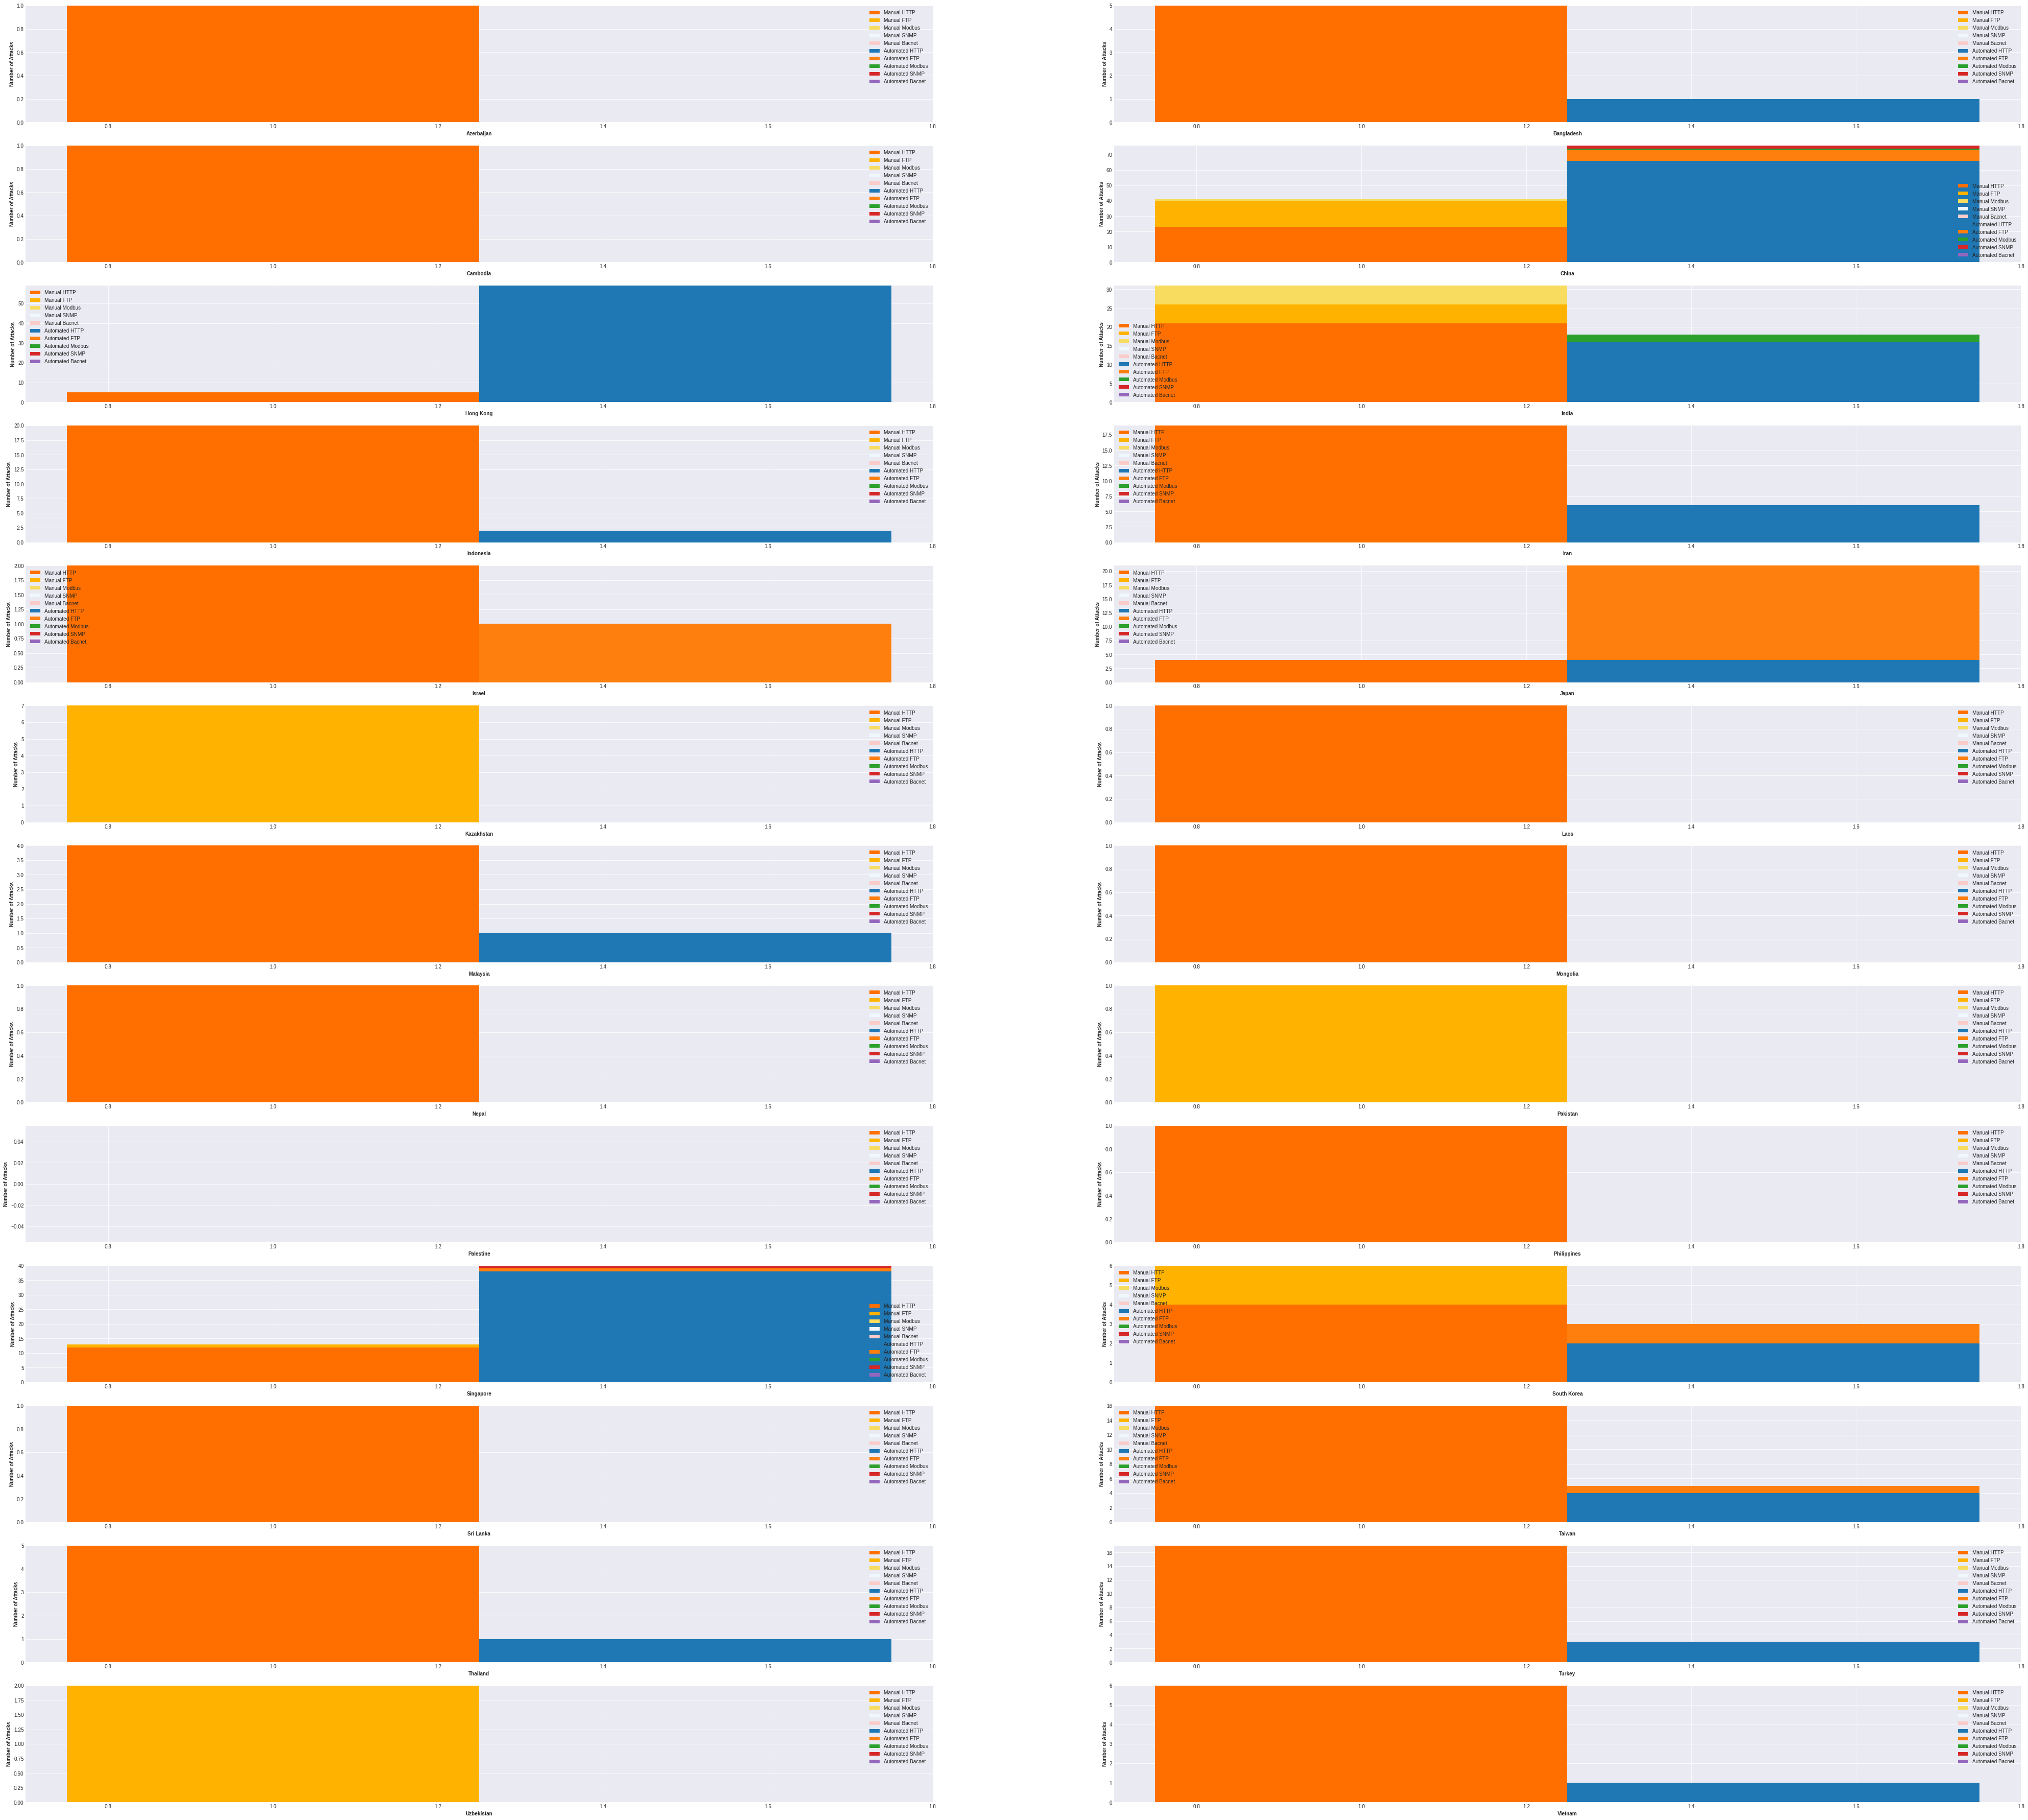

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'AS'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacks
attackpercountry={}
typeofattackpercntry={}
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['AS']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(20,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

Automated in  Australia :  1
Manual in  Australia :  17


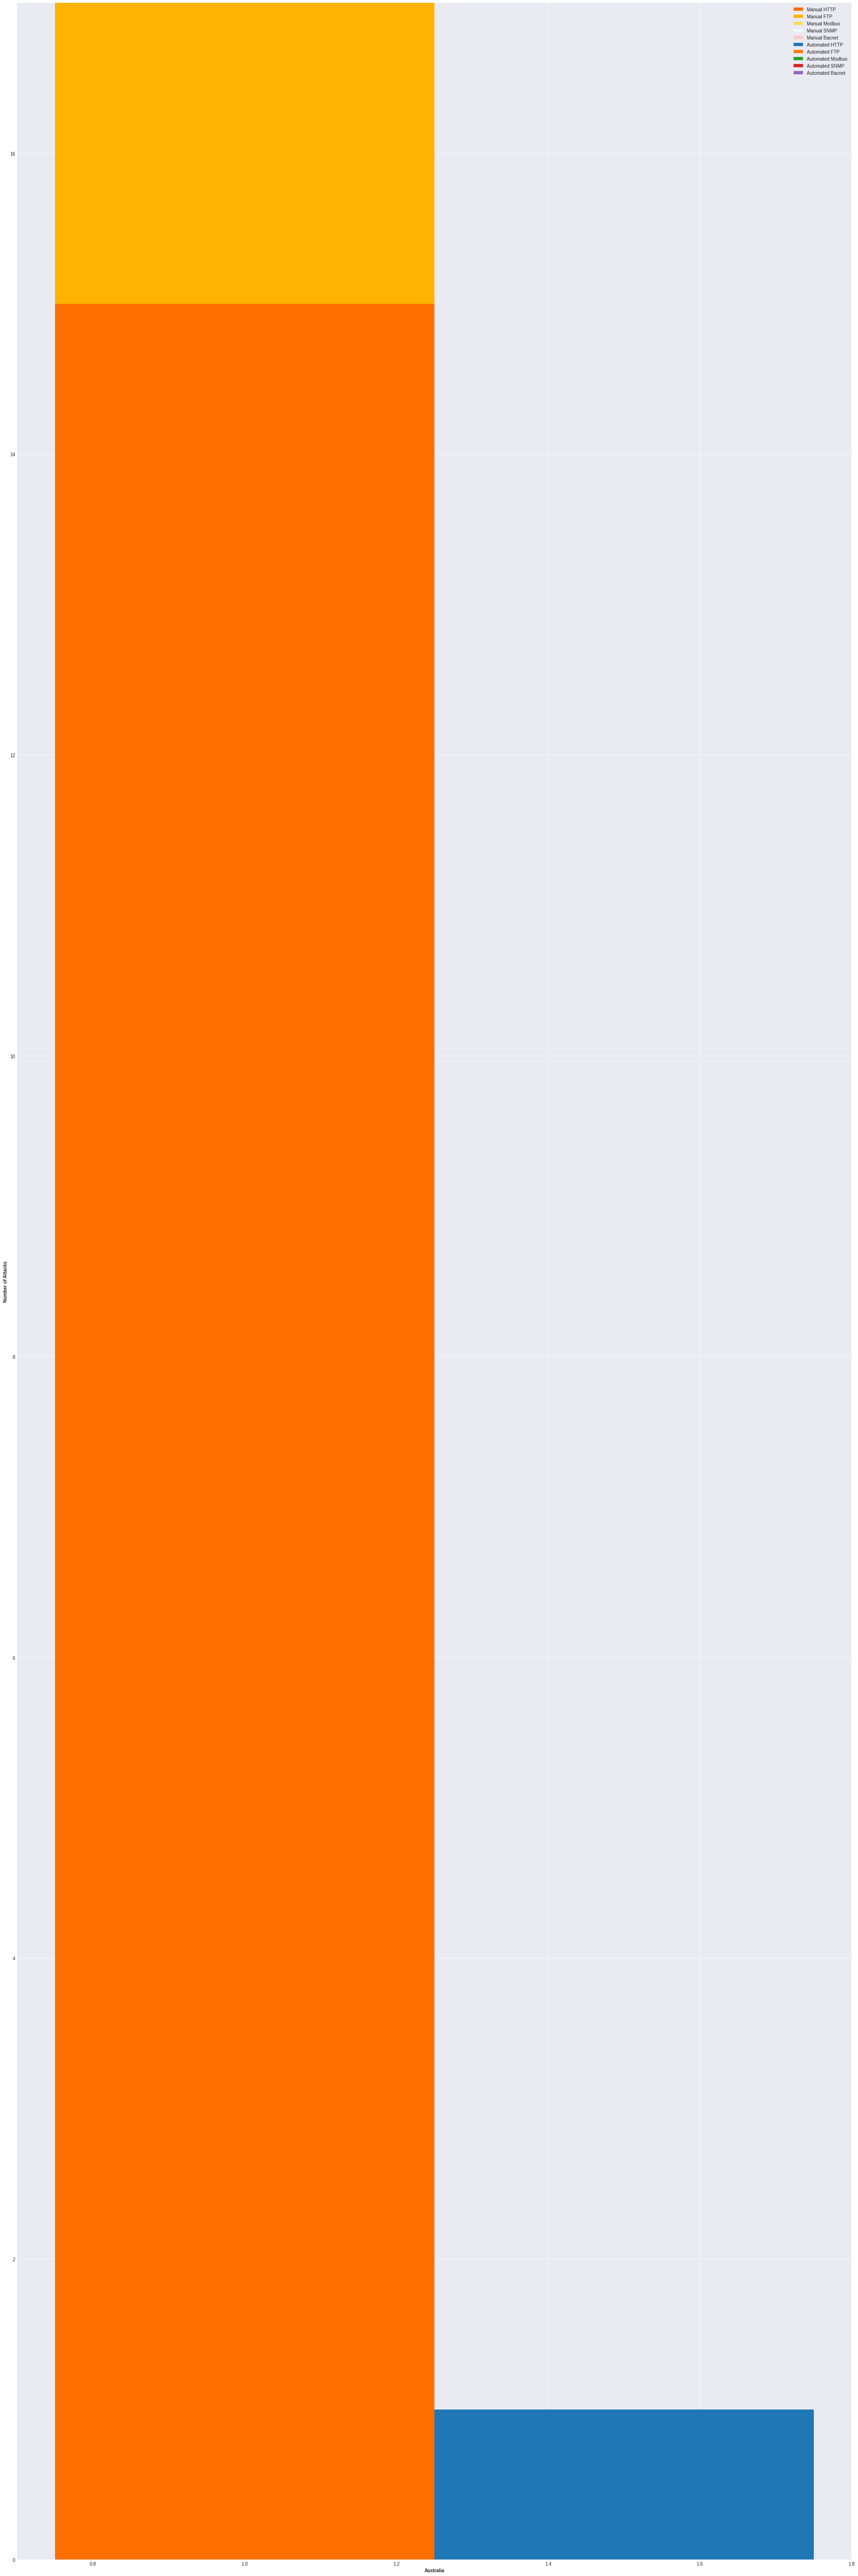

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'OC'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacks
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['OC']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(1,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

Automated in  Austria :  0
Manual in  Austria :  1
Automated in  Belarus :  1
Manual in  Belarus :  0
Automated in  Belgium :  0
Manual in  Belgium :  6
Automated in  Bosnia and Herzegovina :  0
Manual in  Bosnia and Herzegovina :  1
Automated in  Bulgaria :  4
Manual in  Bulgaria :  3
Automated in  Croatia :  0
Manual in  Croatia :  1
Automated in  Czechia :  0
Manual in  Czechia :  1
Automated in  Denmark :  0
Manual in  Denmark :  2
Automated in  Finland :  0
Manual in  Finland :  1
Automated in  France :  30
Manual in  France :  106
Automated in  Germany :  38
Manual in  Germany :  188
Automated in  Greece :  0
Manual in  Greece :  7
Automated in  Hungary :  0
Manual in  Hungary :  4
Automated in  Iceland :  1
Manual in  Iceland :  4
Automated in  Ireland :  2
Manual in  Ireland :  1
Automated in  Italy :  1
Manual in  Italy :  25
Automated in  Jersey :  0
Manual in  Jersey :  1
Automated in  Latvia :  0
Manual in  Latvia :  4
Automated in  Lithuania :  3
Manual in  Lithuania :  2


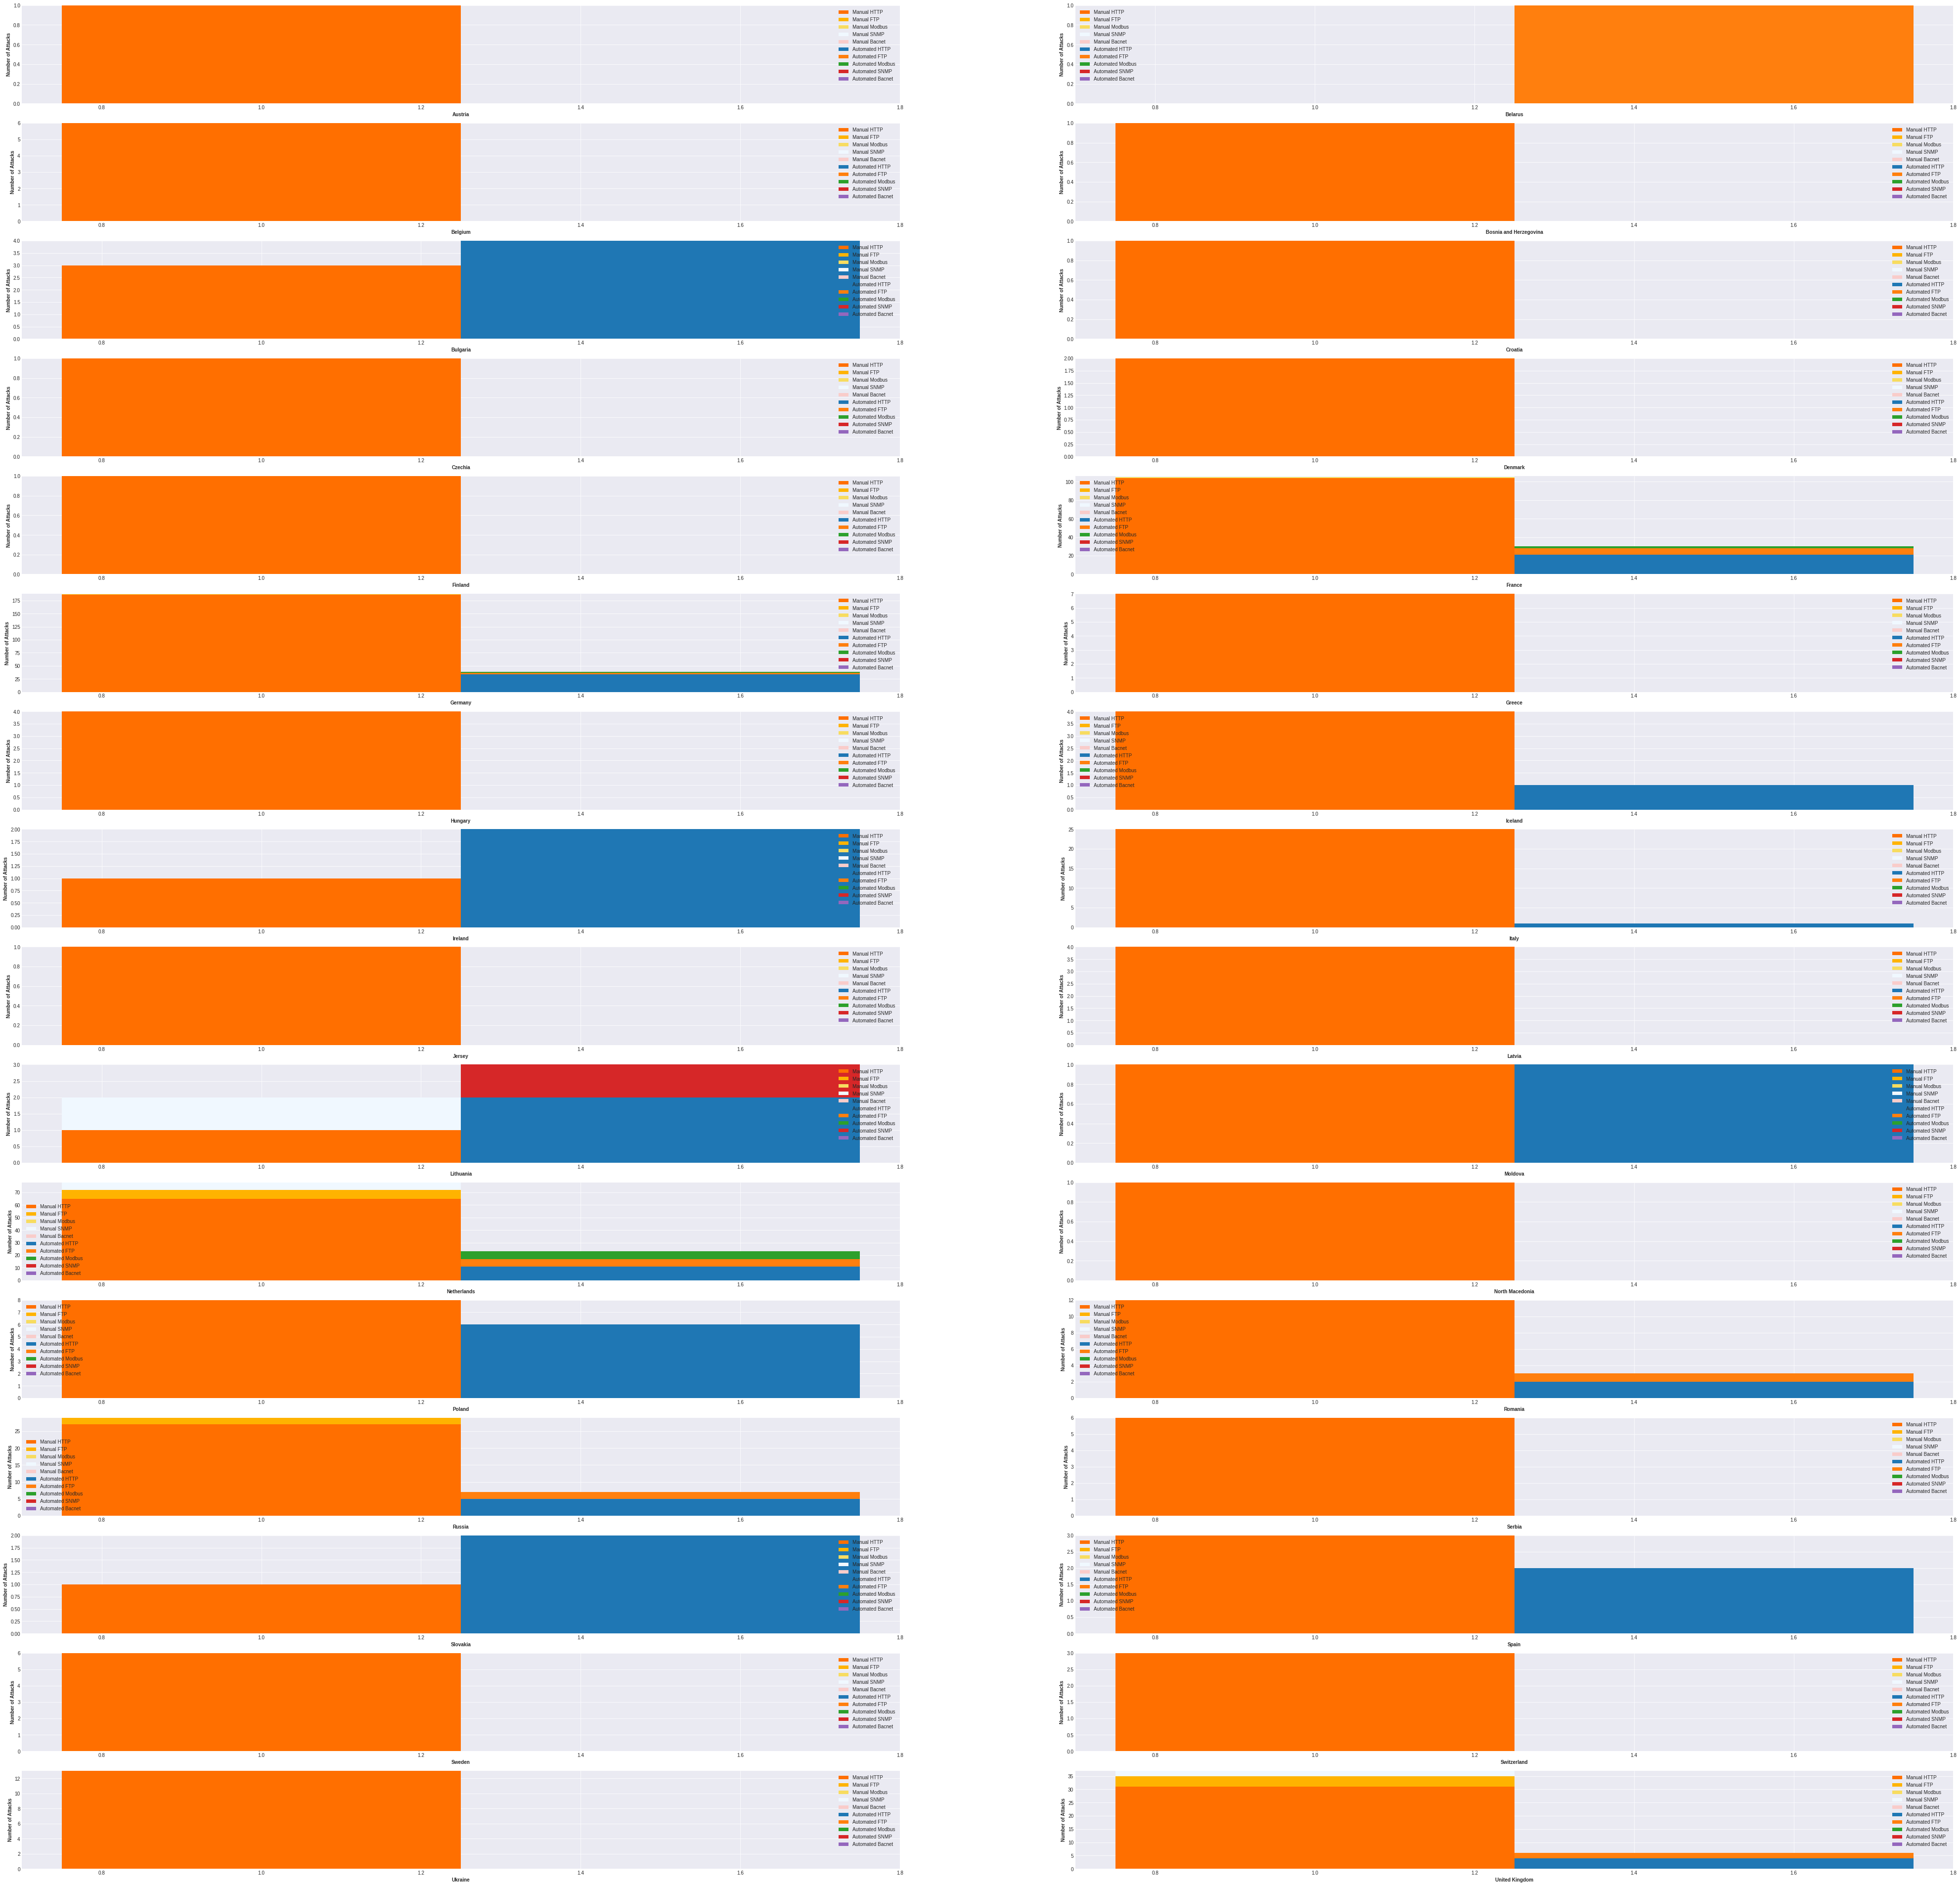

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'EU'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacks
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['EU']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(23,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

Automated in  Argentina :  3
Manual in  Argentina :  5
Automated in  Bolivia :  0
Manual in  Bolivia :  1
Automated in  Brazil :  8
Manual in  Brazil :  72
Automated in  Chile :  1
Manual in  Chile :  6
Automated in  Colombia :  0
Manual in  Colombia :  1
Automated in  Ecuador :  2
Manual in  Ecuador :  1
Automated in  Suriname :  1
Manual in  Suriname :  2
Automated in  Uruguay :  0
Manual in  Uruguay :  1
Automated in  Venezuela :  0
Manual in  Venezuela :  1


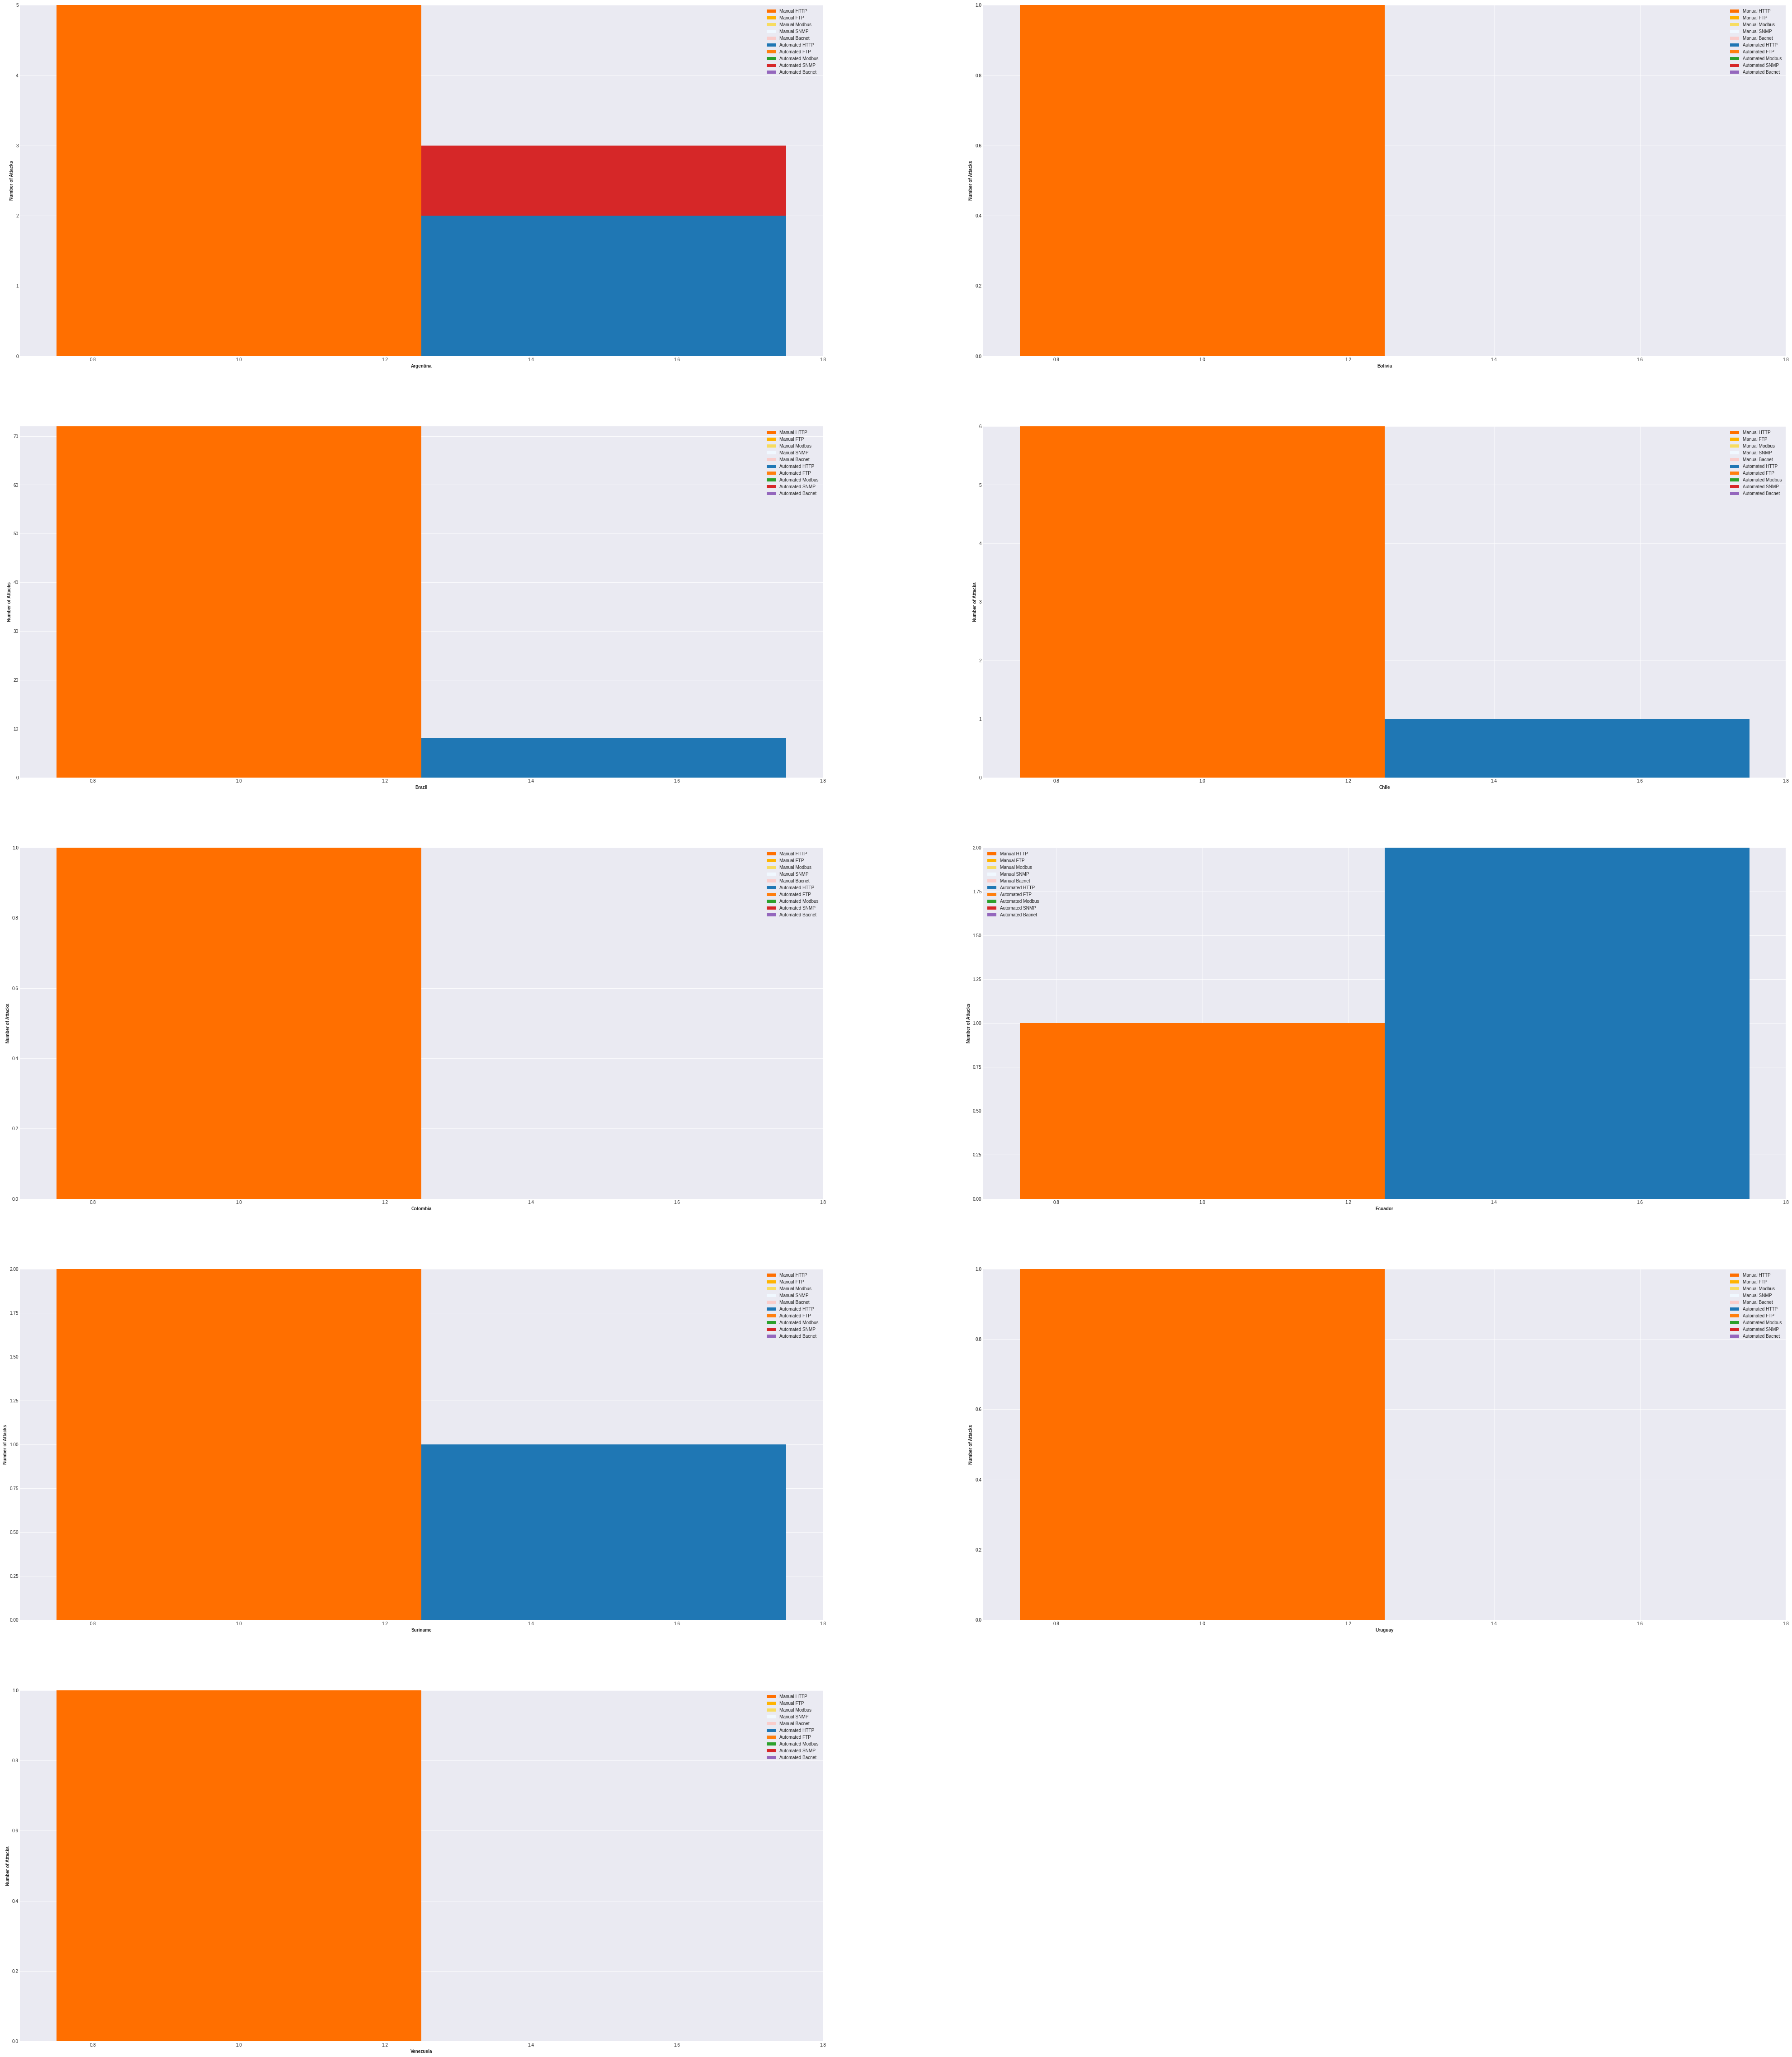

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'SA'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacksplt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['SA']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(6,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

Automated in  Canada :  5
Manual in  Canada :  17
Automated in  Dominican Republic :  0
Manual in  Dominican Republic :  1
Automated in  Honduras :  0
Manual in  Honduras :  5
Automated in  Mexico :  2
Manual in  Mexico :  7
Automated in  Puerto Rico :  0
Manual in  Puerto Rico :  1
Automated in  Trinidad and Tobago :  1
Manual in  Trinidad and Tobago :  0
Automated in  United States :  96
Manual in  United States :  253


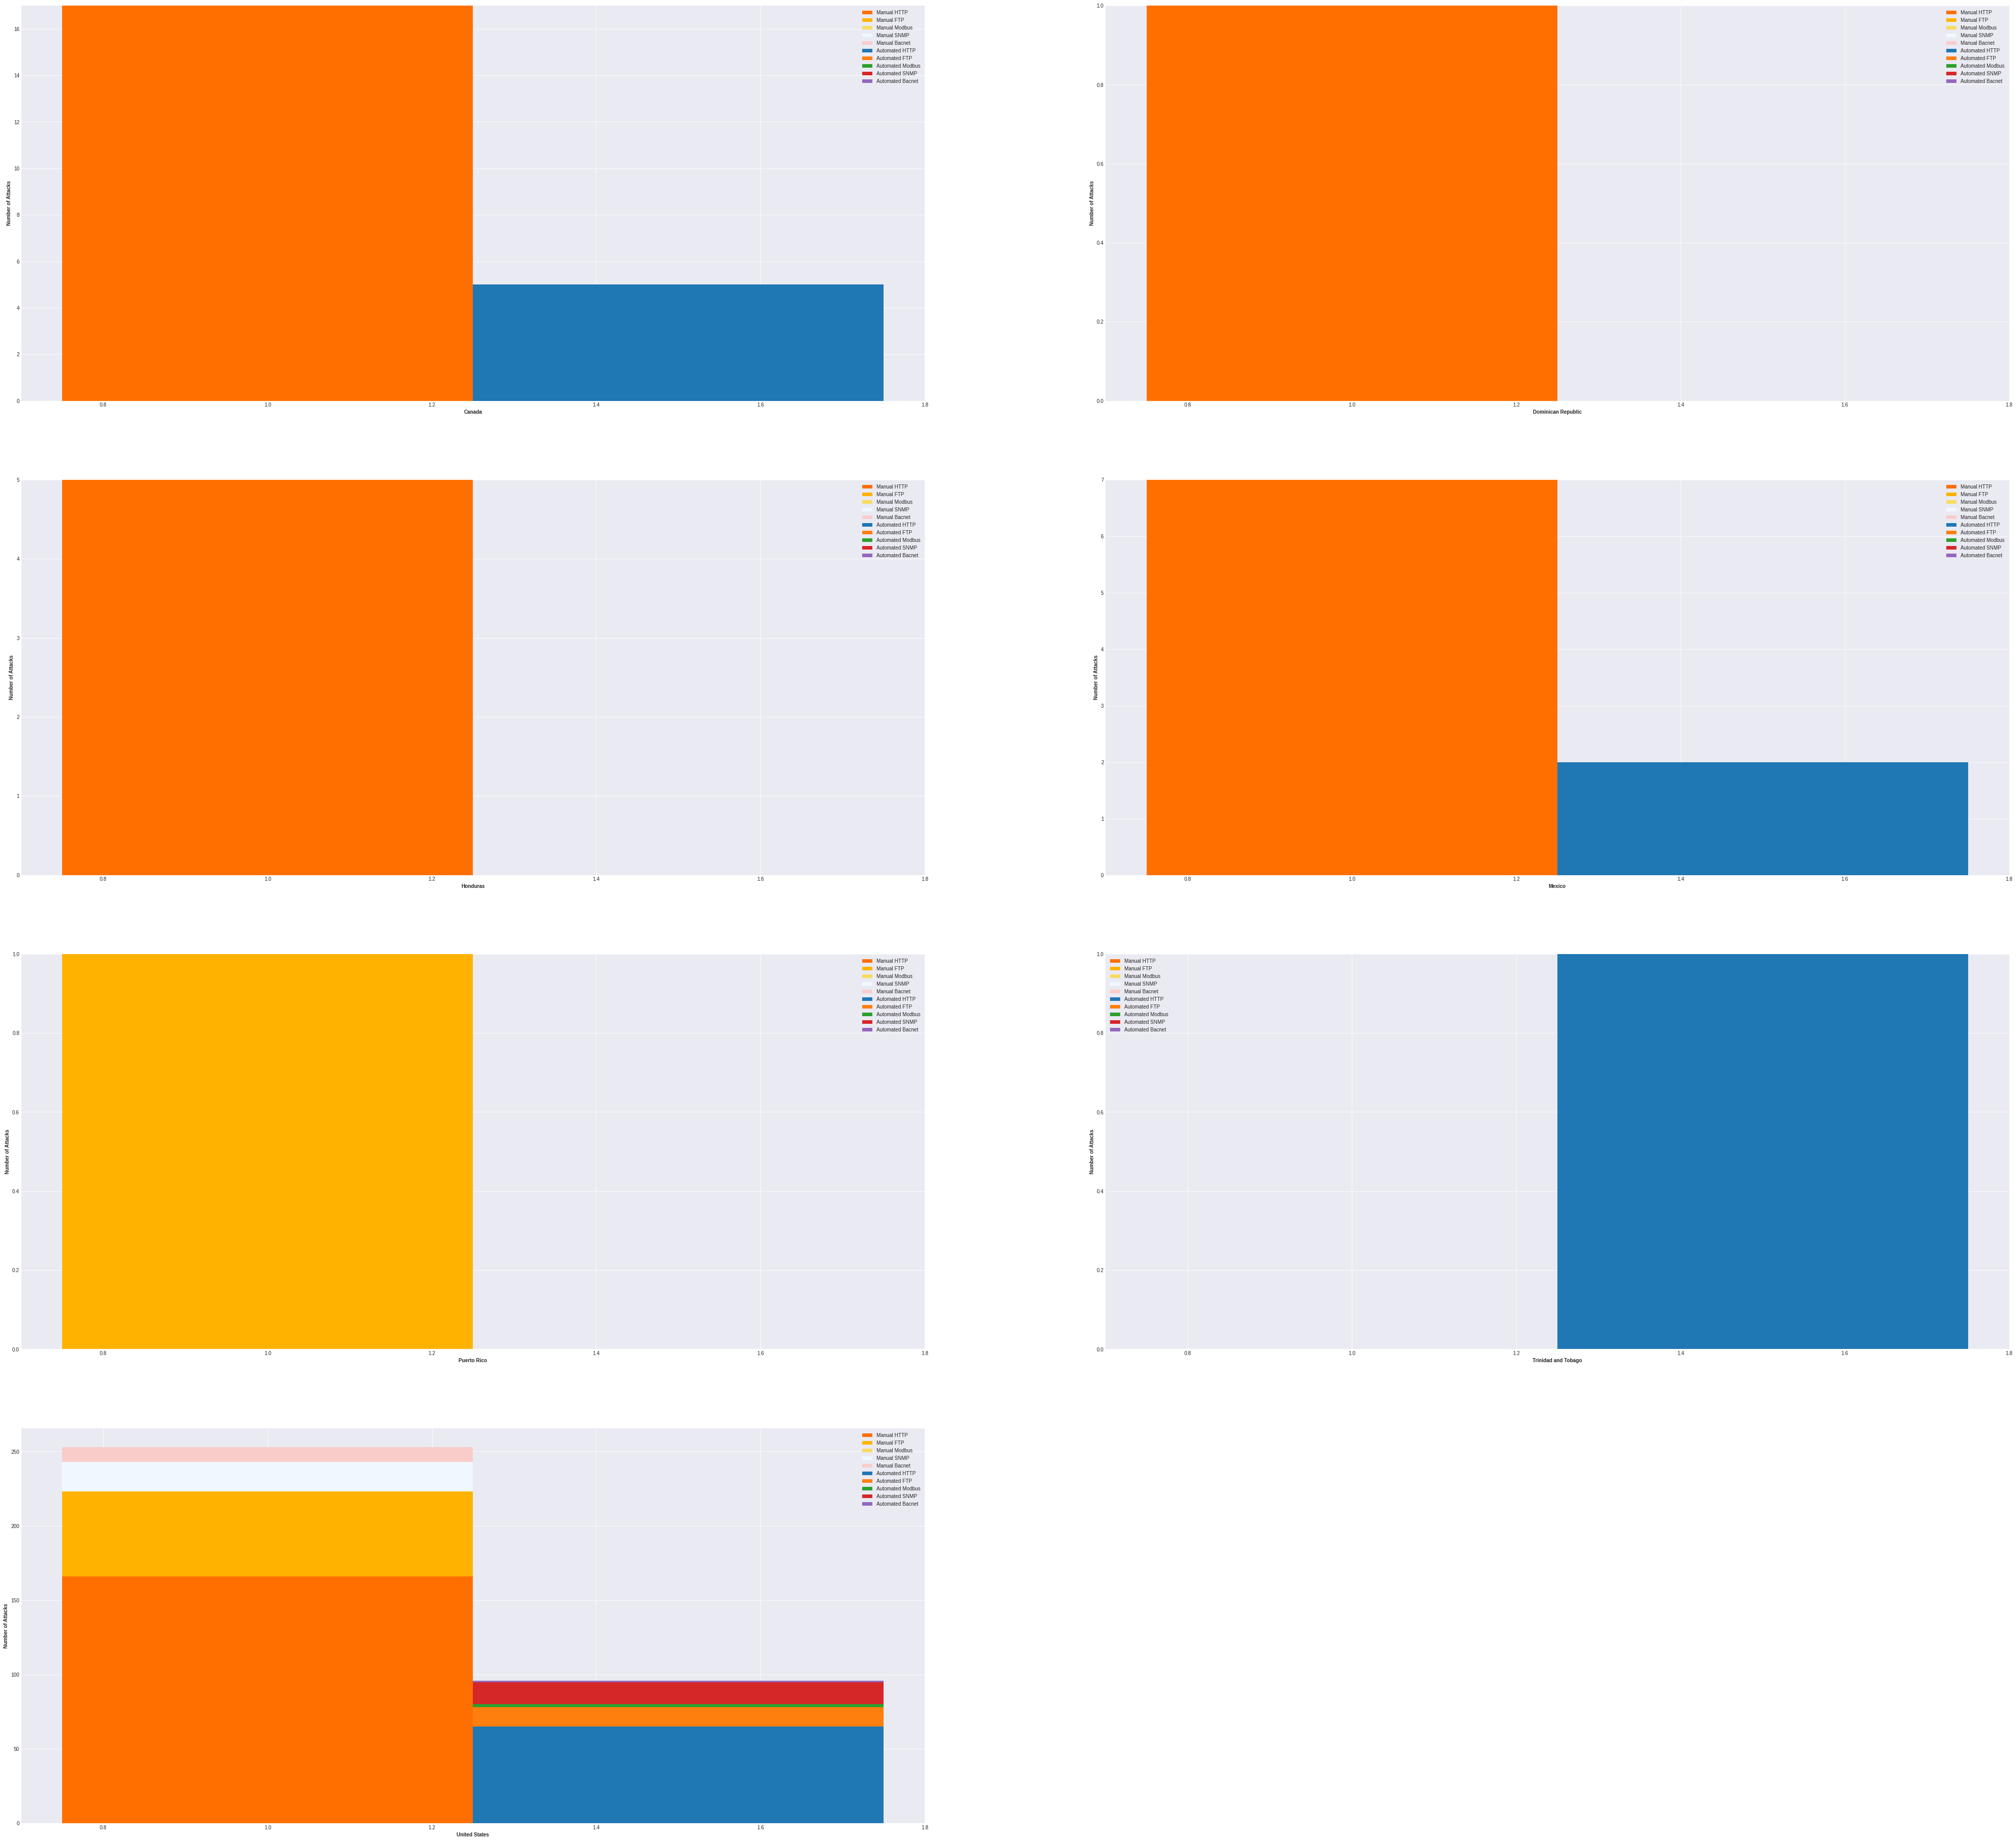

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'NA'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacks
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['NA']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(6,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

Automated in  Benin :  0
Manual in  Benin :  1
Automated in  Burundi :  0
Manual in  Burundi :  2
Automated in  Egypt :  1
Manual in  Egypt :  0
Automated in  Kenya :  1
Manual in  Kenya :  1
Automated in  Libya :  0
Manual in  Libya :  1
Automated in  Mauritius :  1
Manual in  Mauritius :  4
Automated in  Morocco :  1
Manual in  Morocco :  1
Automated in  Nigeria :  0
Manual in  Nigeria :  2
Automated in  Seychelles :  7
Manual in  Seychelles :  3
Automated in  South Africa :  0
Manual in  South Africa :  7
Automated in  Tanzania :  0
Manual in  Tanzania :  1
Automated in  Tunisia :  0
Manual in  Tunisia :  1


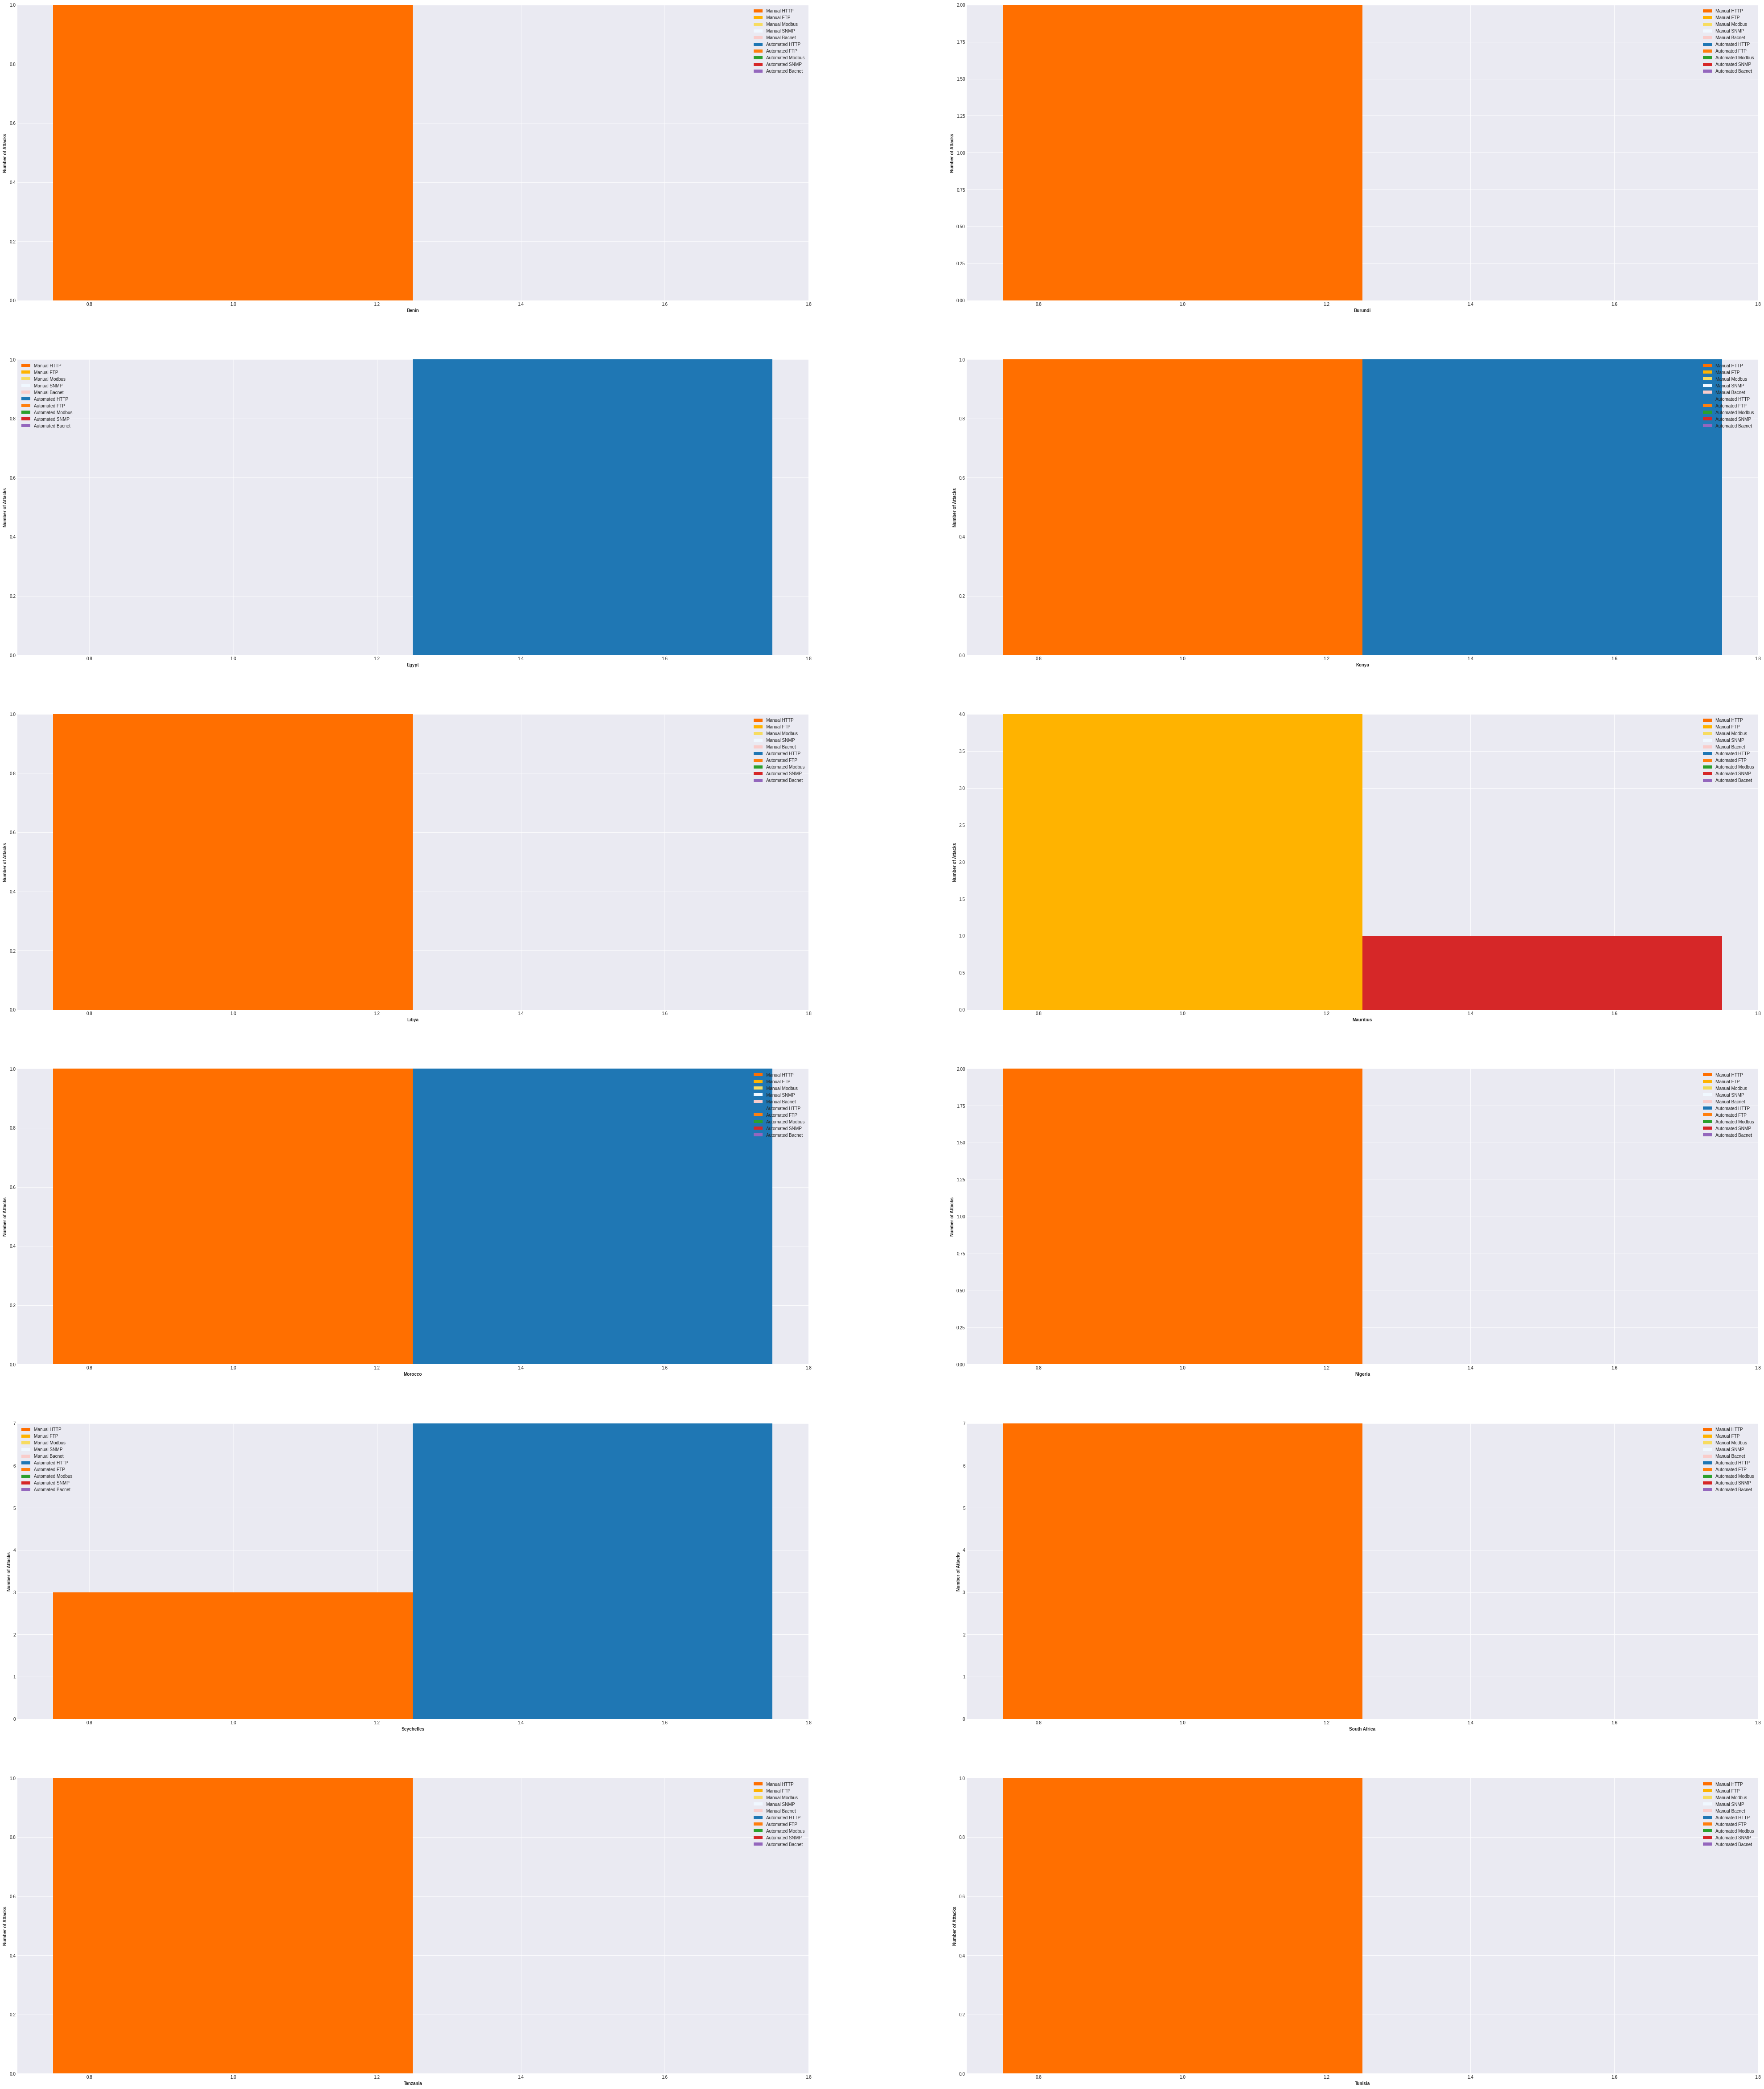

In [ ]:
#auto - number of automated attacks in the dataset
#man - number of manual attacks in the dataset
#ah - number of HTTP automated attacks in the dataset
#af - number of FTP automated attacks in the dataset
#ab - number of BACNET automated attacks in the dataset
#am - number of MODBUS automated attacks in the dataset
#asn - number of SNMP automated attacks in the dataset
#mh - number of manual HTTP attacks in the dataset
#mf - number of manual FTP attacks in the dataset
#mb - number of manual BACNET attacks in the dataset
#mm - number of manual MODBUS attacks in the dataset
#msn - number of manual SNMP attacks in the dataset
#countrylst - list that contains all countries in coutinent 'AF'
#country - iterate through the keys (country names) of dictionary 'continentd' 
#i - iterate through countries (contents) of list countrylst
#j - iterate through the sessions od dataframe 'attackdf'
#attackpercountry - dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
#typeofattackpercntry - dictionary with key as countries and values as list containing different types of manual and automated attacks
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(70,100))
import re
countrylst=[]
for country in continentd['AF']:
  countrylst.append(country)
for i in range(len(countrylst)):
  auto=0
  man=0
  ah=0
  af=0
  ab=0
  am=0
  asn=0
  mh=0
  mf=0
  mb=0
  mm=0
  msn=0
  for j in range(len(attackdf)):
    if re.search(str(countrylst[i]),str(attackdf.loc[j,'COUNTRY'])):
      if attackdf.loc[j,'TYPE OF ATTACK']=='Automated':
        auto=auto+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          ah=ah+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          af=af+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          am=am+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          asn=asn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          ab=ab+1
      elif attackdf.loc[j,'TYPE OF ATTACK']=='Manual':
        man=man+1
        if attackdf.loc[j,'PROTOCOL']=='HTTP':
          mh=mh+1
        elif attackdf.loc[j,'PROTOCOL']=='FTP':
          mf=mf+1
        elif attackdf.loc[j,'PROTOCOL']=='MODBUS':
          mm=mm+1
        elif attackdf.loc[j,'PROTOCOL']=='SNMP':
          msn=msn+1
        elif attackdf.loc[j,'PROTOCOL']=='BACNET':
          mb=mb+1
  attackpercountry[countrylst[i]]=[man+auto,man,auto]
  typeofattackpercntry[countrylst[i]]=[mh,mf,mm,msn,mb,ah,af,am,asn,ab]
  print("Automated","in ",countrylst[i], ": ",auto)
  print("Manual","in ",countrylst[i], ": ",man)
  plt.subplot(7,2,i+1)
  # Make the plot
  plt.bar(1,mh, label = "Manual HTTP", width = 0.5, color = '#FF6F00')
  plt.bar(1,mf, label = "Manual FTP", width = 0.5, bottom = mh, color = '#FFB300')
  plt.bar(1,mm, label = "Manual Modbus", width = 0.5, bottom = np.add(mh,mf), color = '#F7DC60')
  plt.bar(1,msn, label = "Manual SNMP", width = 0.5, bottom = np.add(np.add(mh,mf),mm),color='#F0F8FF')
  plt.bar(1,mb, label = "Manual Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(mh,mf),mm),msn),color='#F9CCCA')
  plt.bar(1.5,ah, label = "Automated HTTP", width = 0.5)
  plt.bar(1.5,af, label = "Automated FTP", width = 0.5, bottom = ah)
  plt.bar(1.5,am, label = "Automated Modbus", width = 0.5, bottom = np.add(ah,af))
  plt.bar(1.5,asn, label = "Automated SNMP", width = 0.5, bottom = np.add(np.add(ah,af),am))
  plt.bar(1.5,ab, label = "Automated Bacnet", width = 0.5, bottom =  np.add(np.add(np.add(ah,af),am),asn))

  # Add xticks on the middle of the group bars
  plt.xlabel(countrylst[i], fontweight='bold')
  plt.ylabel('Number of Attacks', fontweight='bold')
  plt.legend()

In [ ]:
#Displaying the dictionary with key as countries and values as list containing total number of attacks, number of manual attacks and number of automated attacks
attackpercountry

{'Argentina': [8, 5, 3],
 'Australia': [18, 17, 1],
 'Austria': [1, 1, 0],
 'Azerbaijan': [1, 1, 0],
 'Bangladesh': [6, 5, 1],
 'Belarus': [1, 0, 1],
 'Belgium': [6, 6, 0],
 'Benin': [1, 1, 0],
 'Bolivia': [1, 1, 0],
 'Bosnia and Herzegovina': [1, 1, 0],
 'Brazil': [80, 72, 8],
 'Bulgaria': [7, 3, 4],
 'Burundi': [2, 2, 0],
 'Cambodia': [1, 1, 0],
 'Canada': [22, 17, 5],
 'Chile': [7, 6, 1],
 'China': [117, 41, 76],
 'Colombia': [1, 1, 0],
 'Croatia': [1, 1, 0],
 'Czechia': [1, 1, 0],
 'Denmark': [2, 2, 0],
 'Dominican Republic': [1, 1, 0],
 'Ecuador': [3, 1, 2],
 'Egypt': [1, 0, 1],
 'Finland': [1, 1, 0],
 'France': [136, 106, 30],
 'Germany': [226, 188, 38],
 'Greece': [7, 7, 0],
 'Honduras': [5, 5, 0],
 'Hong Kong': [64, 5, 59],
 'Hungary': [4, 4, 0],
 'Iceland': [5, 4, 1],
 'India': [49, 31, 18],
 'Indonesia': [22, 20, 2],
 'Iran': [25, 19, 6],
 'Ireland': [3, 1, 2],
 'Israel': [3, 2, 1],
 'Italy': [26, 25, 1],
 'Japan': [25, 4, 21],
 'Jersey': [1, 1, 0],
 'Kazakhstan': [7, 7, 0],


In [ ]:
#Displaying the dictionary with key as countries and values as list containing different types of manual and automated attacks
typeofattackpercntry

{'Argentina': [5, 0, 0, 0, 0, 2, 0, 0, 1, 0],
 'Australia': [15, 2, 0, 0, 0, 1, 0, 0, 0, 0],
 'Austria': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Azerbaijan': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Bangladesh': [5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Belarus': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'Belgium': [6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Benin': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Bolivia': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Bosnia and Herzegovina': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Brazil': [72, 0, 0, 0, 0, 8, 0, 0, 0, 0],
 'Bulgaria': [3, 0, 0, 0, 0, 4, 0, 0, 0, 0],
 'Burundi': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Cambodia': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Canada': [17, 0, 0, 0, 0, 5, 0, 0, 0, 0],
 'Chile': [6, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'China': [23, 17, 1, 0, 0, 66, 7, 1, 2, 0],
 'Colombia': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Croatia': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Czechia': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Denmark': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Dominican Republic': [1, 0, 0, 0, 0, 0, 0, 0, 0,

## Top 5 Countries with most attacks:




In [ ]:
#Sorting 'attackpercountry' using sorted() with lambda function
sortedattackpercountry=sorted(attackpercountry.items(), key=lambda e: e[1][0],reverse=True)

In [ ]:
pip install more_itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import more_itertools

In [ ]:
#Take the top 5 entries of dictionary 'sortedattackpercountry'
top5countries=more_itertools.take(5,sortedattackpercountry)

In [ ]:
#Displaying the top 5 most attacking countries
top5countries

[('United States', [349, 253, 96]),
 ('Germany', [226, 188, 38]),
 ('France', [136, 106, 30]),
 ('China', [117, 41, 76]),
 ('Netherlands', [101, 78, 23])]

#Observations :

##Only manual attacks:

In [ ]:
#Displaying countries that had done only automated attacks 
#c - iterates over each country (key )in dictionary  attackpercountry
for c in attackpercountry:
  if attackpercountry[c][0]!=0 and attackpercountry[c][2]==0:
    print(c)

Azerbaijan
Cambodia
Kazakhstan
Laos
Mongolia
Nepal
Pakistan
Philippines
Sri Lanka
Uzbekistan
Austria
Belgium
Bosnia and Herzegovina
Croatia
Czechia
Denmark
Finland
Greece
Hungary
Jersey
Latvia
North Macedonia
Serbia
Sweden
Switzerland
Ukraine
Bolivia
Colombia
Uruguay
Venezuela
Dominican Republic
Honduras
Puerto Rico
Benin
Burundi
Libya
Nigeria
South Africa
Tanzania
Tunisia


##Only automated attacks

In [ ]:
#Displaying countries that had done only automated attacks 
#c - iterates over each country (key )in dictionary  attackpercountry
for c in attackpercountry:
  if attackpercountry[c][0]!=0 and attackpercountry[c][1]==0:
    print(c)

Belarus
Trinidad and Tobago
Egypt


##More number of automated attacks than manual attacks per country:

In [ ]:
#Displaying countries that had done more automated attacks than manual attacks
#c - iterates over each country (key )in dictionary typeofattackpercntry
for c in typeofattackpercntry:
  if sum(typeofattackpercntry[c][5:])>sum(typeofattackpercntry[c][:5]):
    print(c)

Asia,Europe and African subcontinent countries were observed to do much of the automated attacks

##Automated or manual were prevelant based on type of protocol:

In [ ]:
#msnmp- variable to hold number of manual snmp attacks per country
#asnmp - variable to hold number of automated snmp attacks per country
#c - iterate over countries in dictionary typeofattackpercntry
msnmp=0
asnmp=0
for c in typeofattackpercntry:
  msnmp=msnmp+typeofattackpercntry[c][3]
  asnmp=asnmp+typeofattackpercntry[c][8]
if msnmp>asnmp:
  print("Manual SNMP attacks were more prevalent than automated ones")
else:
  print("Automated SNMP attacks were more prevalent than manual ones")

Manual SNMP attacks were more prevalent than automated ones


In [ ]:
#mhttp- variable to hold number of manual attacks per country
#ahttp - variable to hold number of automated attacks per country
#c - iterate over countries in dictionary typeofattackpercntry
mhttp=0
ahttp=0
for c in typeofattackpercntry:
  mhttp=mhttp+typeofattackpercntry[c][0]
  ahttp=ahttp+typeofattackpercntry[c][4]
if mhttp>ahttp:
  print("Manual HTTP attacks were more prevalent than automated ones")
else:
  print("Automated HTTP attacks were more prevalent than manual ones")

Manual HTTP attacks were more prevalent than automated ones


In [ ]:
#mftp- variable to hold number of manual attacks per country
#aftp - variable to hold number of automated attacks per country
#c - iterate over countries in dictionary typeofattackpercntry
mftp=0
aftp=0
for c in typeofattackpercntry:
  mftp=mftp+typeofattackpercntry[c][1]
  aftp=aftp+typeofattackpercntry[c][5]
if mftp>aftp:
  print("Manual FTP attacks were more prevalent than automated ones")
else:
  print("Automated FTP attacks were more prevalent than manual ones")

Automated FTP attacks were more prevalent than manual ones


In [ ]:
#mhttp- variable to hold number of manual attacks per country
#ahttp - variable to hold number of automated attacks per country
#c - iterate over countries in dictionary typeofattackpercntry
mmod=0
amod=0
for c in typeofattackpercntry:
  mmod=mmod+typeofattackpercntry[c][2]
  amod=amod+typeofattackpercntry[c][6]
if mmod>amod:
  print("Manual Modbus attacks were more prevalent than automated ones")
else:
  print("Automated Modbus attacks were more prevalent than manual ones")

Automated Modbus attacks were more prevalent than manual ones


In [ ]:
#mhttp- variable to hold number of manual attacks per country
#ahttp - variable to hold number of automated attacks per country
#c - iterate over countries in dictionary typeofattackpercntry
mbac=0
abac=0
for c in typeofattackpercntry:
  mbac=mbac+typeofattackpercntry[c][4]
  abac=abac+typeofattackpercntry[c][9]
if mbac>abac:
  print("Manual Bacnet attacks were more prevalent than automated ones")
else:
  print("Automated Bacnet attacks were more prevalent than manual ones")

Manual Bacnet attacks were more prevalent than automated ones


## Attack analysis per country

In [ ]:
#Function to display the different types of attacks of each country; country name is to be provided 
def countryanalysis(c):
  print("Number of Manual attacks: ",sum(typeofattackpercntry[c][:5]))
  print("Number of Automated attacks: ",sum(typeofattackpercntry[c][5:]))
  print("Number of HTTP attacks: ",typeofattackpercntry[c][0]+typeofattackpercntry[c][5])
  print("Number of FTP attacks: ",typeofattackpercntry[c][1]+typeofattackpercntry[c][6])
  print("Number of Modbus attacks: ",typeofattackpercntry[c][2]+typeofattackpercntry[c][7])
  print("Number of SNMP attacks: ",typeofattackpercntry[c][3]+typeofattackpercntry[c][8])
  print("Number of Bacnet attacks: ",typeofattackpercntry[c][4]+typeofattackpercntry[c][9])

In [ ]:
# Displaying the attack statistics of country 'India'
countryanalysis('India')

Number of Manual attacks:  31
Number of Automated attacks:  18
Number of HTTP attacks:  37
Number of FTP attacks:  5
Number of Modbus attacks:  7
Number of SNMP attacks:  0
Number of Bacnet attacks:  0


In [ ]:
# Displaying the attack statistics of country 'Japan'
countryanalysis('Japan')

Number of Manual attacks:  4
Number of Automated attacks:  21
Number of HTTP attacks:  8
Number of FTP attacks:  17
Number of Modbus attacks:  0
Number of SNMP attacks:  0
Number of Bacnet attacks:  0


In [ ]:
# Displaying the attack statistics of country 'United States'
countryanalysis('United States')

Number of Manual attacks:  253
Number of Automated attacks:  96
Number of HTTP attacks:  231
Number of FTP attacks:  70
Number of Modbus attacks:  2
Number of SNMP attacks:  35
Number of Bacnet attacks:  11


## Most attacks per continent (from which country):

In [ ]:
#c- iterate through each continent in continentd dictionary 
#m- to update the number of attacks of the country with the most attacks; initialized to 0
#countrym- name country with maximum attacks in that continent; initialized to 0
#conti - continent name passed to function
def percontinentattackcountry(conti):
  m=0
  for c in continentd[conti]:
    if attackpercountry[c][0]>m:
      countrym=c
      m=attackpercountry[c][0]
  print('Most attacks from',countrym,'of continent', conti)

In [ ]:
#Displaying the country with the most number of attacks in Europe
percontinentattackcountry('EU')

Most attacks from Germany of continent EU


In [ ]:
#Displaying the country with the most number of attacks in South America
percontinentattackcountry('SA')

Most attacks from Brazil of continent SA


In [ ]:
#Displaying the country with the most number of attacks in Africa
percontinentattackcountry('AF')

Most attacks from Seychelles of continent AF


In [ ]:
#Displaying the country with the most number of attacks in Nort America
percontinentattackcountry('NA')

Most attacks from United States of continent NA


In [ ]:
#Displaying the country with the most number of attacks in Oceania
percontinentattackcountry('OC')

Most attacks from Australia of continent OC


In [ ]:
#Displaying the country with the most number of attacks in Asia
percontinentattackcountry('AS')

Most attacks from China of continent AS
